In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import folium

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_raw = pd.read_csv("reviews_summary.csv",
                     true_values=['t'], false_values=['f'], na_values=[None, 'none'], parse_dates=["date"])
df_raw_copy = df_raw.copy()
df_raw.head(2)

listing_id       date
0        6369 2010-03-14
1        6369 2010-03-23

# 1. Valores perdidos y duplicados

## 1.1. Valores perdidos
Se pueden utilizar tanto seaborn como missigno (librería específica para missing data, https://github.com/ResidentMario/missingno).

In [3]:
df_raw_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830895 entries, 0 to 830894
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   listing_id  830895 non-null  int64         
 1   date        830895 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 12.7 MB


In [4]:
import missingno as msno

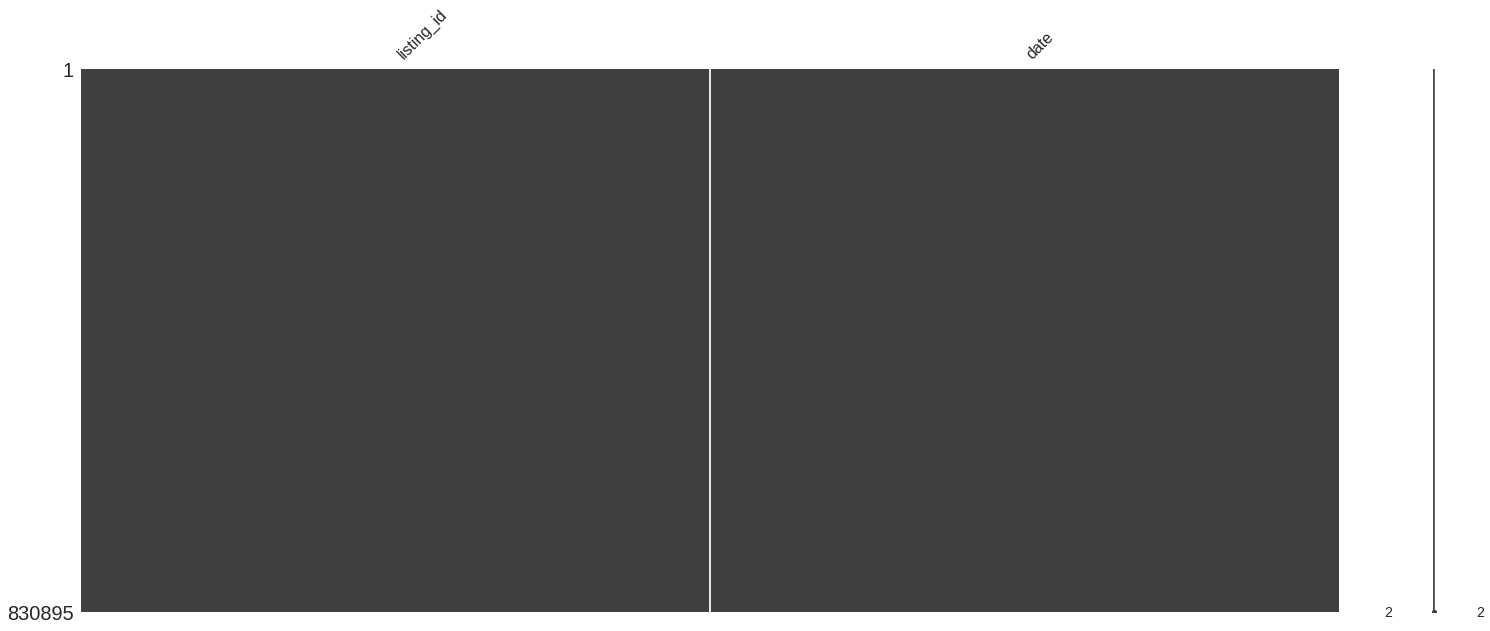

In [5]:
msno.matrix(df_raw_copy)

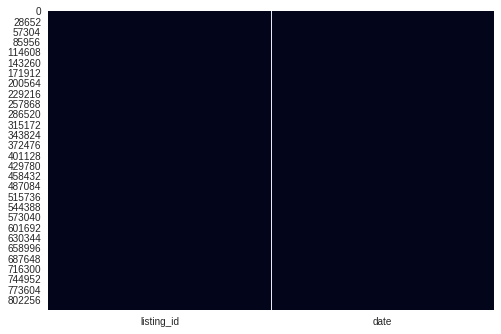

In [6]:
sns.heatmap(df_raw_copy.isnull(), cbar=False)

In [7]:
plt.style.use("default")

## 1.3. Preparación de los datos <a class = "anchor" id = "PData" >  </a>

In [8]:
# Datos desde 2010-2019
df_raw_10_19 = df_raw_copy
import datetime
date1 = datetime.datetime(2010,1,1)
date2 = datetime.datetime(2010,2,28)
date3 = datetime.datetime(2019,12,31)
date4 = datetime.datetime(2020,12,31)
interval = pd.date_range(date1, date2, freq = "d")
mydates = pd.DataFrame({"date" : interval, 
                        "reviews" : np.zeros(len(interval)),
                        "listing_id" : np.zeros(len(interval))})
df_raw_10_19 = pd.concat([mydates, df_raw_10_19], ignore_index=True)
df_raw_10_20 = df_raw_10_19[df_raw_10_19["date"].isin(pd.date_range(date1, date4))]
df_raw_10_19 = df_raw_10_19[df_raw_10_19["date"].isin(pd.date_range(date1, date3))]


In [9]:
df_raw_10_19_copy = df_raw_10_19.copy()
df_raw = df_raw_10_19

In [10]:
year = []
month = []
month_number = []
day = []
for i in df_raw["date"] :
    year.append(i.year)
    month.append(i.strftime("%b"))
    month_number.append(i.month)
    day.append(i.day_name())
    
df_raw["year"] = year
df_raw["month"] = month
df_raw["month_number"] = month_number
df_raw["day"] = day
df_raw.loc[len(interval):, "reviews"] = 1

df_raw.head(2)

date  reviews  listing_id  year month  month_number       day
0 2010-01-01      0.0         0.0  2010   Jan             1    Friday
1 2010-01-02      0.0         0.0  2010   Jan             1  Saturday

In [11]:
year = []
month = []
month_number = []
day = []
for i in df_raw_10_20["date"] :
    year.append(i.year)
    month.append(i.strftime("%b"))
    month_number.append(i.month)
    day.append(i.day_name)
    
df_raw_10_20["year"] = year
df_raw_10_20["month"] = month
df_raw_10_20["month_number"] = month_number
df_raw_10_20["day"] = day
df_raw_10_20.loc[len(interval):, "reviews"] = 1

df_raw_10_20.tail(2)

date  reviews  listing_id  year month  month_number  \
830952 2020-02-16      1.0  42271124.0  2020   Feb             2   
830953 2020-02-16      1.0  42278554.0  2020   Feb             2   

                                                      day  
830952  <bound method Timestamp.day_name of Timestamp(...  
830953  <bound method Timestamp.day_name of Timestamp(...

# 2. Análisis Exploratorio de los Datos (EDA) <a class = "anchor" id = "EDA"> </a>

## 2.1. Gráficas <a class = "anchor" id = "Plots"> </a>

#### a) Gráfica de barras

In [12]:
df_raw.set_index("date", inplace = True)        

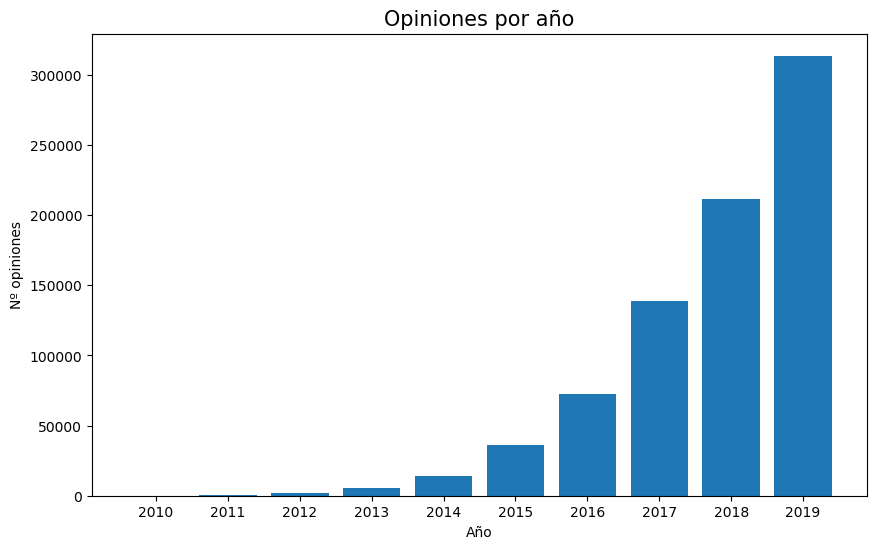

In [13]:
df_raw_grouped_year =  df_raw.groupby(["year"]).sum()["reviews"]

fig, ax = plt.subplots(figsize = (10,6))
plt.bar(df_raw_grouped_year.index, df_raw_grouped_year.values)

#Decoration
plt.xlabel("Año")
plt.ylabel("Nº opiniones")
plt.title("Opiniones por año", fontsize = 15)
years = df_raw['year'].unique()
plt.xticks(years)

plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/barplotts.png")


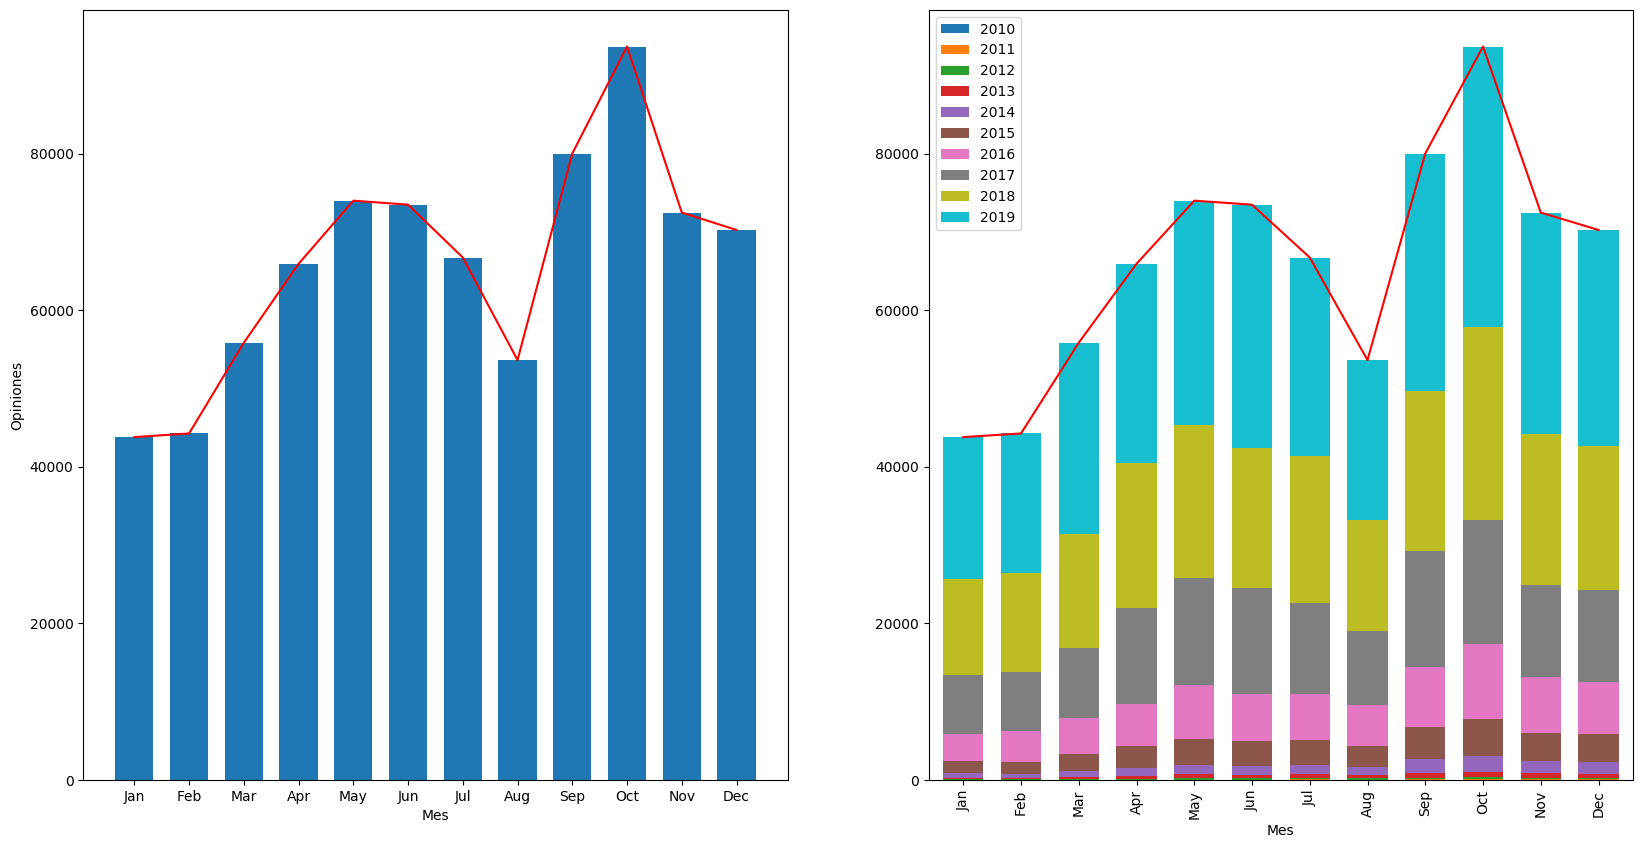

In [14]:
df_raw_grouped_month =  df_raw.groupby(["month_number"]).sum()["reviews"]
df_raw_grouped_month.index = ['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
df_raw_grouped_y_m = df_raw.groupby(["month_number", "year"]).sum()["reviews"].unstack("year").rename(index = {1:'Jan',2:'Feb',3:'Mar',4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})


fig, axes = plt.subplots(1,2, figsize = (20,10))

axes[0].bar(df_raw_grouped_month.index, df_raw_grouped_month.values , width=0.7)
df_raw_grouped_y_m.plot(kind = "bar", width=0.7, stacked=True, ax = axes[1])
axes[0].set_xlabel("Mes")
axes[1].set_xlabel("Mes")
axes[0].set_ylabel("Opiniones")

axes[0].plot(df_raw_grouped_month, color = "r")
axes[1].plot(df_raw_grouped_month, color = "r")
plt.legend()

plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/barplotmeses.png")

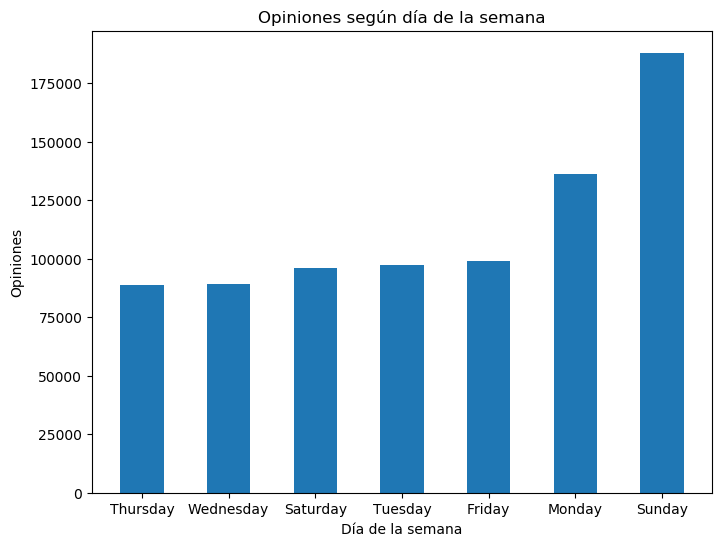

In [15]:
df_raw_grouped_day =  df_raw.groupby(["day"]).sum()["reviews"].sort_values()

fig, ax = plt.subplots(figsize = (8,6))
plt.bar(df_raw_grouped_day.index, df_raw_grouped_day.values, width=0.5)
plt.title("Opiniones según día de la semana")
plt.ylabel("Opiniones")
plt.xlabel("Día de la semana")

plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/barplotdiasemana.png")

#### b) Gráfica de tiempo

In [16]:
def timeplot(timeseries, title, figsize = (15,6)) :

    fig, ax = plt.subplots(figsize = figsize)
    plt.plot(timeseries.index, timeseries)
    plt.xlabel("Fecha")
    plt.ylabel("Opiniones")
    plt.title(title, fontsize = 16)      # I choose to study 15 days period because it is the maximum time that AirBnb enable to do a review

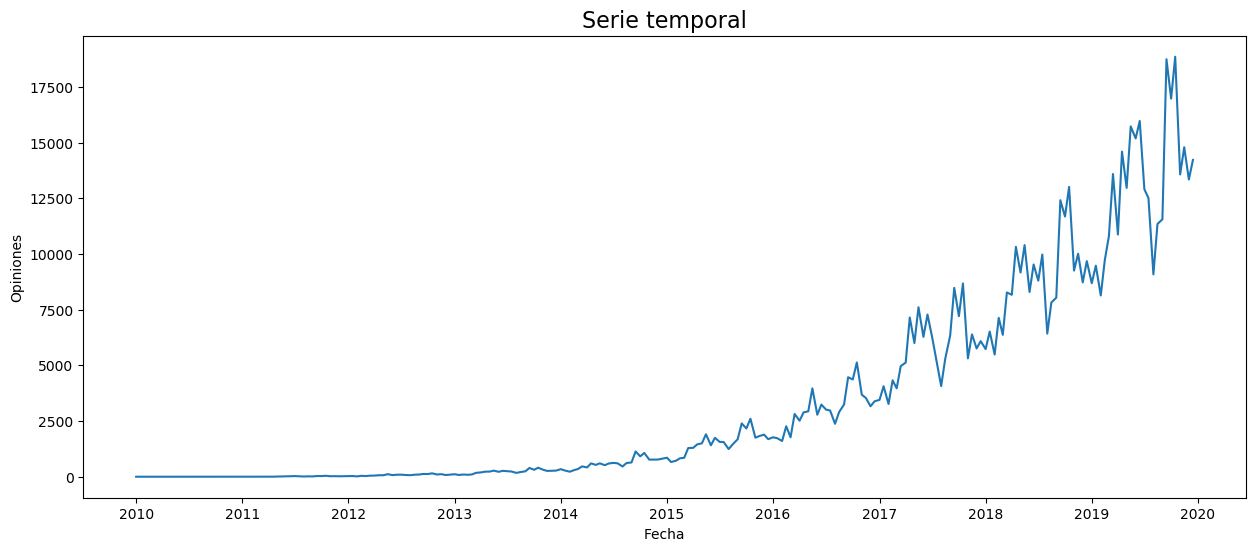

In [17]:
df_raw_grouped_count_2weeks = df_raw.groupby([pd.Grouper(freq = "sms")]).sum()["reviews"]
df_raw_grouped_count_monthly = df_raw.groupby([pd.Grouper(freq = "m")]).sum()["reviews"]

timeplot(df_raw_grouped_count_2weeks, "Serie temporal")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/tstimeplot.png")

La serie tiene una importante tendencia positiva y estacionalidad anual

#### c) Gráfica estacional

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


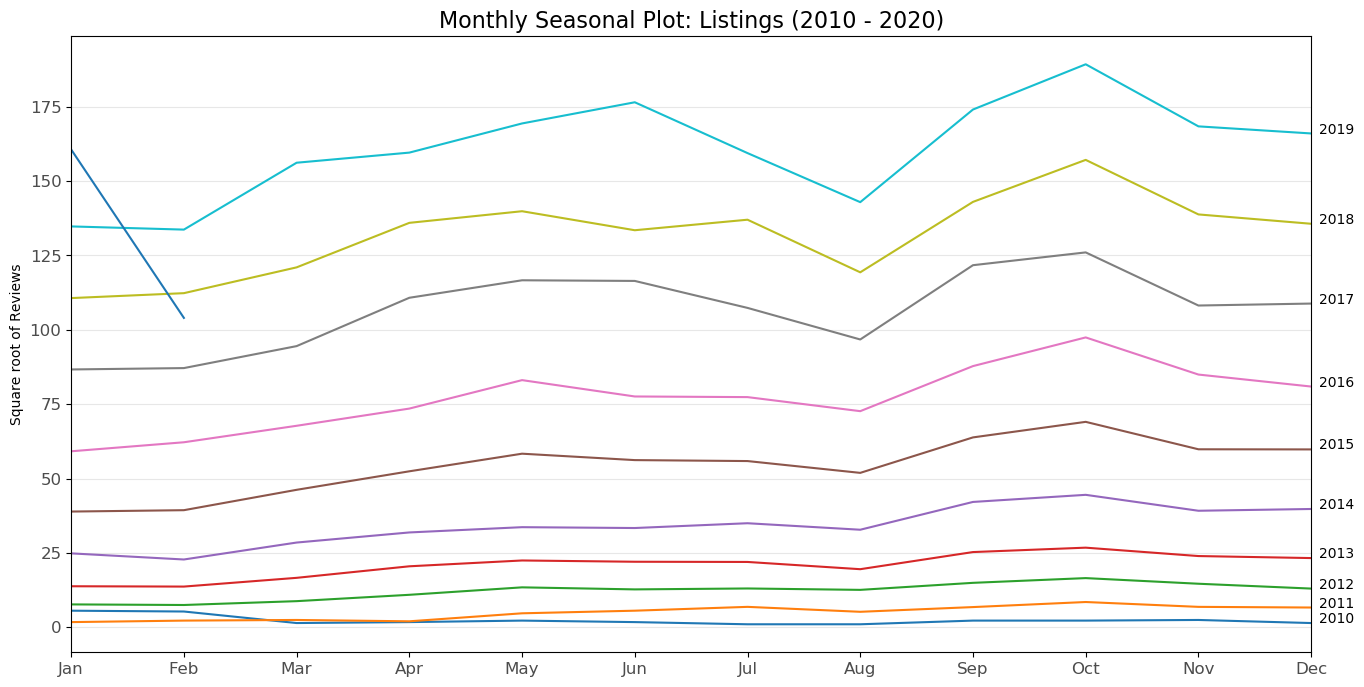

In [18]:
df_seasonal_month = df_raw_10_20.groupby(["year", "month_number"]).count()["reviews"].unstack(0).rename(
    index = {1:'Jan',2:'Feb',3:'Mar',4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
df_seasonal_month = np.sqrt(df_seasonal_month)
# Se ha aplicado una transformación (de raíz cuadrada en este caso) para poder observar mejor los cambios

fig, ax = plt.subplots(figsize = (16,8))

for i in df_seasonal_month.columns :
    ax.plot(df_seasonal_month[i], label = i)
    ax.text(11.07, df_seasonal_month[i][-1:], i)

# Decoration
base = 0
plt.xlim(-0, 11)
plt.ylabel('Square root of Reviews'.format(base))
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.title("Monthly Seasonal Plot: Listings ({first} - {last})".format(first = df_seasonal_month.columns[0], 
                                                                      last=df_seasonal_month.columns[len(df_seasonal_month.columns ) - 1]),
          fontsize=16)
plt.grid(axis='y', alpha=.3)
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/tsseasonaltimeplot.png");

## 2.2. Autocorrelación <a class = "anchor" id = "Autocorrelation"> </a>


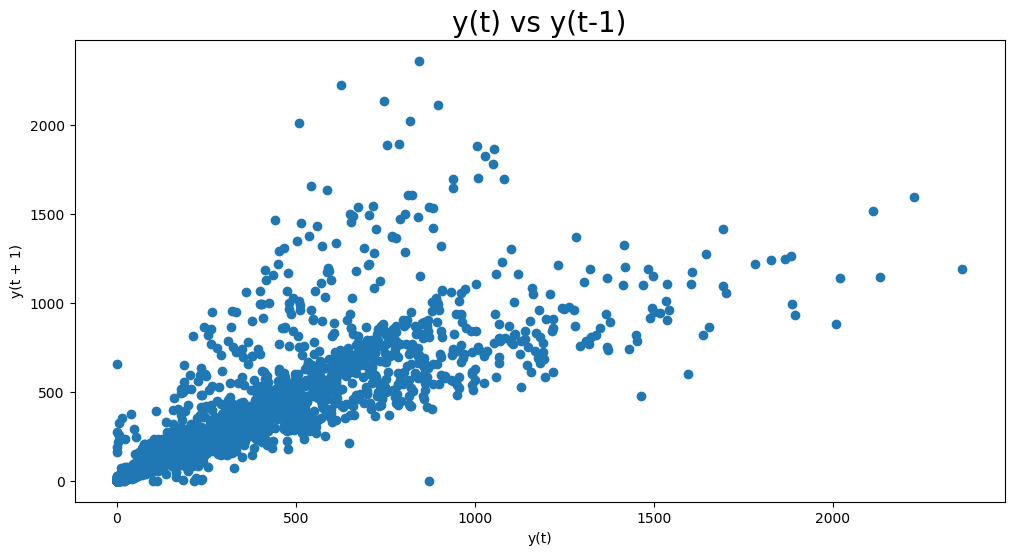

In [19]:
df_raw_daily = df_raw.groupby(pd.Grouper(freq = "d")).sum()["reviews"]

fig, ax = plt.subplots(figsize=(12,6))
from pandas.plotting import lag_plot

pd.plotting.lag_plot(df_raw_daily)
ax.set_title("y(t) vs y(t-1)", fontsize = 20)
plt.show()

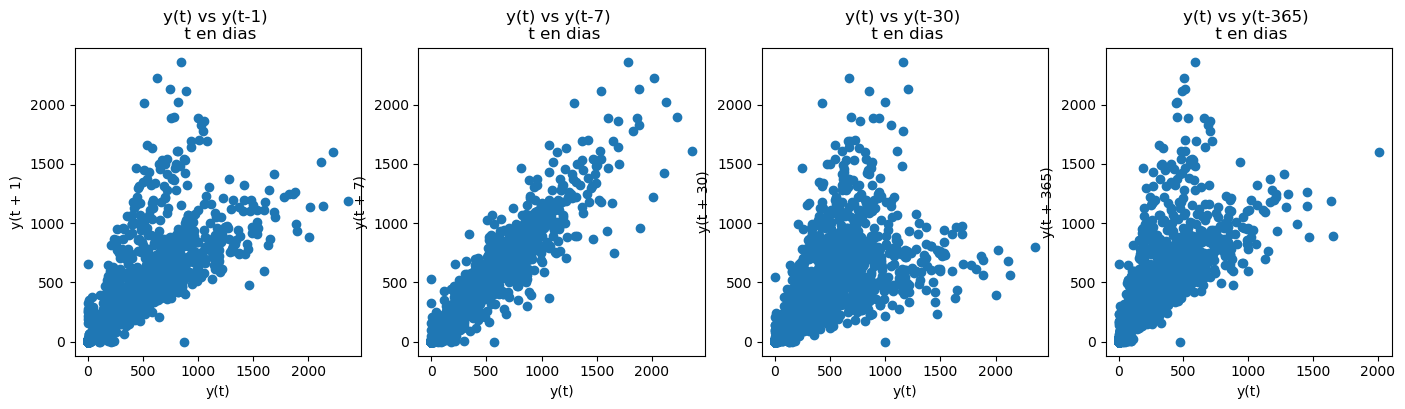

In [20]:
figs, axes = plt.subplots(1,4, figsize = (17,4))

lags = (1, 7, 30, 365)
df_lags = pd.Series(data = lags, index = np.arange(len(lags)), name = "lags")
for i, lag in df_lags.iteritems() :
    pd.plotting.lag_plot(df_raw_daily, lag = lag, ax = axes[i])
    axes[i].set_title("y(t) vs y(t-{}) \n t en dias".format(lag), fontsize  =12)

plt.show()

#### b) Autocorrelation Function (ACF) plot

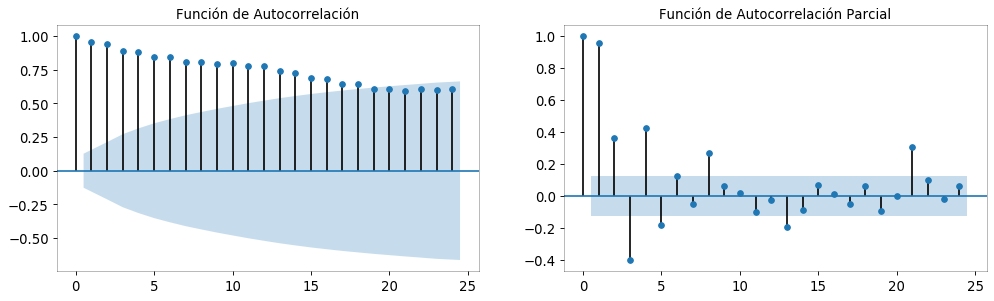

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



fig, axes = plt.subplots(1, 2,figsize=(15,4), dpi= 80)
plot_acf(df_raw_grouped_count_2weeks.values, ax=axes[0], alpha=0.05, title = "Autocorrelation Function (ACF)")
plot_pacf(df_raw_grouped_count_2weeks.values, ax=axes[1])

axes[0].spines["top"].set_alpha(.3); axes[1].spines["top"].set_alpha(.3)
axes[0].spines["bottom"].set_alpha(.3); axes[1].spines["bottom"].set_alpha(.3)
axes[0].spines["right"].set_alpha(.3); axes[1].spines["right"].set_alpha(.3)
axes[0].spines["left"].set_alpha(.3); axes[1].spines["left"].set_alpha(.3)


axes[0].tick_params(axis='both', labelsize=12)
axes[1].tick_params(axis='both', labelsize=12)

axes[0].set_title("Función de Autocorrelación")
axes[1].set_title("Función de Autocorrelación Parcial")
plt.savefig("/home/ignareyesa/Escritorio/TFG/Latex/Images/autocorrelationplots.png");

## 2.3. Descomposición <a class = "anchor" id = "Decomposition"> </a>

### 2.3.1. Descomposición Manual   <a class = "anchor" id = "MDecomposition"> </a>  
Comenzaremos por la descomposición más clásica de todas

1) Extraer la tendencia


In [22]:
def func_rolling_mean(series, window_size, center = True, mean = True, plot = False, create = True) :

    
    if mean :     #Se obtiene la media movil
        rolling_mean = series.rolling(window = window_size, center = center).mean()
    else :        #Se obtiene la media total
        rolling_mean = series.rolling(window = window_size, center = center).sum()
    
    
    
    
    if plot is True :
        fig, ax = plt.subplots(figsize=(12,6))
        plt.plot(series, color = "b", label = "Gráfica original")
        plt.plot(rolling_mean, color = "r", label = "Tendencia")
        #Decoration
        ax.set_xlabel("Fecha")
        ax.set_ylabel("Opiniones")
        ax.set_title("Extracción de la tendencia".format(
            center="Centred" if mean == True else "Simple", mean="Average" if mean == True else "Total", window_size = window_size,c="C" if mean == True else "S", 
                     m ="A" if mean == True else "T"), fontsize = 15)
        ax.legend(loc = "best", fontsize = 13)
        
    if create is True :  
        merge_rolling_mean = series.reset_index().merge(rolling_mean.reset_index(), on = "date").set_index("date").rename(columns = {"reviews_x" : "original",
                                                                                                                        "reviews_y" : "{window_size}-M{mean}".format(
                                                                                                                        window_size = window_size, 
                                                                                                                        mean="A" if mean == True else "T")})
        return merge_rolling_mean;

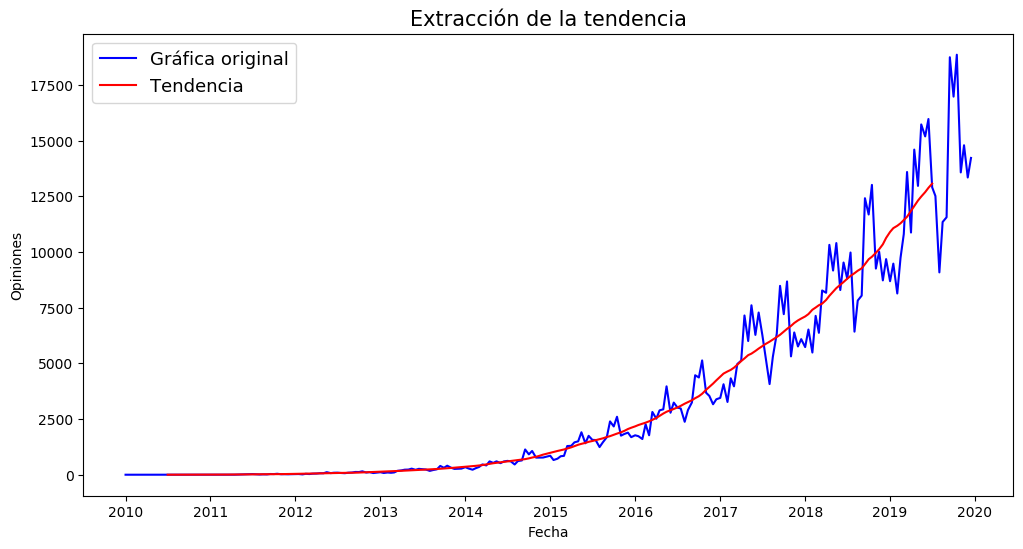

In [23]:
MA_24 = func_rolling_mean(df_raw_grouped_count_2weeks, 24, plot = True)

2) Eliminar la tendencia

In [24]:
#Modelo aditivo
def detrend_add(window_size, dataframe, plot = False, scale = False) :
    
    dataframe["detrend"] = dataframe.iloc[:,0] - dataframe.iloc[:,1]
    
    if plot is True :
        fig, ax = plt.subplots(figsize=(12,6))
        origin = plt.plot(dataframe.iloc[:,0], color = "b", label = "Gráfica original")
        rolling = plt.plot(dataframe.iloc[:,1], color = "r", label = "Tendencia")
        
                
        if scale is True :
            ax2 = ax.twinx()  # Axis gemelo
            yes_scale = ax2.plot(dataframe.iloc[:,2], color='tab:green', label = "Scaled De-Trend")
            ax2.set_ylabel("Scaled Reviews")
            ax2.grid(False)
            graphs = origin + rolling + yes_scale                    
        else : 
            no_scale = plt.plot(dataframe.iloc[:,2], color = "g", label = "Sin tendencia")
            graphs = origin + rolling + no_scale                    
        
        #Decoration    
        ax.set_xlabel("Fecha")
        ax.set_ylabel("Opiniones")
        ax.set_title("Descomposición Aditiva", fontsize = 15)
        labels = [label.get_label() for label in graphs] 
        ax.legend(graphs, labels, loc = "best", fontsize = 13)
        
        plt.show()
        
    return dataframe

#Modelo multiplicativo
def detrend_mult(window_size, dataframe, plot = False, scale = False) :
    
    dataframe["detrend"] = dataframe.iloc[:,0] / dataframe.iloc[:,1]
    
    if plot is True :
        fig, ax = plt.subplots(figsize=(12,6))
        origin = plt.plot(dataframe.iloc[:,0], color = "b", label = "Gráfica original")
        rolling = plt.plot(dataframe.iloc[:,1], color = "r", label = "Tendencia")
        
                
        if scale is True :
            ax2 = ax.twinx()  # Axis gemelo
            yes_scale = ax2.plot(dataframe.iloc[:,2], color='tab:green', label = "Scaled De-Trend")
            ax2.set_ylabel("Scaled Reviews")
            ax2.grid(False)
            graphs = origin + rolling + yes_scale                    
        else : 
            no_scale = plt.plot(dataframe.iloc[:,2], color = "g", label = "Sin tendencia")
            graphs = origin + rolling + no_scale                    
        
        #Decoration    
        ax.set_xlabel("Date")
        ax.set_ylabel("Reviews")
        ax.set_title("Descomposición Multiplicativa ", fontsize = 15)
        labels = [label.get_label() for label in graphs] 
        ax.legend(graphs, labels, loc = "best", fontsize = 13)
        ax.grid(alpha=.4)
        plt.show()
        
    return dataframe

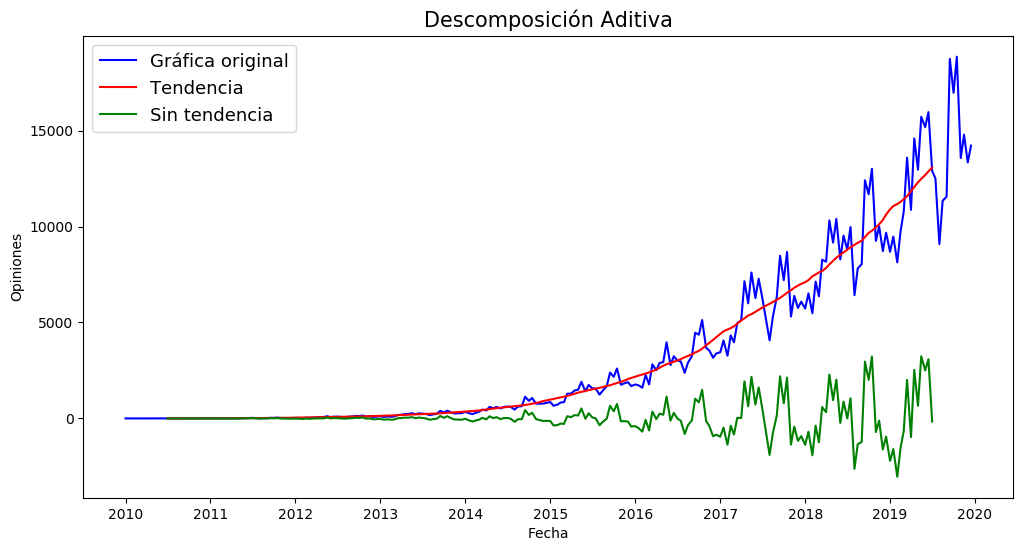

In [25]:
MA_24_a = detrend_add(24, MA_24, True)


3) Extraer el componente estacional

In [26]:
def seasonal_component(dataframe, individual_plot = True, total_plot = True) : 
    dataframe_copy = dataframe.copy()
    days = []
    months = []
    for i in dataframe.index :
        months.append(i.month)
        days.append(i.day)
    dataframe["month"] = months
    dataframe["day"] = days
    
    dataframe_season = dataframe.groupby(["month", "day"], as_index = False).mean()["detrend"]

    
    dataframe_seas_plot = dataframe_copy
    year = [] ;    month = [];    day = []
    for i in dataframe_seas_plot.index :
        year.append(i.year)
        month.append(i.strftime("%b"))
        day.append(np.str(i.day))

    dataframe_seas_plot["year"] = year;  dataframe_seas_plot["month"] = month;  dataframe_seas_plot["day"] = day
    dataframe_seas_plot["day-month"] = dataframe_seas_plot["day"] + "-" + dataframe_seas_plot["month"]
    years = dataframe_seas_plot['year'].unique()
        # Draw Plot
    if individual_plot is True :
        fig, ax = plt.subplots(figsize = (8,4))
        for i, y in enumerate(years):
            ax.plot("day-month", 'detrend', data=dataframe_seas_plot.loc[dataframe_seas_plot.year==y, :], label=y, alpha = 0.2)

        # Decoration
        ax.plot(dataframe_season, color = "k", label = "Componente estacional", alpha = 0.8)
        ax.set_xlim(-0, 23)
        ax.set_ylabel("Opiniones")
        plt.xticks(rotation = 45)
        plt.title("Componente estacional", fontsize=16)
        
        ax.legend(loc = 2)
        
        #Escalamos el axis gemelo
        ax2 = ax.twinx()  
        ax2.plot(dataframe_season, color = "r", label = "Componente estacional escalado")
        ax2.set_ylabel("Opiniones escaladas")
        
        ax2.legend(loc = 4)
                
          
    dataframe.drop(["month", "day"], axis = "columns", inplace = True)
    dataframe_season = pd.DataFrame(np.array([dataframe_season]*10).reshape(240,1), index = dataframe.index, columns = {"seasonality average"})
    dataframe_season = pd.merge(dataframe, dataframe_season, left_index=True, right_index=True)

    if total_plot is True :
        fig, ax = plt.subplots(figsize = (18,4))
        ax.plot(dataframe_season["seasonality average"])
        ax.set_ylabel("Opiniones")
        ax.set_xlabel("Fecha")
        ax.set_title("Componente estacional global", fontsize = "16")
        
        plt.show()
    
    return dataframe_season

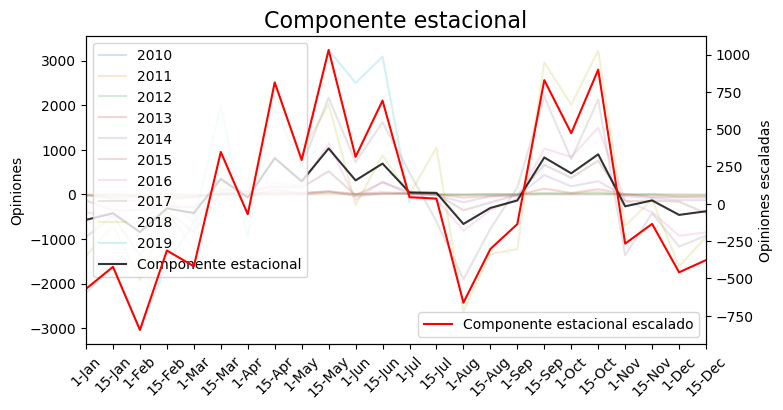

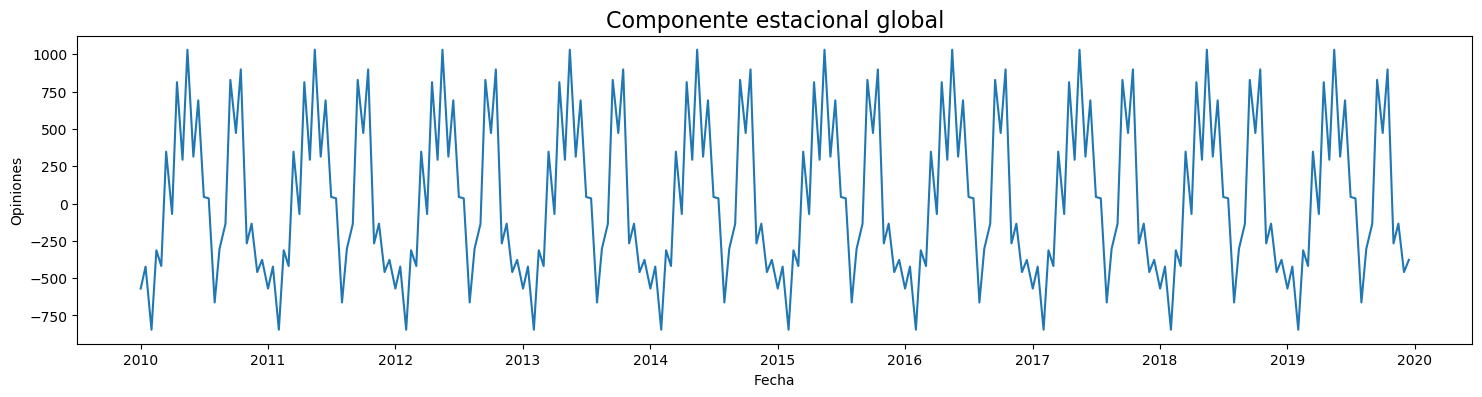

In [27]:
MA_24_a_se = seasonal_component(MA_24_a, True, True)

4) Residuos

In [28]:
def residuals_add(dataframe, plot = True, scatter = True) : 
    dataframe["residuals"] = dataframe.iloc[:,0] - dataframe.iloc[:,1] - dataframe.iloc[:,3]  
    
    if plot is True : 
        fig, ax = plt.subplots(figsize = (15,4))
        ax.plot(dataframe["residuals"])
        ax.set_ylabel("Opiniones")
        ax.set_xlabel("Fecha")
        ax.set_title("Residuos", fontsize = "16")
        plt.show()
        
    if scatter is True : 
        fig, ax = plt.subplots(figsize = (15,4))
        ax.scatter(dataframe.index, dataframe["residuals"])
        ax.set_ylabel("Opiniones")
        ax.set_xlabel("Fecha")
        ax.set_title("Residuos", fontsize = "16")
        plt.show()
    
    return dataframe

def residuals_mult(dataframe, plot = True, scatter = True) : 
    dataframe["residuals"] = dataframe.iloc[:,0] / (dataframe.iloc[:,1] * dataframe.iloc[:,3])
    
    if plot is True : 
        fig, ax = plt.subplots(figsize = (15,4))
        ax.plot(dataframe.index, dataframe["residuals"])
        ax.set_ylabel("Opiniones")
        ax.set_xlabel("Fecha")
        ax.set_title("Residuos", fontsize = "16")
        plt.show()
    
    if scatter is True : 
        fig, ax = plt.subplots(figsize = (15,4))
        ax.scatter(dataframe["residuals"])
        ax.set_ylabel("Opiniones")
        ax.set_xlabel("Fecha")
        ax.set_title("Residuos", fontsize = "16")
        plt.show()
    
    return dataframe

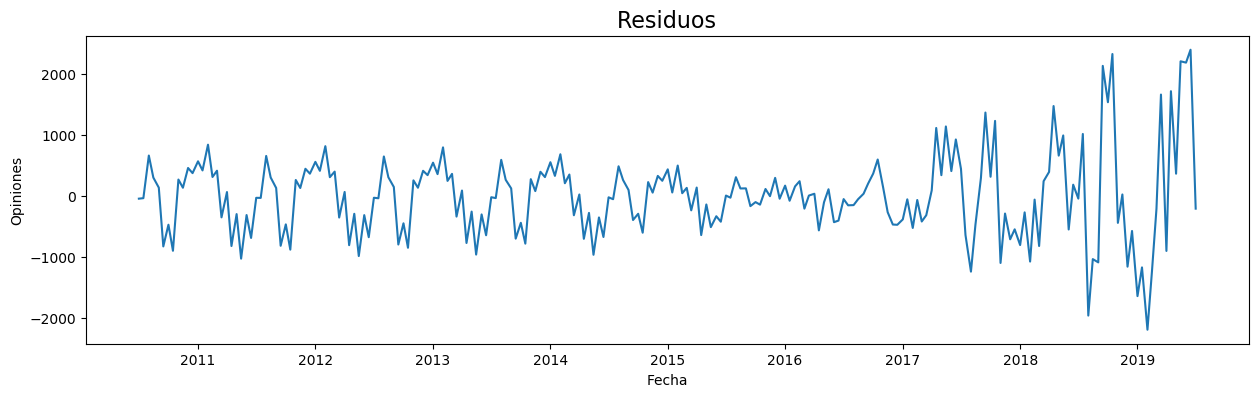

In [29]:
MA_24_a_se_r = residuals_add(MA_24_a_se, True, False)

In [30]:
def manual_decompose(dataframe, window_size) :
    fig, axes = plt.subplots(4,1, figsize=(11,7))
    figures = pd.Series(["original", "{}-MA".format(window_size), "seasonality average", "residuals"])
    for i, figure in figures.iteritems() : 
        axes[i].plot(dataframe[figure])
        axes[i].set_ylabel("{}".format(figure))
        axes[i].set_xlim(left = date1, right = date3)
        
    axes[len(figures) - 1].set_xlabel("Date")
    axes[0].set_title("Reviews")
    plt.show()

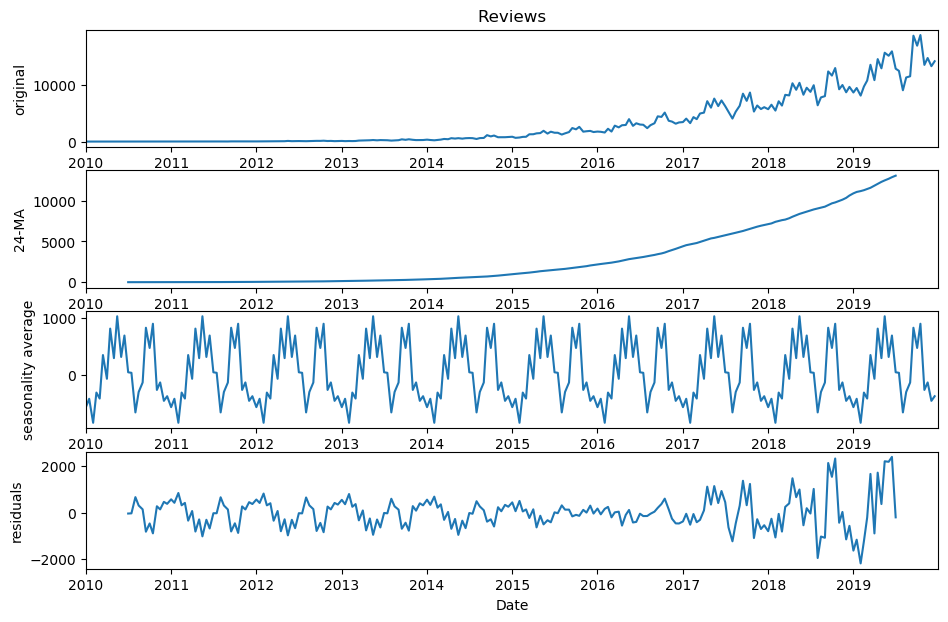

In [31]:
manual_decompose(MA_24_a_se_r, 24)

In [32]:
df_raw_grouped_count_2weeks.replace(0,1, inplace = True)

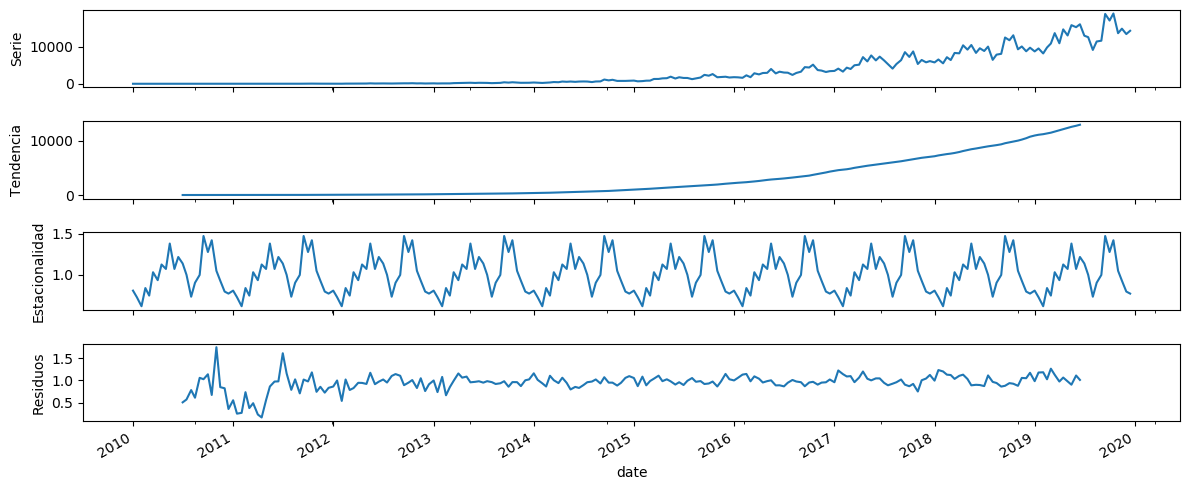

In [33]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(df_raw_grouped_count_2weeks, "mult", period = 24)

def plotseasonal(res, axes ):
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,5))
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Serie')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Tendencia')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Estacionalidad')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residuos')
    plt.tight_layout()
    plt.show()



plotseasonal(res, axes)

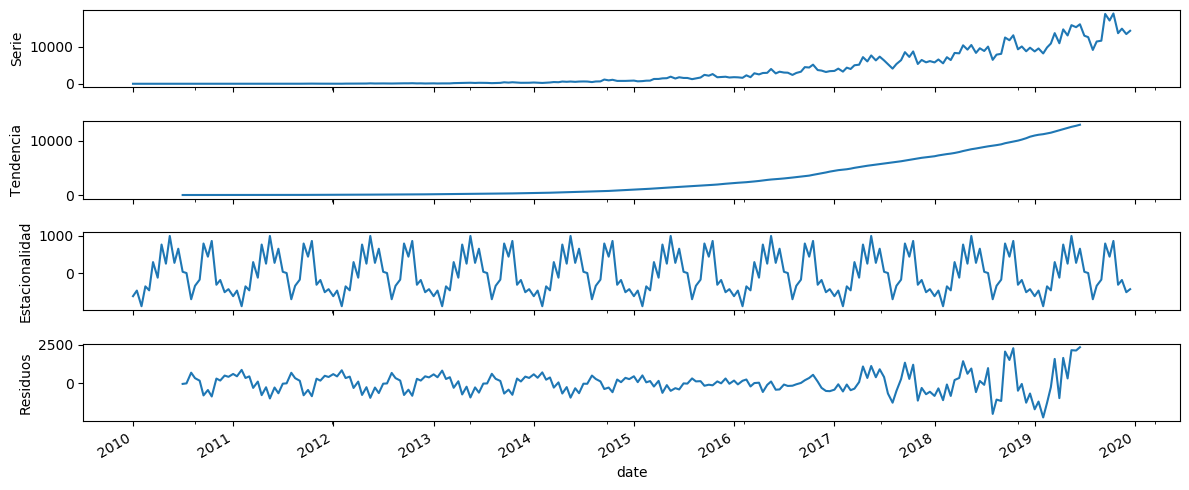

In [34]:
res = sm.tsa.seasonal_decompose(df_raw_grouped_count_2weeks, "add", period = 24)
plotseasonal(res, axes)

### 2.3.2. Descomposición STL

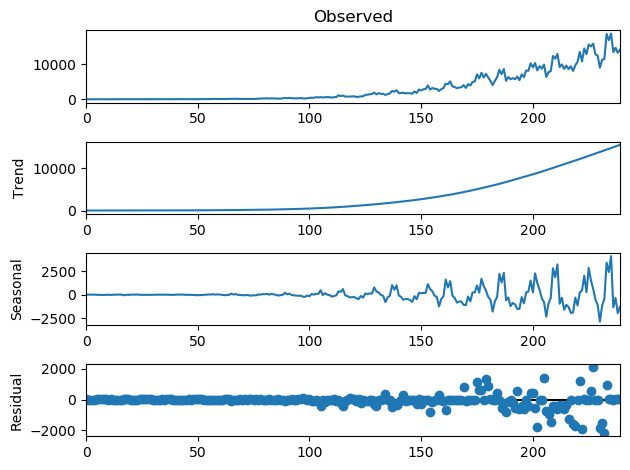

In [35]:
from statsmodels.tsa.seasonal import STL

stl = STL((df_raw_grouped_count_2weeks).values, period = 24, robust=True)
result_stl = stl.fit()
fig = result_stl.plot(weights = False)


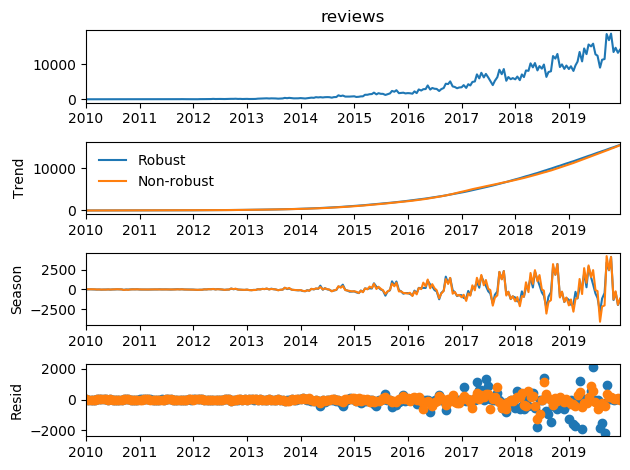

In [36]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)


stl = STL(df_raw_grouped_count_2weeks, period=24, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(df_raw_grouped_count_2weeks, period=24, robust=False).fit()
add_stl_plot(fig, res_non_robust, ['Robust','Non-robust'])

# 3. Estacionareidad 

## 3.1. Comprobar estacionareiedad

## Checking for stationarity - Code   <a class = "anchor" id = "Check_Stationary_Code"> </a> 

In [37]:
class StationarityTests:       
    
    def ADF_Test(self, timeseries, regression = "c", autolag = "AIC", printResults = True):
        from statsmodels.tsa.stattools import adfuller
        if autolag is None :
            autolag = None
        else :
            autolag = autolag.lower()
            
            #Dickey-Fuller test:
        if (regression.lower() in np.array(["ct", "c", "ctt", "nc"])) and (autolag in np.array(["aic", "bic", "t-stat", None])) :
                adfTest = adfuller(timeseries, autolag=autolag, regression = regression)
                if printResults:
                    dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic (TS)','P-Valor','# Nº Retardos','# Nº Observaciones'])
                    #Add Critical Values
                    for key,value in adfTest[4].items():
                        dfResults["Valor Crítico (CV) (%{})".format(key)] = value
                    dfResults["Solución"] = "Comparar TS y CV"
                    print("Prueba Dickey-Fuller Aumentada  ||| Regresión = {regression} || autolag = {autolag} ||| Resultados:".format(regression = regression, autolag = autolag))
                    print(dfResults)
                    
        elif (regression not in np.array(["ct", "c", "ctt", "nc"])) and (autolag in np.array(["AIC", "BIC", "t-stat", None])):
            print("{} no es un modelo de regresión válido para esta prueba".format(regression), 'try with: "c", "ct", "ctt" or "nc"')
            
        elif (regression in np.array(["ct", "c", "ctt", "nc"])) and (autolag not in np.array(["AIC", "BIC", "t-stat", None])):    
            print("{} no es un método válido para determinar el autolag".format(autolag), 'try with: "AIC", "BIC", "t-stat" or None')
        else :
            print("{} is not a valid regresssion model for ADF Test".format(regression), 'try with: "c", "ct", "ctt" or "nc"')
            print("{} is not a valid method to automatically determine the lag for ADF Test".format(autolag), 'try with: "AIC", "BIC", "t-stat" or None')
            
    def KPSS_Test(self, timeseries, regression = "c", printResults = True):
        from statsmodels.tsa.stattools import kpss
      
            
        #Dickey-Fuller test:
        if regression.lower() in np.array(["ct", "c"]) :
                kpssTest = kpss(timeseries, regression = regression)
                if printResults:
                    dfResults = pd.Series(kpssTest[0:3], index=['KPSS Test Statistic (TS)','P-Valor','Parámetro Retardo Truncado'])
                    #Add Critical Values
                    for key,value in kpssTest[3].items():
                        dfResults["Valor Críticoe (CV) (%{})".format(key)] = value
                    dfResults["Solución"] = "Comparar TS y CV"
                    print("Resultados Prueba KPSS: ||| regresión = {regression} ||| resultados:".format(regression = regression))
                    print(dfResults)
                    
        elif regression not in np.array(["ct", "c"]):
            print("{} is not a valid regresssion model for ADF Test".format(regression), 'try with: "c" or "ct"')
            

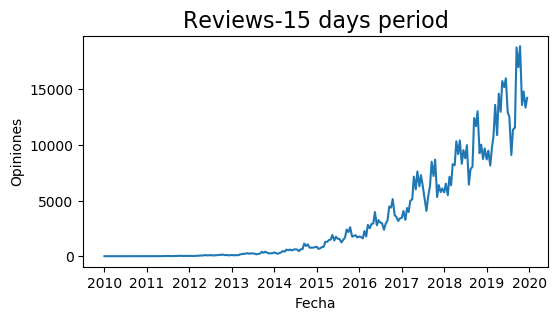

In [38]:
timeplot(df_raw_grouped_count_2weeks, "Reviews-15 days period",figsize=(6,3))

In [39]:
print(StationarityTests().ADF_Test(df_raw_grouped_count_2weeks, "c", "AIC"))
print("--------------------------------------------------------------------------")
print(StationarityTests().ADF_Test(df_raw_grouped_count_2weeks, "ctt", "AIC"))
print("--------------------------------------------------------------------------")
print(StationarityTests().KPSS_Test(df_raw_grouped_count_2weeks, "c"))
print("--------------------------------------------------------------------------")
print(StationarityTests().KPSS_Test(df_raw_grouped_count_2weeks, "ct"))
print("--------------------------------------------------------------------------")

Prueba Dickey-Fuller Aumentada  ||| Regresión = c || autolag = aic ||| Resultados:
ADF Test Statistic (TS)               3.57535
P-Valor                                     1
# Nº Retardos                              13
# Nº Observaciones                        226
Valor Crítico (CV) (%1%)             -3.45962
Valor Crítico (CV) (%5%)             -2.87442
Valor Crítico (CV) (%10%)            -2.57363
Solución                     Comparar TS y CV
dtype: object
None
--------------------------------------------------------------------------
Prueba Dickey-Fuller Aumentada  ||| Regresión = ctt || autolag = aic ||| Resultados:
ADF Test Statistic (TS)              -3.06962
P-Valor                              0.263085
# Nº Retardos                              12
# Nº Observaciones                        227
Valor Crítico (CV) (%1%)              -4.4229
Valor Crítico (CV) (%5%)             -3.85866
Valor Crítico (CV) (%10%)            -3.56949
Solución                     Comparar TS y CV
dt


| Test | Model | Comparison |  Result                     |
| -----|:-----:|:----------:|:---------------------------:|
| ADF  | *c*   | TS>CV      |$ H_{0} $: No-Estacionario   |
| ADF  | ctt   | TS>CV      |$ H_{0} $: No-Estacionario   |
| KPSS | *c*   | TS>CV      |$ H_{a} $: No-Estacionario   |
| KPSS | *ct*  | TS>CV      |$ H_{a} $: No-Estacionario   |

**Caso 1**: La serie no es estacionaria

## 3.3. Transformar serie No-Estacionaria en Estacionaria

### 3.3.1. Diferenciación

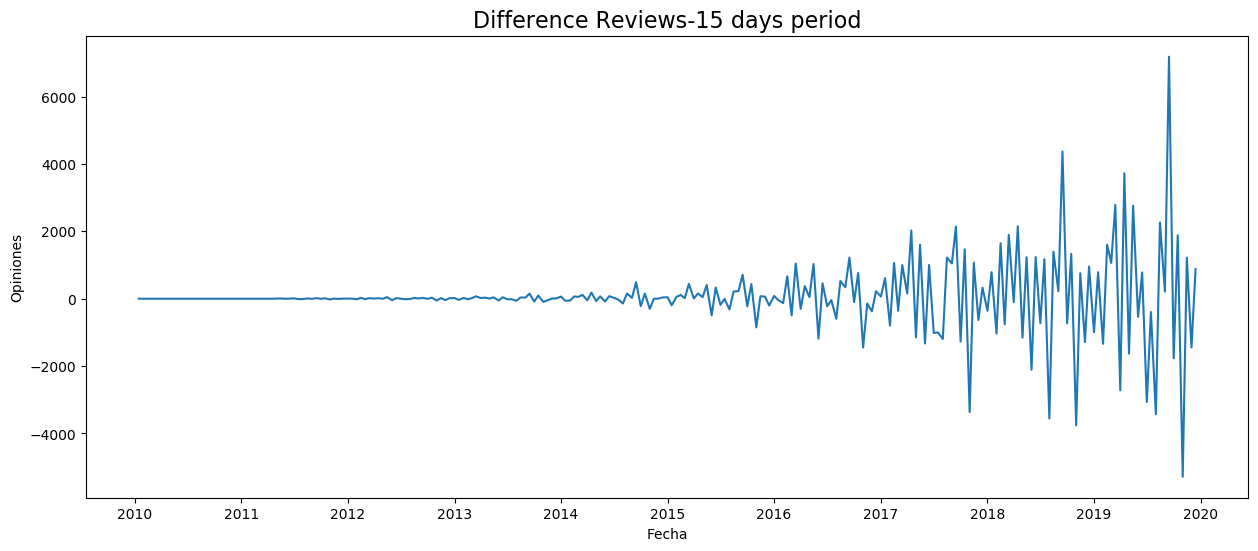

In [40]:
df_raw_grouped_count_2weeks_diff = df_raw_grouped_count_2weeks.diff().dropna()
timeplot(df_raw_grouped_count_2weeks_diff, "Difference Reviews-15 days period")

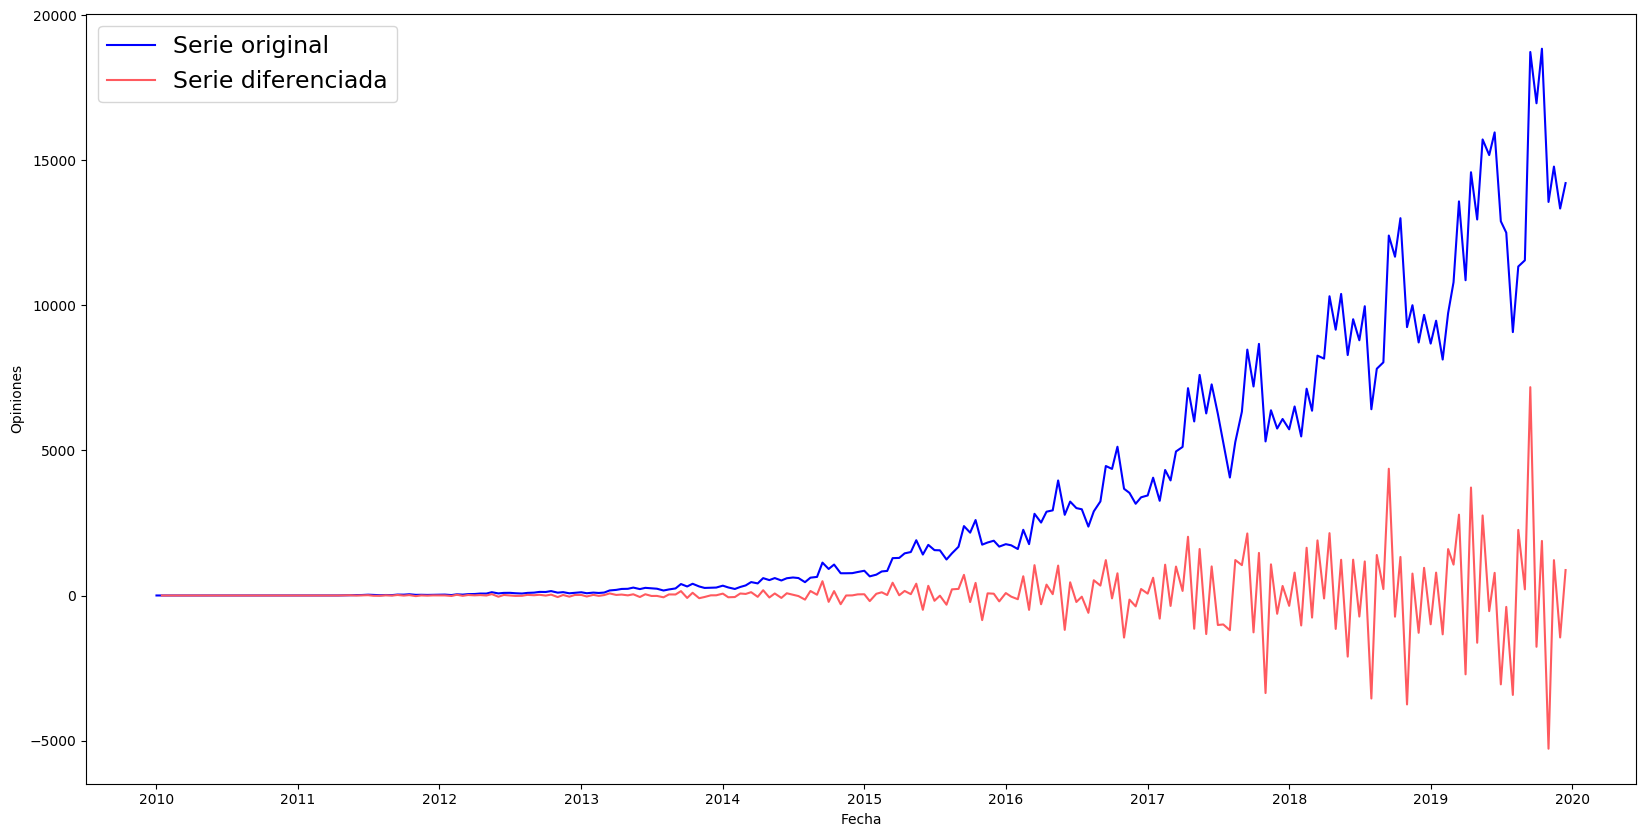

In [41]:
fig, ax = plt.subplots(figsize = (20,10))
plt.plot(df_raw_grouped_count_2weeks, label = "Serie original", c = "b")
plt.plot(df_raw_grouped_count_2weeks_diff, label = "Serie diferenciada", c = "#FF5A5F")
plt.xlabel("Fecha")
plt.ylabel("Opiniones")
plt.legend(prop={'size': 17});


In [42]:
print(StationarityTests().ADF_Test(df_raw_grouped_count_2weeks_diff.dropna(), "c", "AIC"))
print("--------------------------------------------------------------------------")
print(StationarityTests().KPSS_Test(df_raw_grouped_count_2weeks_diff.dropna(), "c", "AIC"))

Prueba Dickey-Fuller Aumentada  ||| Regresión = c || autolag = aic ||| Resultados:
ADF Test Statistic (TS)              -5.23614
P-Valor                           7.41506e-06
# Nº Retardos                              11
# Nº Observaciones                        227
Valor Crítico (CV) (%1%)             -3.45949
Valor Crítico (CV) (%5%)             -2.87436
Valor Crítico (CV) (%10%)             -2.5736
Solución                     Comparar TS y CV
dtype: object
None
--------------------------------------------------------------------------
Resultados Prueba KPSS: ||| regresión = c ||| resultados:
KPSS Test Statistic (TS)               0.434629
P-Valor                               0.0622288
Parámetro Retardo Truncado                   15
Valor Críticoe (CV) (%10%)                0.347
Valor Críticoe (CV) (%5%)                 0.463
Valor Críticoe (CV) (%2.5%)               0.574
Valor Críticoe (CV) (%1%)                 0.739
Solución                       Comparar TS y CV
dtype: object

| Test | Model | Comparison |  Result                                    |
| -----|:-----:|:----------:|:-----------------------:                   |
| ADF  | *c*   | TS<CV      |$ H_{a} $: Esracionaria                     |
| KPSS | *c*   | TS<CV      |$ H_{0} $: Estacionaria alrededor de nivel  |

**Case 2**: La serie es Estacionaria

### 3.3.2. Diferencia estacional

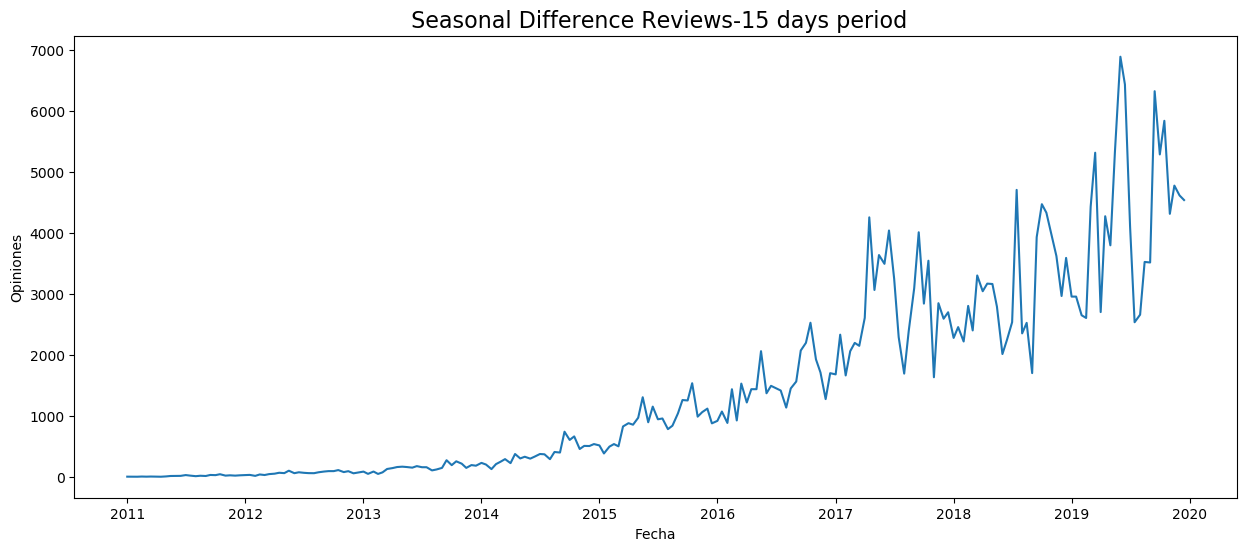

In [43]:
df_raw_grouped_count_2weeks_diff_seas = df_raw_grouped_count_2weeks.diff(periods = 24).dropna()
timeplot(df_raw_grouped_count_2weeks_diff_seas, " Seasonal Difference Reviews-15 days period")

- Lectura Recomendada

[Machine Learning Mastery](https://machinelearningmastery.com/time-series-data-stationary-python/) <br>
[Analytics Vidhya](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/)<br>
[Insightsbot](http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/)<br>
[Medium article](https://medium.com/bluekiri/simple-stationarity-tests-on-time-series-ad227e2e6d48)

# 4. Predicción

In [44]:
# Importamos las medidas de precisión del modelo

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

def root_mean_squared_error(y_true, y_pred) :     #RMSE
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return rmse

def mean_absolute_percentage_error(y_true, y_pred) :  #MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

## 4.2. Datos de Entrenamiento y Validación

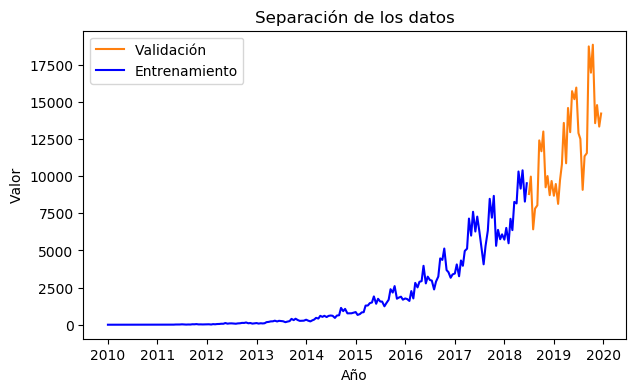

In [45]:
y_train, y_test = np.split(df_raw_grouped_count_2weeks, indices_or_sections = [int(.85 *len(df_raw_grouped_count_2weeks))]) 
fig, ax = plt.subplots(figsize = (7,4))
plt.plot(y_test, c = "tab:orange", label = "Validación")
plt.plot(y_train, c = "b", label = "Entrenamiento")
plt.title("Separación de los datos")
plt.xlabel("Año")
plt.ylabel("Valor")
plt.legend()
plt.grid(False)
plt.show()

In [46]:
def methods_plot(forecast_series, train_set = y_train, test_set = y_test) :
    fig, ax = plt.subplots(figsize = (11,6))
    plt.plot(train_set, color = "b", label = "Train")
    plt.plot(test_set, color = "tab:orange", label = "Test")
    plt.plot(forecast_series, color = "tab:green", label = forecast_series.name)
    plt.legend(fontsize = 13)
    plt.title((forecast_series.name + " Method"), fontsize = 17)
    plt.show()

## 4.3.Métodos de predicción simples




### 4.3.1. Método Naïve

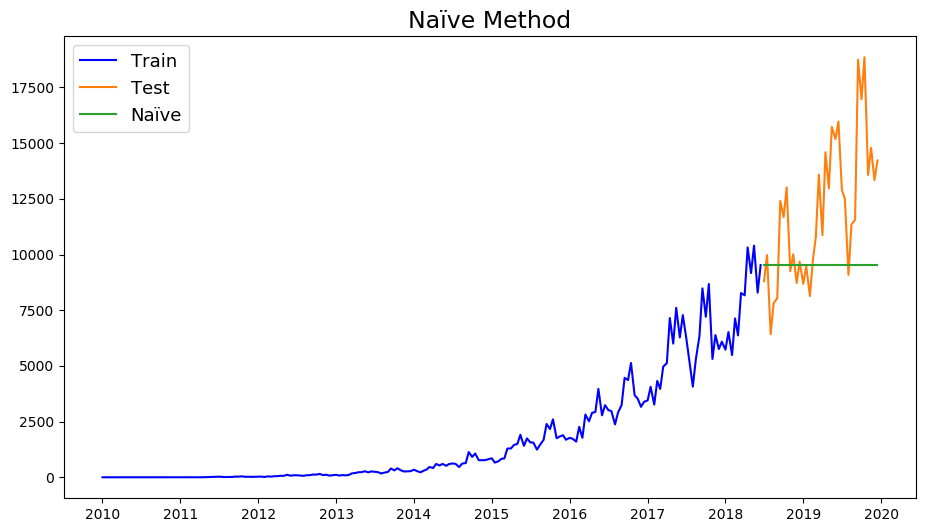

In [47]:
y_pred_naive = pd.Series(np.full(len(y_test), y_train[-1:]), index = y_test.index, name = "Naïve")
methods_plot(y_pred_naive)

### 4.3.2. Método de la media

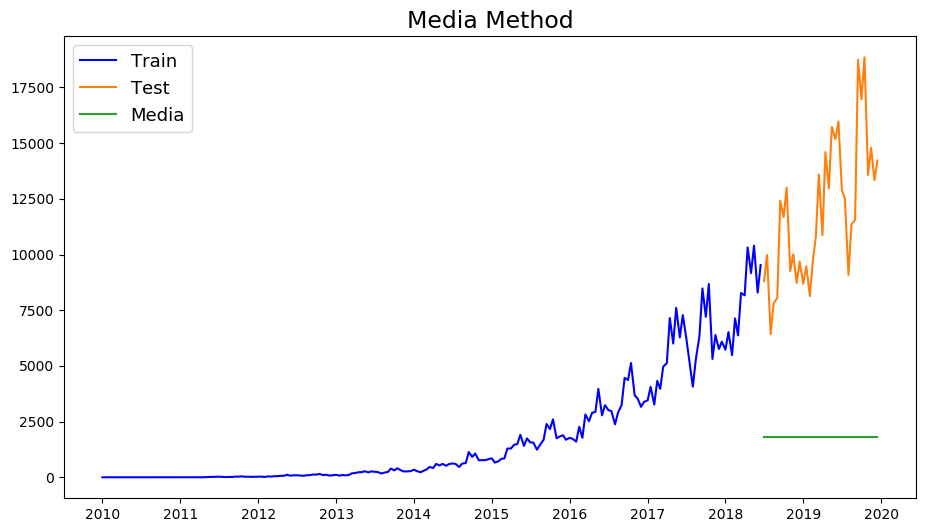

In [48]:
y_pred_average = pd.Series(np.mean(y_train), index = y_test.index, name = "Media")
methods_plot(y_pred_average)

### 4.3.3. Método Naïve Estacional

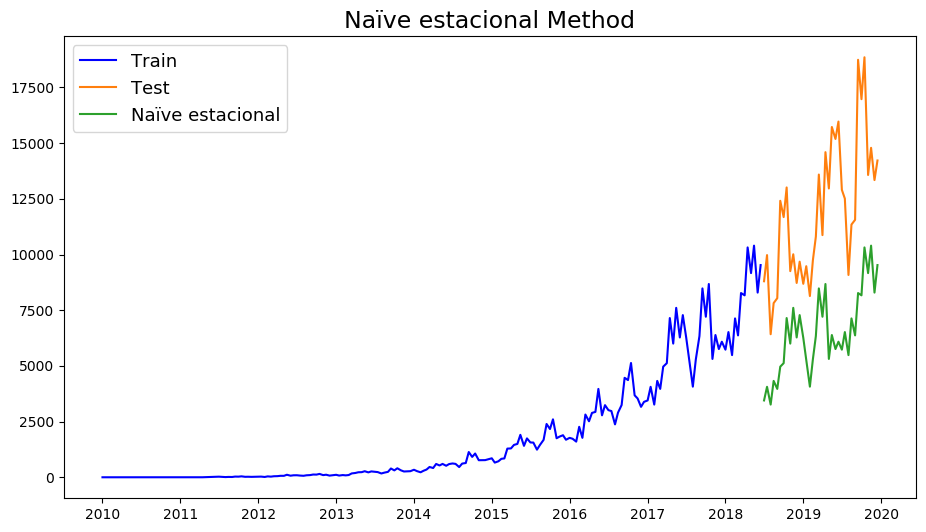

In [49]:
y_pred_s_naive = pd.Series(y_train[-len(y_test):].values, index = y_test.index, name = "Naïve estacional")
methods_plot(y_pred_s_naive)

### 4.3.4. Método de la deriva

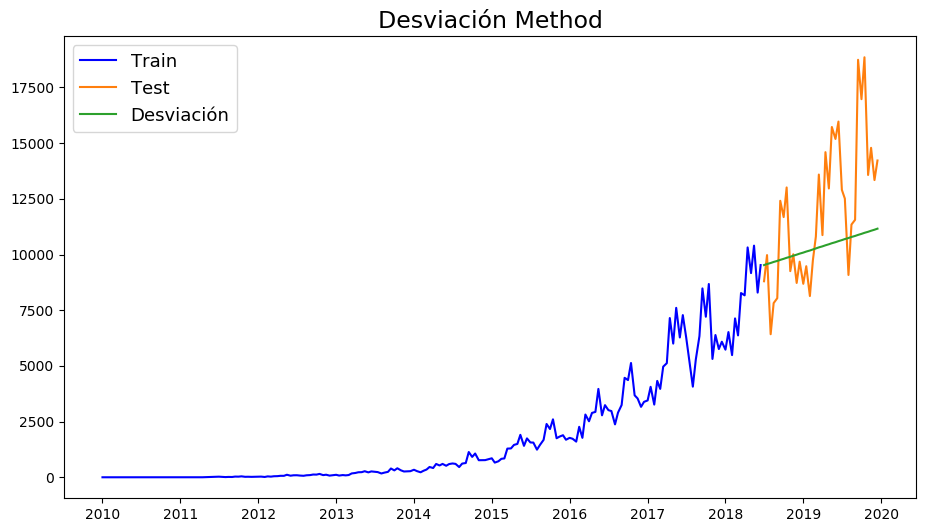

In [50]:
m = np.array((y_train[-1:] - y_train[0])/len(y_train-1))
h = np.arange(len(y_test))
y_pred_drift = pd.Series(np.array(y_train[-1:]) + m*h, index = y_test.index, name = "Desviación")
methods_plot(y_pred_drift)

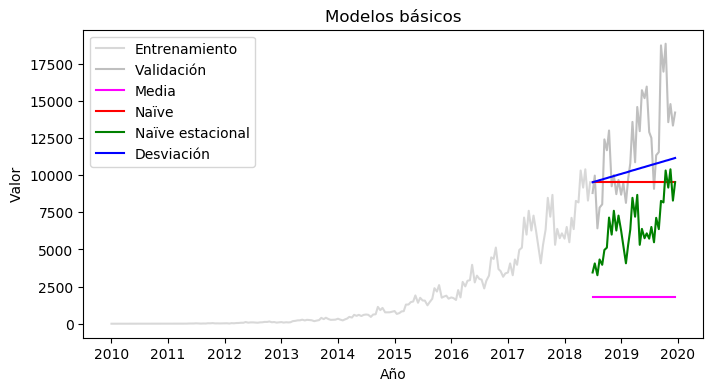

In [51]:
fig, ax = plt.subplots(figsize = (8,4))
plt.plot(y_train, c = "grey", label = "Entrenamiento", alpha = 0.3)
plt.plot(y_test, c = "grey", label = "Validación", alpha = 0.5)
plt.plot(y_pred_average, label = "Media", color = "magenta")
plt.plot(y_pred_naive, label = "Naïve", color = "red")
plt.plot(y_pred_s_naive, label = "Naïve estacional", color = "green")
plt.plot(y_pred_drift, label = "Desviación", color = "b")
plt.title("Modelos básicos")
plt.xlabel("Año")
plt.ylabel("Valor")
plt.legend()

plt.show()

#### Comparación de los modelos

In [52]:
series = [y_pred_naive,  y_pred_average, y_pred_s_naive, y_pred_drift] #y_pred_lr]
accuracy_comparison = pd.DataFrame()
MAE = [] ; MSE = [] ; MAPE = [] ; R_cuadrado = [] ; MedAE = [] ; MSLE = []; RMSE = []
index = []
for i in series :
    MAE.append(mean_absolute_error(y_test, i.values))
    RMSE.append(root_mean_squared_error(y_test, i.values))
    MedAE.append(median_absolute_error(y_test, i.values))
    MSE.append(mean_squared_error(y_test, i.values))
    MAPE.append(mean_absolute_percentage_error(y_test, i.values))
    MSLE.append(mean_squared_log_error(y_test, i.values))
    R_cuadrado.append(r2_score(y_test, i.values))  
    index.append(i.name)
accuracy_comparison["MAE"] = MAE ; accuracy_comparison["RMSE"] = RMSE ;accuracy_comparison["MedAE"] = MedAE; accuracy_comparison["MSE"] = MSE; accuracy_comparison["MAPE"] = MAPE; accuracy_comparison["MSLE"] = MSLE; accuracy_comparison["R_cuadrado"] = R_cuadrado
accuracy_comparison.index = index 

def highlight_min(s):
    '''
    highlight the minimum in a Series in green.
    '''
    if s.name == "R_cuadrado" : 
        is_max = s == s.max()
        return ['background-color: green' if v else '' for v in is_max]
    else : 
        is_min = s == s.min()
        return ['background-color: green' if v else '' for v in is_min]


In [53]:
accuracy_comparison.style.apply(highlight_min)

## 4.4. Suaviazado Exponencial

### 4.4.1. Suaviazado Exponencial Simple (SES) 

In [54]:
def SES_smoothing_parameter(y_train, y_test) :
 
    from statsmodels.tsa.api import SimpleExpSmoothing
    alphas = np.linspace(0,1,101)
    RMSE_train = []
    RMSE_test = []
    for alpha in alphas :
        fit_SES = SimpleExpSmoothing(y_train).fit(smoothing_level=alpha, optimized=False)
        train_SES = fit_SES.predict(0)
        test_SES = fit_SES.forecast(len(y_test))
        RMSE_train.append(root_mean_squared_error(y_train, train_SES))
        RMSE_test.append(root_mean_squared_error(y_test, test_SES))

    RMSE_train = pd.Series(RMSE_train, index = alphas, name = "Entrenamiento")
    RMSE_test= pd.Series(RMSE_test, index = alphas, name = "Validación")
    
#Mejor combinación de los parámetros de suavizado:
  #Matemáticamente
    min_value_n = RMSE_test.values[0]
    min_value_v = RMSE_train.values[0]
    min_diff = np.abs(min_value_n - min_value_v)
    for k,v in RMSE_train.iteritems() :
        for p,n in RMSE_test.iteritems():
            if k == p:
                if (min_value_n > n) and  (min_value_v > v) :
                    min_value_n = n
                    min_value_v = v
                    min_diff = np.abs(min_value_n - min_value_v)
                elif (min_value_n < n) and (min_value_v > v) and (min_diff > np.abs(n - v)) :
                    min_value_n = min_value_n
                    min_value_v = v
                    min_diff = np.abs(min_value_n - min_value_v)
                    
                elif (min_value_n > n) and (min_value_v < v) and (min_diff > np.abs(n - v)) :
                    min_value_v = min_value_v
                    min_value_n = n
                    min_diff = np.abs(min_value_n - min_value_v)

    train_adjusted = RMSE_train.idxmin()
    test_adjusted = RMSE_test.idxmin()
    train_test_adjusted = (RMSE_test[RMSE_test==min_value_n].index.values[0])

  #Gráficamente
    fig, ax = plt.subplots(figsize = (10,6))
    RMSE_train.plot(color = "b")
    RMSE_test.plot(color = "tab:orange")
    plt.scatter((RMSE_train[RMSE_train == RMSE_train.min()]).index,(RMSE_train[RMSE_train == RMSE_train.min()]).values, color = "k", marker = "o")
    plt.scatter((RMSE_test[RMSE_test == RMSE_test.min()]).index,(RMSE_test[RMSE_test == RMSE_test.min()]).values, color = "k", marker = "o")
    plt.xlabel("alpha", fontsize = 12)
    plt.ylabel("RMSE", fontsize = 12)
    plt.title("Optimización Suavizado Exponencial Simple\n Escoge el mejor valor de alpha ", fontsize = 16)
    plt.xticks(np.linspace(0,1,11))
    plt.xlim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("Mejor parámetro (Entrenamiento): \n\t\t\t\t alpha: {}".format(train_adjusted))
    print("Mejor parámetro (Validación): \n\t\t\t\t alpha: {}".format(test_adjusted))
    print("Mejor parámetro combinando entrenamiento y validación: \n\t\t\t\t alpha: {}".format(train_test_adjusted))
    
    return train_adjusted, test_adjusted, train_test_adjusted

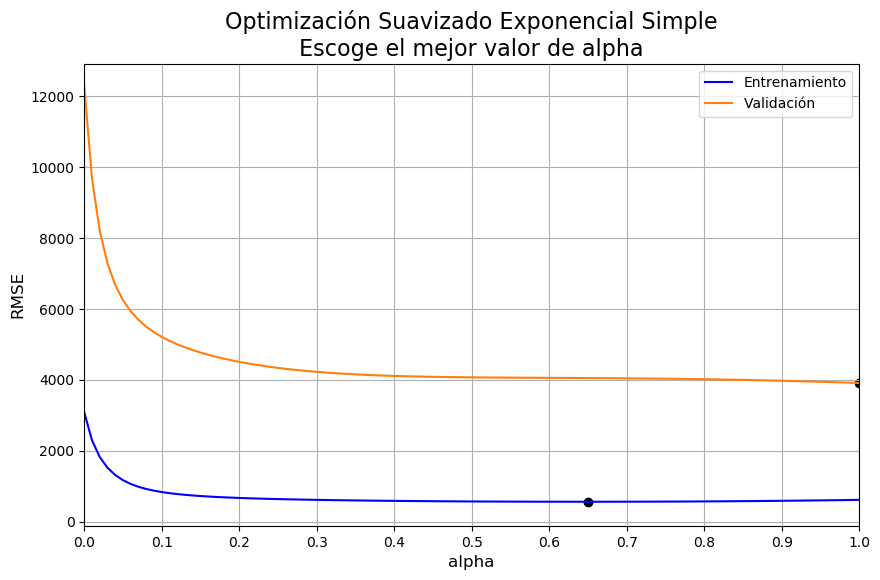

Mejor parámetro (Entrenamiento): 
				 alpha: 0.65
Mejor parámetro (Validación): 
				 alpha: 1.0
Mejor parámetro combinando entrenamiento y validación: 
				 alpha: 1.0


In [55]:
SES_smoothing_parameter = SES_smoothing_parameter(y_train = y_train, y_test = y_test) 


In [56]:
def simple_exponential_smoothing(y_train, y_test, alpha):
    
    from statsmodels.tsa.api import SimpleExpSmoothing
    model = SimpleExpSmoothing(y_train)
     
    fit1 = model.fit(smoothing_level = alpha[0])
    fit2 = model.fit(smoothing_level = alpha[1])
    fit3 = model.fit(smoothing_level = alpha[2])

    fig, ax = plt.subplots(figsize=(9, 4))

    ax.plot(y_train, label = "Entrenamiento", color = "grey", alpha = 0.3)
    ax.plot(y_test, label = "Validación", color = "grey", alpha = 0.5)
    for f, c in zip((fit1, fit2, fit3),('g','r','m')) :
        ax.plot(f.fittedvalues, color = c)
        ax.plot(f.forecast(len(y_test)), label=("alpha="+str(f.params['smoothing_level'])[:4] +
                                                "\nRMSE Entrenamiento = " + str(root_mean_squared_error(y_train, f.fittedvalues))+ 
                                                "\nRMSE Validación = " + str(root_mean_squared_error(y_test, f.forecast(len(y_test)))) + "\n"),
                color=c)

    plt.title("Suavizado Exponencial Simple", fontsize = 12)
    plt.xlabel("Año")
    plt.ylabel("Valor")
    ax.legend(loc='center left', prop={'size': 8});
    
    return pd.Series(fit3.forecast(len(y_test)), name = "Suav Exp Simpl")

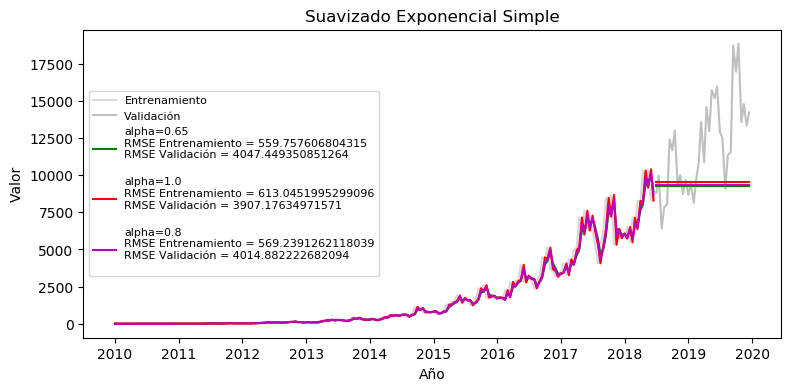

In [57]:
y_pred_SES = simple_exponential_smoothing(y_train = y_train, y_test = y_test, alpha = [SES_smoothing_parameter[0], SES_smoothing_parameter[1], 0.8])

Si $ \alpha=1 $ es igual que [Naïve Method](#NM) <br>

### 4.4.2. Métodos con tendencia

#### 4.4.2.1. Método Holt

In [58]:
def DES_smoothing_parameter(y_train, y_test, damped = False) :

    from statsmodels.tsa.api import Holt
    alphas = np.linspace(0,1,101)
    betas = np.linspace(0,1,11)
    RMSE_train = []
    RMSE_test = []
    
    if damped == True :
        damped = True
    else :
        damped = False
    
    model = Holt(y_train, damped=damped)
    for alpha in alphas :
        for beta in betas : 
            fit_SES = model.fit(smoothing_level=alpha, smoothing_slope=beta)
            train_SES = fit_SES.fittedvalues
            test_SES = fit_SES.forecast(len(y_test))
            RMSE_train.append(root_mean_squared_error(y_train, train_SES))
            RMSE_test.append(root_mean_squared_error(y_test, test_SES))

    RMSE_train = pd.DataFrame(np.array_split(RMSE_train, len(alphas)), index = alphas, columns = betas).stack()
    RMSE_train.index.names = ["alpha", "beta"]
    RMSE_test = pd.DataFrame(np.array_split(RMSE_test, len(alphas)), index = alphas, columns = betas).stack()
    RMSE_test.index.names = ["alpha", "beta"]

#Mejor combinación de los parámetros de suavizado:
  #Matemáticamente
    min_value_n = RMSE_test.values[0]
    min_value_v = RMSE_train.values[0]
    min_diff = np.abs(min_value_n - min_value_v)
    for k,v in RMSE_train.iteritems() :
        for p,n in RMSE_test.iteritems():
            if k == p:
                if (min_value_n > n) and  (min_value_v > v) :
                    min_value_n = n
                    min_value_v = v
                    min_diff = np.abs(min_value_n - min_value_v)
                elif (min_value_n < n) and (min_value_v > v) and (min_diff > np.abs(n - v)) :
                    min_value_n = min_value_n
                    min_value_v = v
                    min_diff = np.abs(min_value_n - min_value_v)
                    
                elif (min_value_n > n) and (min_value_v < v) and (min_diff > np.abs(n - v)) :
                    min_value_v = min_value_v
                    min_value_n = n
                    min_diff = np.abs(min_value_n - min_value_v)

    train_adjusted = RMSE_train.idxmin()
    test_adjusted = RMSE_test.idxmin()
    train_test_adjusted = (RMSE_test[RMSE_test==min_value_n].index.values[0])
    
  #Gráficamente
    sns.set_palette(sns.color_palette("hls"))      #SET COLOR

    fig, ax = plt.subplots(figsize=(14,6))
    for i in betas : 
        plt.plot(RMSE_train[:,i], label = np.round(i,2))

    plt.scatter(train_adjusted[0], RMSE_train.min(), marker = "o", color = "k")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "beta: ")
    ax.set_xlabel("alpha", fontsize = 12)
    ax.set_ylabel("RMSE", fontsize = 12)
    ax.set_ylim(RMSE_train.min()-100,RMSE_train.mean())
    ax.set_xlim(-0.01,1)
    ax.set_xticks(np.linspace(0,1,11))
    ax.set_title("Optimización Suavizado Exponencial con Tendencia (Entrenamiento)\n Selecciona los mejores valores para alpha y beta", fontsize = 16)


    fig, ax = plt.subplots(figsize=(14,6))

    for i in betas :
        RMSE_test[:,i].plot(label = np.round(i,2))

    plt.scatter(test_adjusted[0], RMSE_test.min(), marker = "o", color = "k")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "beta: ")
    ax.set_ylim(RMSE_test.min()-100,RMSE_test.mean())
    ax.set_xlim(-0.01,1)
    ax.set_xticks(np.linspace(0,1,11))
    ax.set_title("Optimización Suavizado Exponencial con Tendencia (Validación)\n Selecciona los mejores valores para alpha y beta", fontsize = 16)
    ax.set_xlabel("alpha", fontsize = 12)
    ax.set_ylabel("RMSE", fontsize = 12)



    fig, ax = plt.subplots(figsize=(14,6))
    plt.plot(RMSE_test[:,train_adjusted[1]])
    plt.scatter(test_adjusted[0], RMSE_test.min(), marker = "o", color = "k")
    ax.set_ylim(RMSE_test.min()-100,RMSE_test.mean())
    ax.set_xlim(-0.01,1)
    ax.set_xticks(np.linspace(0,1,11))
    ax.set_title("Zoom of Best beta curve for the Train Data \n beta = {}".format(RMSE_train.idxmin()[1]), fontsize = 16)
    ax.set_xlabel("alpha", fontsize = 12)
    ax.set_ylabel("RMSE", fontsize = 12)
    
    

    plt.show()
    
    print("Mejores parámetros (Entrenamiento): \n\t\t\t\t alpha: {}\n\t\t\t\t beta:  {}".format(train_adjusted[0], train_adjusted[1]))
    print("Mejores parámetros (Validación): \n\t\t\t\t alpha: {}\n\t\t\t\t beta:  {}".format(test_adjusted[0], test_adjusted[1]))
    print("Mejores parámetros combinando Entrenamiento y Validación: \n\t\t\t\t alpha: {}\n\t\t\t\t beta:  {}".format(train_test_adjusted[0], train_test_adjusted[1]))
    
    return train_adjusted, test_adjusted, train_test_adjusted

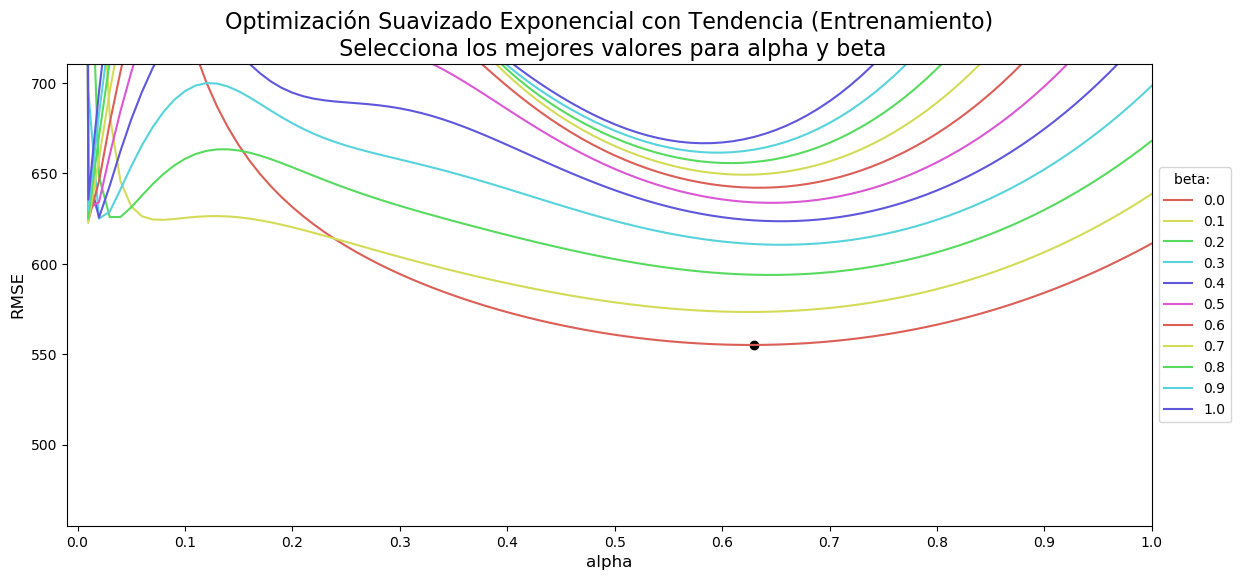

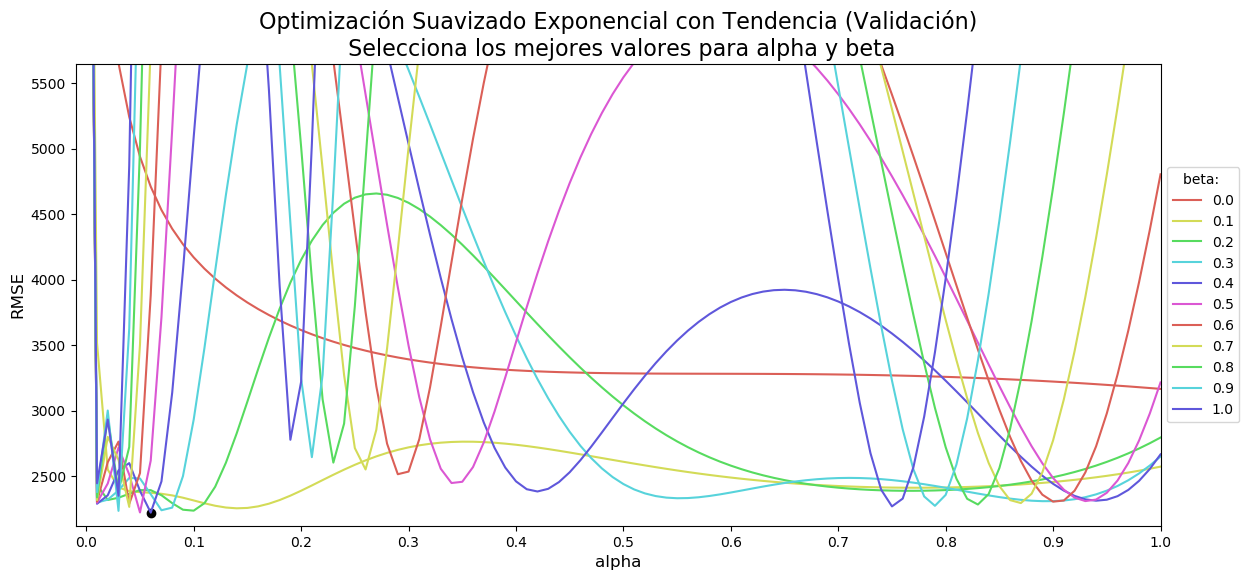

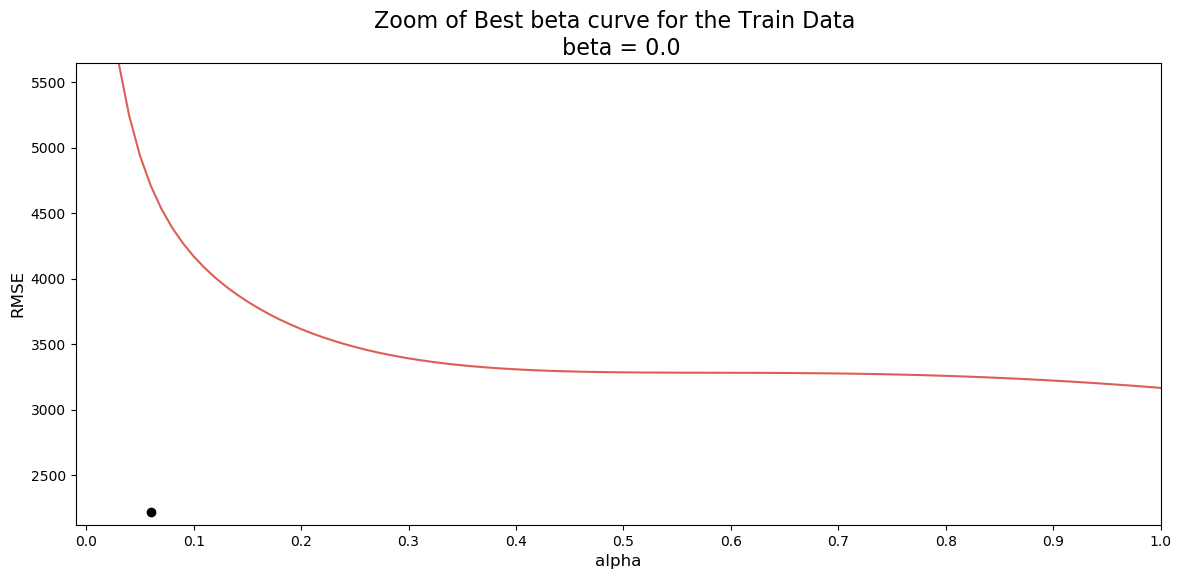

Mejores parámetros (Entrenamiento): 
				 alpha: 0.63
				 beta:  0.0
Mejores parámetros (Validación): 
				 alpha: 0.06
				 beta:  0.4
Mejores parámetros combinando Entrenamiento y Validación: 
				 alpha: 0.06
				 beta:  0.4


In [59]:
DES_smoothing_parameter = DES_smoothing_parameter(y_train = y_train, y_test = y_test, damped = False)

In [60]:
def double_exponential_smoothing(y_train, y_test, alpha, beta, damped = False) :
    
    from statsmodels.tsa.api import Holt
    model = Holt(y_train, damped = damped)
    fit1 = model.fit(smoothing_level = alpha[0], smoothing_slope = beta[0])
    fit2 = model.fit(smoothing_level = alpha[1], smoothing_slope = beta[1])
    fit3 = model.fit(smoothing_level = alpha[2], smoothing_slope = beta[2])

    fig, ax = plt.subplots(figsize=(9, 4))

    ax.plot(y_train.replace(0,1), label = "Entrenamiento", color = "grey", alpha = 0.3)
    ax.plot(y_test, label = "Validación", color = "grey", alpha = 0.5)
    for f, c in zip((fit1, fit2, fit3),('g','r','m')) :
        ax.plot(f.fittedvalues, color = c)
        ax.plot(f.forecast(len(y_test)), label=("alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4] +
                                                "\nRMSE Entrenamiento = " + str(root_mean_squared_error(y_train, f.fittedvalues))+ 
                                                "\nRMSE Validación = " + str(root_mean_squared_error(y_test, f.forecast(len(y_test)))) + "\n"),
                color=c)

    plt.title("Suavizado Exponencial con Tendencia")
    plt.xlabel("Año")
    plt.ylabel("Valor")
    ax.legend(loc='center left', prop={'size': 8});
    
    return pd.Series(fit3.forecast(len(y_test)), name = "Suav Exp Tend")

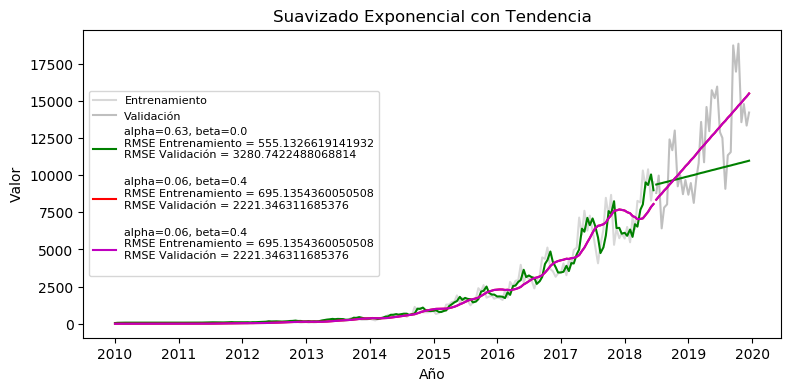

In [61]:
y_pred_DES = double_exponential_smoothing(y_train = y_train, y_test = y_test, 
                                          alpha = [DES_smoothing_parameter[0][0], DES_smoothing_parameter[1][0], DES_smoothing_parameter[2][0]], 
                                          beta = [DES_smoothing_parameter[0][1], DES_smoothing_parameter[1][1], DES_smoothing_parameter[2][1]],
                                          damped = False)

### 4.4.3. Suavizado Exponencial Holt-Winters
Son 3
#### 4.4.3.1. Método aditivo

#### 4.4.3.2. Método multiplicativo


#### 4.4.3.3. Método amortiguado


In [62]:
def HW_smoothing_parameter(y_train, y_test, trend, seasonal, seasonal_periods, damped = False) :

    from statsmodels.tsa.api import ExponentialSmoothing
    alphas = np.linspace(0,1,101)
    betas = np.linspace(0,1,11)
    gammas = np.linspace(0,1,11)
    RMSE_train = []
    RMSE_test = []

    model = ExponentialSmoothing(y_train, trend = trend, damped = damped, seasonal= seasonal , seasonal_periods = seasonal_periods)
    for alpha in alphas :
        for beta in betas : 
            for gamma in gammas : 
                fit_SES = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
                train_SES = fit_SES.fittedvalues
                test_SES = fit_SES.forecast(len(y_test))
                RMSE_train.append(root_mean_squared_error(y_train, train_SES))
                RMSE_test.append(root_mean_squared_error(y_test, test_SES))

    new_RMSE_train = []
    new_RMSE_test = []
    for i in range(0,len(alphas)) :
        new_RMSE_train.append(np.array_split(np.array_split(RMSE_train, len(alphas))[i],len(betas)))
        new_RMSE_test.append(np.array_split(np.array_split(RMSE_test, len(alphas))[i],len(betas)))
    RMSE_train = np.array(new_RMSE_train)
    RMSE_test = np.array(new_RMSE_test)

    index = pd.MultiIndex.from_product([alphas, betas, gammas], names=['alpha', 'beta', 'gamma'])
    RMSE_train = pd.DataFrame(RMSE_train.flatten(), index=index).stack().droplevel(3)
    RMSE_test = pd.DataFrame(RMSE_test.flatten(), index=index).stack().droplevel(3)

    min_value_n = RMSE_test.values[0]
    min_value_v = RMSE_train.values[0]
    min_diff = np.abs(min_value_n - min_value_v)
    for k,v in RMSE_train.iteritems() :
        for p,n in RMSE_test.iteritems():
            if k == p:
                if (min_value_n > n) and  (min_value_v > v) :
                    min_value_n = n
                    min_value_v = v
                    min_diff = np.abs(min_value_n - min_value_v)
                elif (min_value_n < n) and (min_value_v > v) and (min_diff > np.abs(n - v)) :
                    min_value_n = min_value_n
                    min_value_v = v
                    min_diff = np.abs(min_value_n - min_value_v)
                    
                elif (min_value_n > n) and (min_value_v < v) and (min_diff > np.abs(n - v)) :
                    min_value_v = min_value_v
                    min_value_n = n
                    min_diff = np.abs(min_value_n - min_value_v)
                    

    train_adjusted = RMSE_train.idxmin()
    test_adjusted = RMSE_test.idxmin()
    train_test_adjusted = (RMSE_test[RMSE_test==min_value_n].index.values[0])
    
    print("Mejores parámetros (Datos Entrenamiento): \n\t\t\t\t alpha: {}\n\t\t\t\t beta:  {}\n\t\t\t\t gamma:  {}".format(train_adjusted[0], train_adjusted[1], train_adjusted[2]))
    print("Mejores parámetros (Datos Validación): \n\t\t\t\t alpha: {}\n\t\t\t\t beta:  {}\n\t\t\t\t gamma:  {}".format(test_adjusted[0], test_adjusted[1], test_adjusted[2]))
    print("Mejores parámetros (Datos conjuntos): \n\t\t\t\t alpha: {}\n\t\t\t\t beta:  {}\n\t\t\t\t gamma:  {}".format(train_test_adjusted[0], train_test_adjusted[1], train_test_adjusted[2]))

    return train_adjusted, test_adjusted, train_test_adjusted

In [63]:
def HW_exponential_smoothing(y_train, y_test, trend, seasonal, seasonal_periods, alpha, beta, gamma, damped = False) :
    
    from statsmodels.tsa.api import ExponentialSmoothing
    model = ExponentialSmoothing(y_train, trend = trend, damped = damped, seasonal= seasonal , seasonal_periods = seasonal_periods)
    fit1 = model.fit(smoothing_level = alpha[0], smoothing_slope = beta[0] ,smoothing_seasonal = gamma[0])
    fit2 = model.fit(smoothing_level = alpha[1], smoothing_slope = beta[1] ,smoothing_seasonal = gamma[1])
    fit3 = model.fit(smoothing_level = alpha[2], smoothing_slope = beta[2] ,smoothing_seasonal = gamma[2])

    fig, ax = plt.subplots(figsize=(9, 4))

    ax.plot(y_train.replace(0,1), label = "Entrenamiento", color = "grey", alpha = 0.3)
    ax.plot(y_test, label = "Validación", color = "grey", alpha = 0.5)
    for f, c in zip((fit1, fit2, fit3),('g','r','m')) :
        ax.plot(f.fittedvalues, color = c)
        ax.plot(f.forecast(len(y_test)), label=("alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4] + ", gamma="+str(f.params['smoothing_seasonal'])[:4] +
                                                "\nRMSE Entrenamiento = " + str(root_mean_squared_error(y_train, f.fittedvalues))+ 
                                                "\nRMSE Validación = " + str(root_mean_squared_error(y_test, f.forecast(len(y_test)))) + "\n"),
                color=c)

    plt.title("Suavizado Exponencial Holt-Winters")
    plt.xlabel("Año")
    plt.ylabel("Valor")
    ax.legend(loc='center left', prop={'size': 8});
    
    return pd.Series(fit3.forecast(len(y_test)), name = "HW {}".format(trend))

In [64]:
def HW_residuals(y_train, y_test, trend, seasonal, seasonal_periods, alpha, beta, gamma, damped = False) :
    
    from statsmodels.tsa.api import ExponentialSmoothing
    from scipy.stats import norm
    from statsmodels.graphics.gofplots import qqplot
    model = ExponentialSmoothing(y_train, trend = trend, damped = damped, seasonal= seasonal , seasonal_periods = seasonal_periods)
    fit1 = model.fit(smoothing_level = alpha[0], smoothing_slope = beta[0] ,smoothing_seasonal = gamma[0])
    fit2 = model.fit(smoothing_level = alpha[1], smoothing_slope = beta[1] ,smoothing_seasonal = gamma[1])
    fit3 = model.fit(smoothing_level = alpha[2], smoothing_slope = beta[2] ,smoothing_seasonal = gamma[2])
    
    for f in (fit1, fit2, fit3):
        resid = f.resid/np.std(f.resid)
        fig, ax = plt.subplots(3,2, figsize = (12,10))
        
        
        # Gráfica residuos
        ax[0,0].plot(resid, label = ("Media Residuos Estandarizados: " + str(resid.mean())+ "\nMedia Residuos: " + str(f.resid.mean()) + 
                                     "\nalpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4] + ", gamma="+str(f.params['smoothing_seasonal'])[:4]))
        ax[0,0].set_title("Residuos Estandarizados")
        xmin, xmax = ax[0,0].set_xlim()
        ax[0,0].hlines(0, xmin, xmax, color = "k", label="0")
        ax[0,0].hlines(resid.mean(), xmin, xmax, color = "y", label = "Media Residuos Estandarizados")
        ax[0,0].legend()
        
        #Histograma
        mu, std = norm.fit(resid)
        ax[1,1].hist(resid, density = True, label = "Hist")
        xmin, xmax = ax[1,1].set_xlim()
        range = np.arange(xmin, xmax, 0.001)
        ax[1,1].plot(range, norm.pdf(range,0,1), c = "k", label = "N(0,1)")
        ax[1,1].plot(range, norm.pdf(range,mu,std), c= "y", label = "N({},{})".format(mu,std))
        ax[1,1].set_title("Histograma")
        ax[1,1].legend()
        
        
        #Gráfica Q-Q
        qqplot(resid, ax = ax[1,0], line = "r")
        ax[1,0].set_title("Gráfica Q-Q")
        
        #Autocorrelacion
        plot_acf(resid, ax = ax[2,0] )
        ax[2,0].set_title("ACF")
        
        #Homocedasticidad
        ax[0,1].scatter(f.fittedvalues, f.resid)
        xmin, xmax = ax[0,1].set_xlim()
        ax[0,1].hlines(0, xmin, xmax)
        ax[0,1].set_title("Estudio Homocedasticidad")
        ax[0,1].set_xlabel("Valores ajustados")
        ax[0,1].set_ylabel("Residuos")
        
        fig.delaxes(ax[2,1])
        fig.tight_layout(pad = 1)
        plt.show()
    
        
    

#### Resultados método aditivo

In [65]:
HW_smoothing_parameter_add = HW_smoothing_parameter(y_train = y_train, y_test = y_test, trend = "add", seasonal = "add" , seasonal_periods = 24, damped = False)

Mejores parámetros (Datos Entrenamiento): 
				 alpha: 0.23
				 beta:  0.1
				 gamma:  1.0
Mejores parámetros (Datos Validación): 
				 alpha: 0.12
				 beta:  0.4
				 gamma:  0.9
Mejores parámetros (Datos conjuntos): 
				 alpha: 0.12
				 beta:  0.4
				 gamma:  0.9


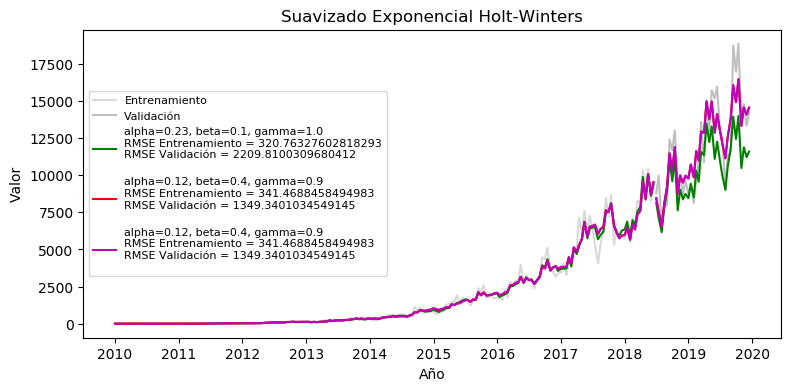

In [66]:
y_pred_HW_add = HW_exponential_smoothing(y_train = y_train, y_test = y_test, trend = "add", seasonal = "add", seasonal_periods = 24,
                         alpha = [HW_smoothing_parameter_add[0][0], HW_smoothing_parameter_add[1][0], HW_smoothing_parameter_add[2][0]],
                         beta = [HW_smoothing_parameter_add[0][1], HW_smoothing_parameter_add[1][1], HW_smoothing_parameter_add[2][1]],
                         gamma = [HW_smoothing_parameter_add[0][2], HW_smoothing_parameter_add[1][2], HW_smoothing_parameter_add[2][2]],
                         damped = False)

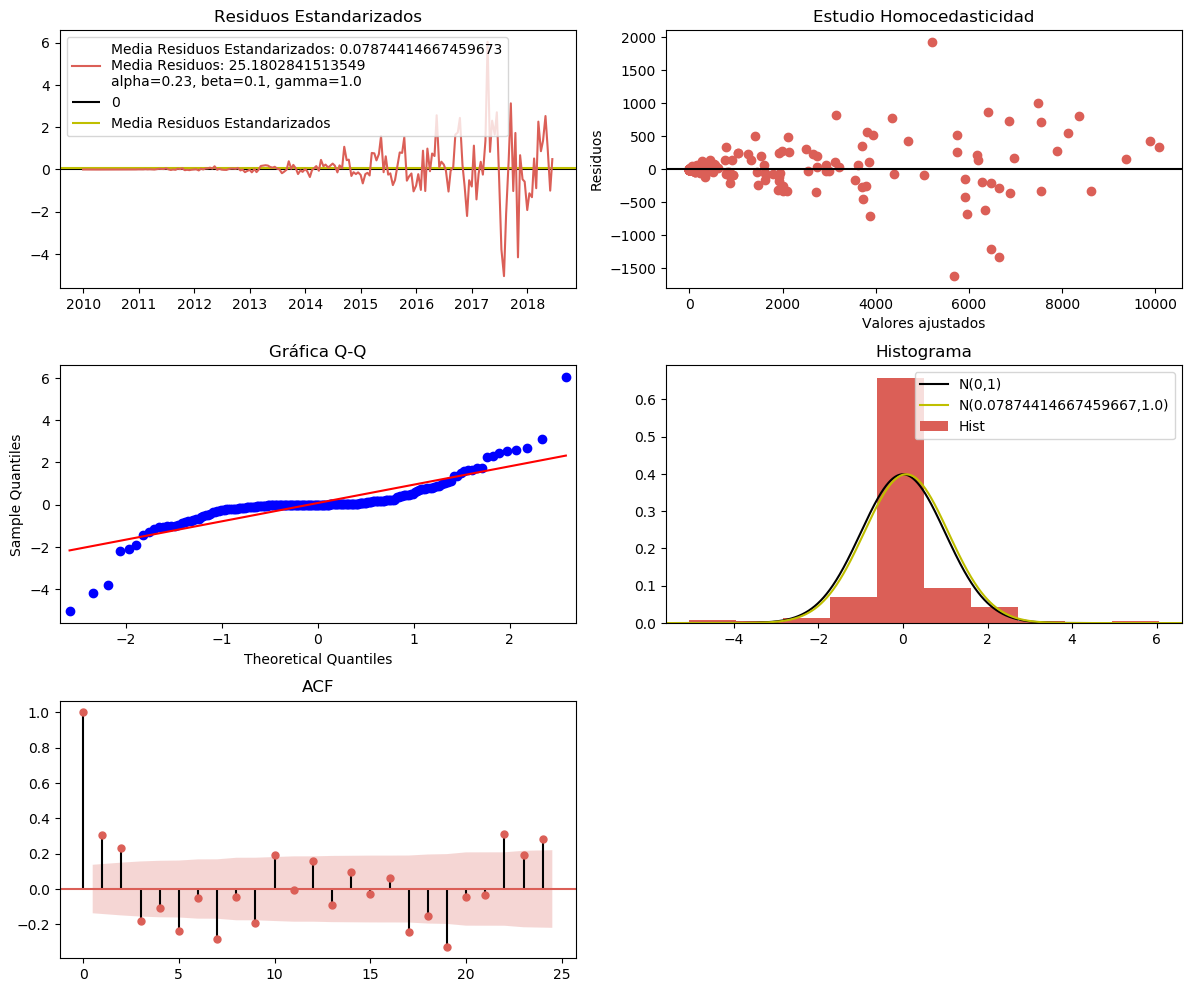

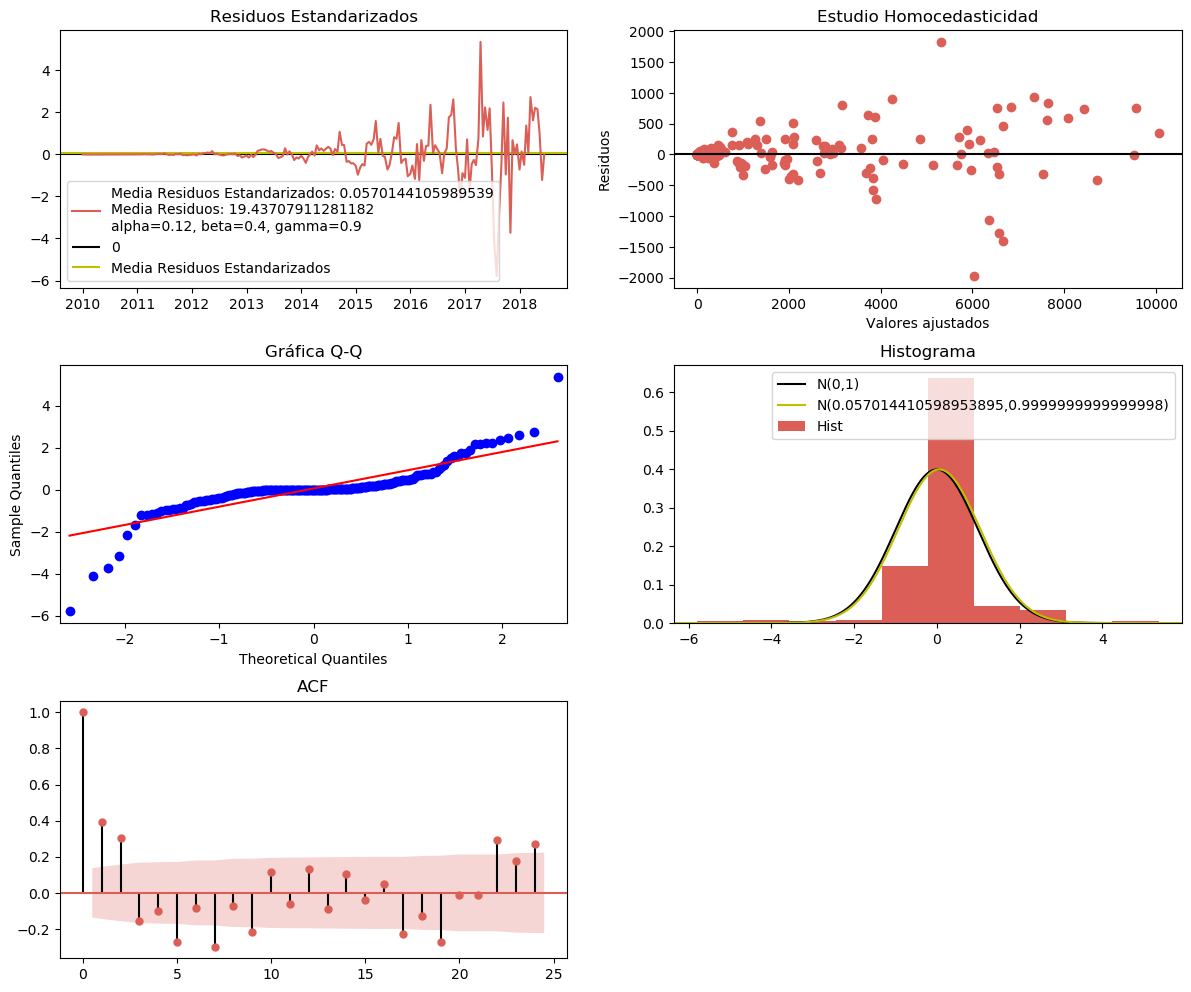

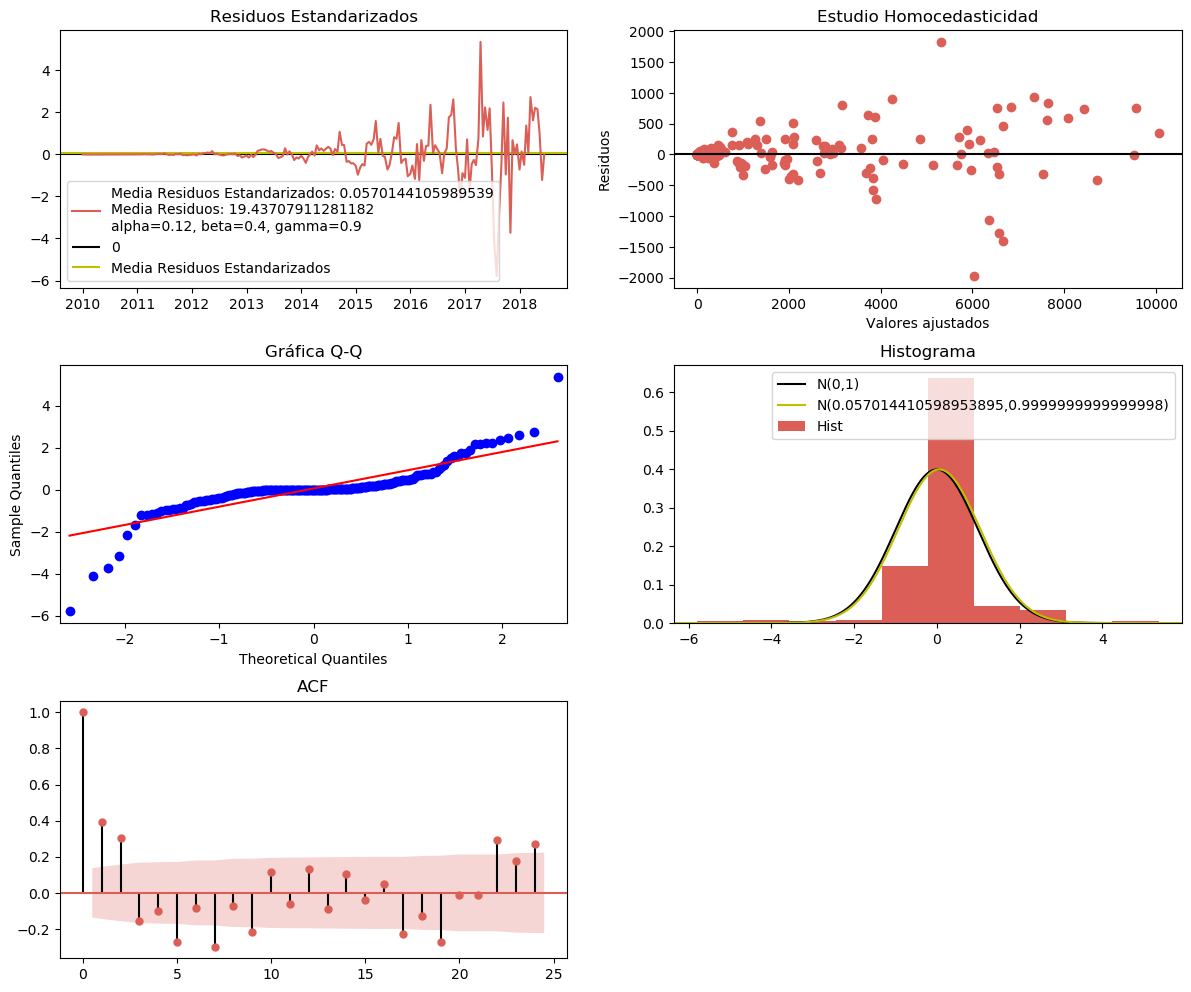

In [67]:
HW_residuals_add = HW_residuals(y_train = y_train, y_test = y_test, trend = "add", seasonal = "add", seasonal_periods = 24,
                         alpha = [HW_smoothing_parameter_add[0][0], HW_smoothing_parameter_add[1][0], HW_smoothing_parameter_add[2][0]],
                         beta = [HW_smoothing_parameter_add[0][1], HW_smoothing_parameter_add[1][1], HW_smoothing_parameter_add[2][1]],
                         gamma = [HW_smoothing_parameter_add[0][2], HW_smoothing_parameter_add[1][2], HW_smoothing_parameter_add[2][2]],
                         damped = False)

#### Resultados Multiplicativos

In [68]:
HW_smoothing_parameter_mul = HW_smoothing_parameter(y_train = y_train.replace(0,1), y_test = y_test, trend = "mul", seasonal = "mul" , seasonal_periods = 24, damped = True)

Mejores parámetros (Datos Entrenamiento): 
				 alpha: 0.12
				 beta:  0.1
				 gamma:  0.6000000000000001
Mejores parámetros (Datos Validación): 
				 alpha: 0.41000000000000003
				 beta:  0.1
				 gamma:  0.5
Mejores parámetros (Datos conjuntos): 
				 alpha: 0.41000000000000003
				 beta:  0.1
				 gamma:  0.5


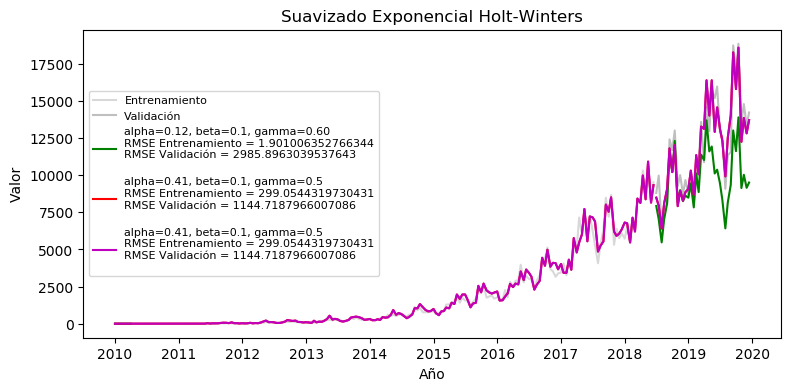

In [69]:
y_pred_HW_mul = HW_exponential_smoothing(y_train = y_train.replace(0,1), y_test = y_test, trend = "mul", seasonal = "mul", seasonal_periods = 24,
                         alpha = [HW_smoothing_parameter_mul[0][0], HW_smoothing_parameter_mul[1][0], HW_smoothing_parameter_mul[2][0]],
                         beta = [HW_smoothing_parameter_mul[0][1], HW_smoothing_parameter_mul[1][1], HW_smoothing_parameter_mul[2][1]],
                         gamma = [HW_smoothing_parameter_mul[0][2], HW_smoothing_parameter_mul[1][2], HW_smoothing_parameter_mul[2][2]],
                         damped = True)

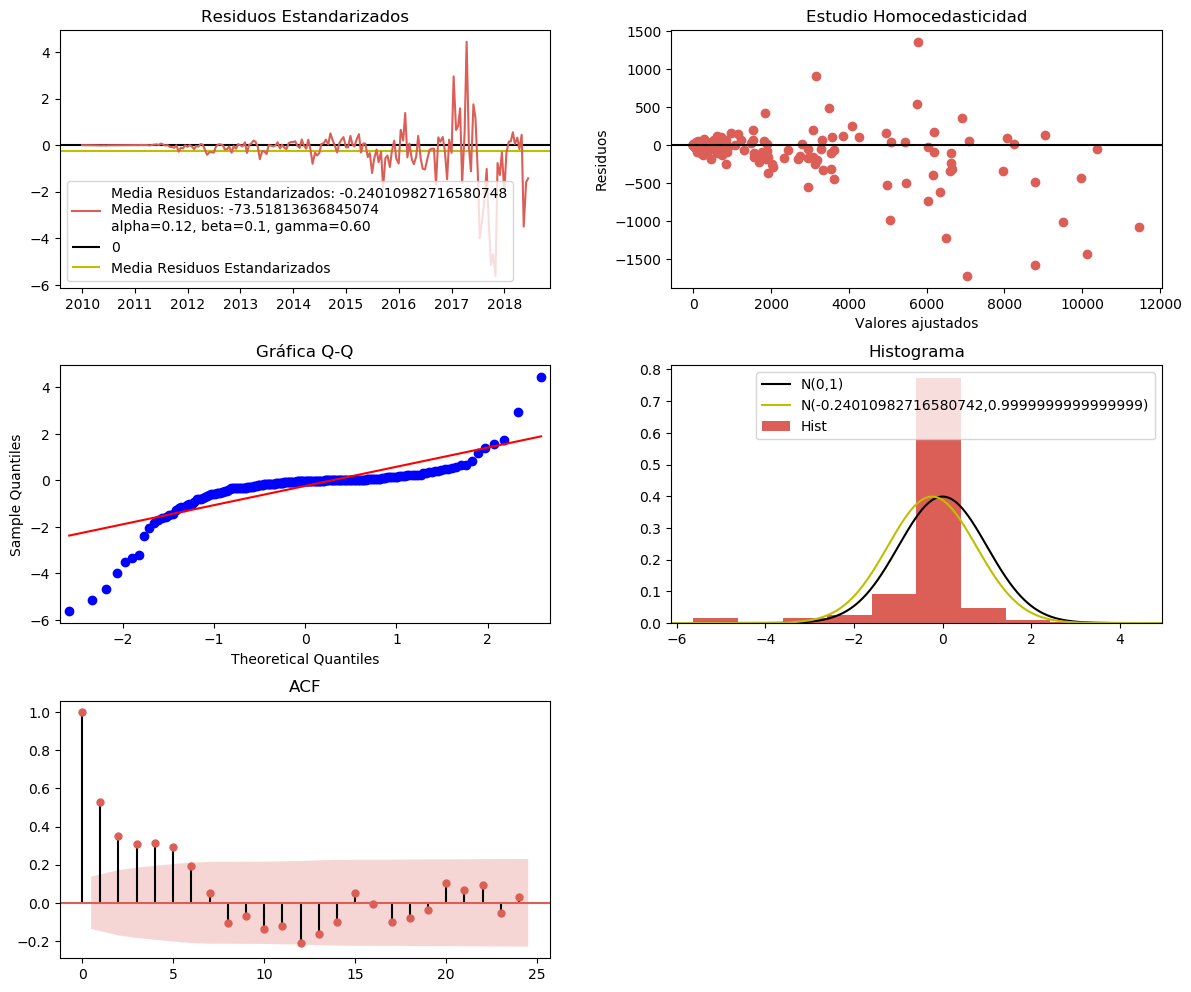

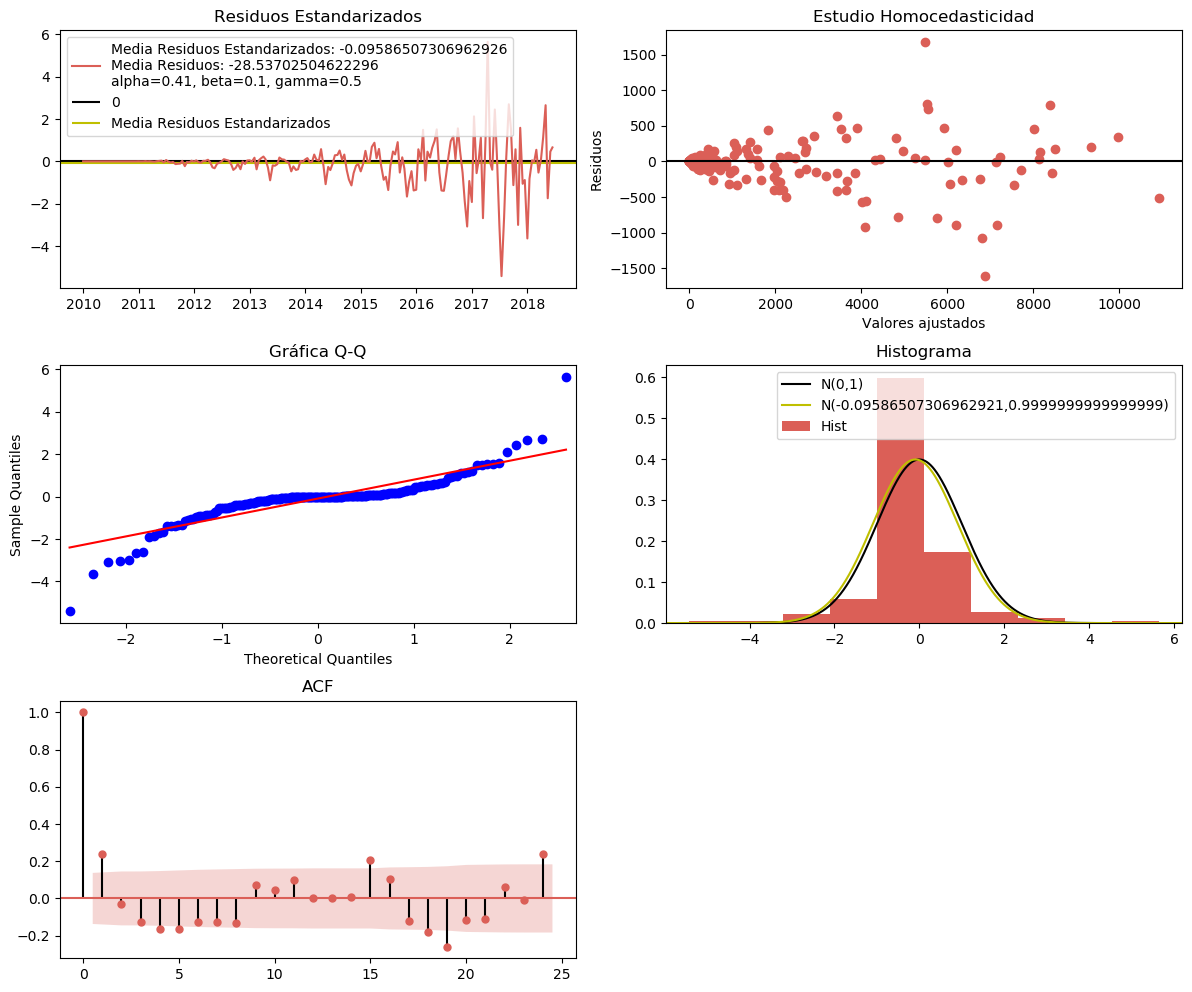

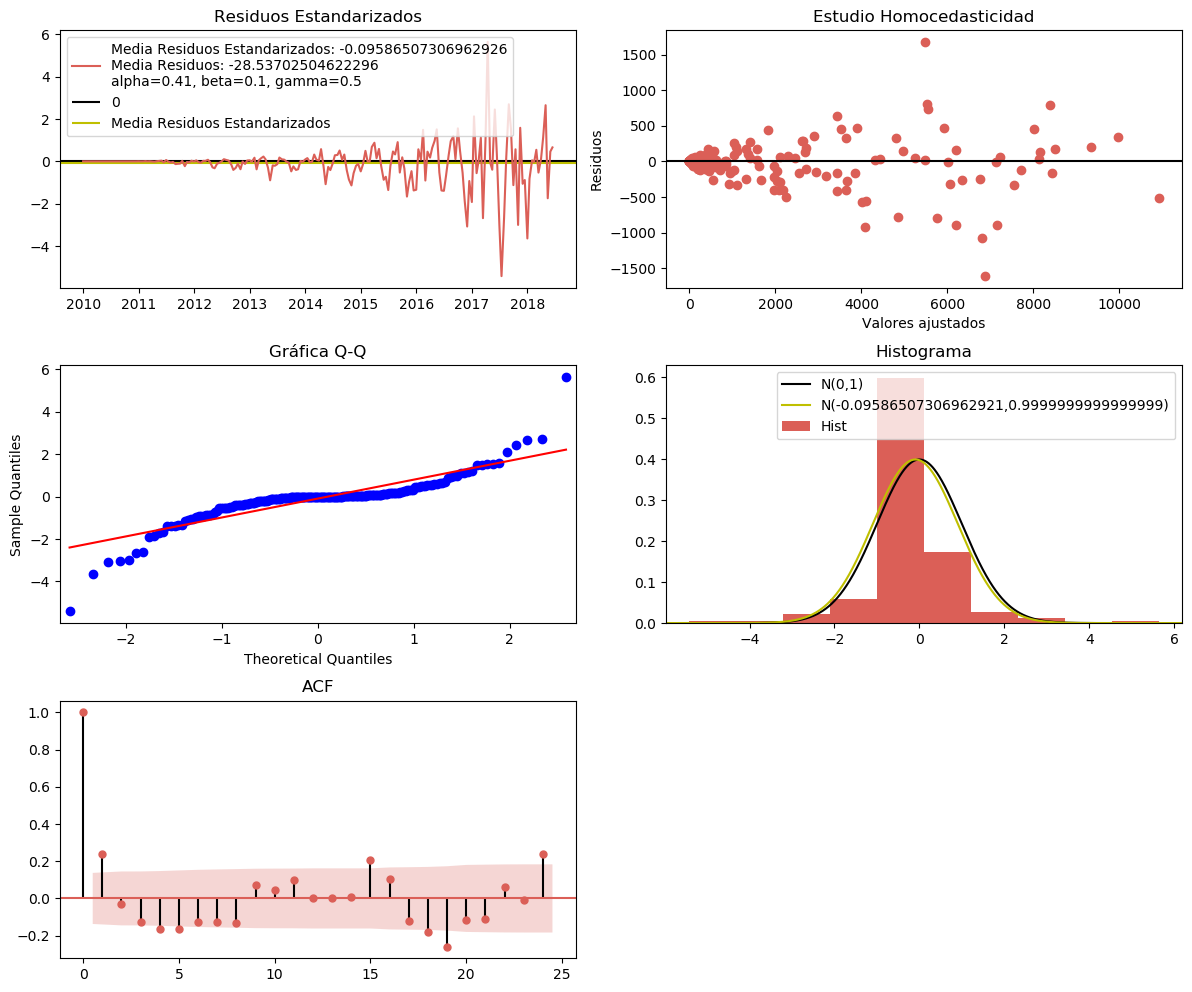

In [70]:
HW_residuals_mult = HW_residuals(y_train = y_train.replace(0,1), y_test = y_test, trend = "mul", seasonal = "mul", seasonal_periods = 24,
                         alpha = [HW_smoothing_parameter_mul[0][0], HW_smoothing_parameter_mul[1][0], HW_smoothing_parameter_mul[2][0]],
                         beta = [HW_smoothing_parameter_mul[0][1], HW_smoothing_parameter_mul[1][1], HW_smoothing_parameter_mul[2][1]],
                         gamma = [HW_smoothing_parameter_mul[0][2], HW_smoothing_parameter_mul[1][2], HW_smoothing_parameter_mul[2][2]],
                         damped = False)

#### Comparación de los modelos

Se comparan los resultados obtenidos con los diferentes métodos estudiados hasta el momento.

In [71]:
series = [y_pred_naive,  y_pred_average, y_pred_s_naive, y_pred_drift, y_pred_SES, y_pred_DES, y_pred_HW_add, y_pred_HW_mul]
accuracy_comparison = pd.DataFrame()
MAE = [] ; MSE = [] ; MAPE = [] ; R_cuadrado = [] ; MedAE = [] ; MSLE = []; RMSE = []
index = []
for i in series :
    MAE.append(mean_absolute_error(y_test, i.values))
    RMSE.append(root_mean_squared_error(y_test, i.values))
    MedAE.append(median_absolute_error(y_test, i.values))
    MSE.append(mean_squared_error(y_test, i.values))
    MAPE.append(mean_absolute_percentage_error(y_test, i.values))
    MSLE.append(mean_squared_log_error(y_test, i.values))
    R_cuadrado.append(r2_score(y_test, i.values))  
    index.append(i.name)
accuracy_comparison["MAE"] = MAE ; accuracy_comparison["RMSE"] = RMSE ;accuracy_comparison["MedAE"] = MedAE; accuracy_comparison["MSE"] = MSE; accuracy_comparison["MAPE"] = MAPE; accuracy_comparison["MSLE"] = MSLE; accuracy_comparison["R_cuadrado"] = R_cuadrado
accuracy_comparison.index = index 

def highlight_min(s):
    '''
    highlight the minimum in a Series in green.
    '''
    if s.name == "R_cuadrado" : 
        is_max = s == s.max()
        return ['background-color: green' if v else '' for v in is_max]
    else : 
        is_min = s == s.min()
        return ['background-color: green' if v else '' for v in is_min]

In [72]:
accuracy_comparison.style.apply(highlight_min)

# ARIMA

In [73]:
def SARIMA_hyperparameters(y_train, y_test, m, star_p = 0, max_p = 2, star_d = 0, max_d = 1, star_q = 0, max_q = 2, star_P = 0, max_P = 1, star_D = 0, max_D = 1, star_Q = 0, max_Q = 1) :

    import itertools
    from statsmodels.tsa.arima.model import ARIMA
    
    p = range(star_p, max_p + 1); P = range(star_P, max_P + 1)
    d = range(star_d, max_d + 1); D = range(star_D, max_D + 1)
    q = range(star_q, max_q + 1); Q = range(star_Q, max_Q + 1)
    m = m
    pdq = list(itertools.product(p, d, q))
    PDQ = list(itertools.product(P, D, Q))
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in PDQ]
    
    RMSE_test = [] ;     RMSE_train = [];    pdq_list = [];    seasonal_pdq_list = []; AIC = []
    for param in pdq : 
        for param_seasonal in seasonal_pdq:
            model = ARIMA(y_train, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
            results = model.fit()
            y_pred_SARIMA = results.forecast(len(y_test))
            RMSE_train.append(root_mean_squared_error(y_train, results.predict()))
            RMSE_test.append(root_mean_squared_error(y_test, y_pred_SARIMA))
            AIC.append(results.aic)
            pdq_list.append(param)
            seasonal_pdq_list.append(param_seasonal)

    sarima_parameters = pd.DataFrame({"RMSE Train" : RMSE_train, "RMSE Test" : RMSE_test, "AIC" : AIC, "grade" : pdq_list,"seasonal grade" : seasonal_pdq_list})
    sarima_parameters["hyperparameters"] = sarima_parameters["grade"].astype(str) + "x" + sarima_parameters["seasonal grade"].astype(str)
    sarima_parameters["RMSE Diff"] = sarima_parameters["RMSE Test"] - sarima_parameters["RMSE Train"]
    sarima_parameters.set_index(["grade", "seasonal grade"], inplace = True)
    
    train_adjusted = sarima_parameters["RMSE Train"].idxmin()
    test_adjusted = sarima_parameters["RMSE Test"].idxmin()
    train_test_adjusted = sarima_parameters["RMSE Diff"].idxmin()
    aic_adjusted = sarima_parameters["AIC"].idxmin()
    
    print("Mejor modelo SARIMA (Entrenamiento): ", train_adjusted)    
    print("Mejor modelo SARIMA (Validación): ", test_adjusted) 
    print("Mejor modelo SARIMA (Conjunto): ", train_test_adjusted) 
    print("Mejor modelo SARIMA (AIC): ", aic_adjusted) 
    
    return train_adjusted, test_adjusted, train_test_adjusted, aic_adjusted, sarima_parameters

In [74]:
def SARIMA(y_train, y_test, order = (1,0,0), seasonal_order = None, residuals = True, name = "SARIMA"):
    
    from statsmodels.tsa.arima.model import ARIMA
    model1 = ARIMA(y_train, order = order[0], seasonal_order = seasonal_order[0], enforce_stationarity = False, enforce_invertibility = False)
    fit1 = model1.fit()
    model2 = ARIMA(y_train, order = order[1], seasonal_order = seasonal_order[1], enforce_stationarity = False, enforce_invertibility = False)
    fit2 = model2.fit()
    model3 = ARIMA(y_train, order = order[2], seasonal_order = seasonal_order[2], enforce_stationarity = False, enforce_invertibility = False)
    fit3 = model3.fit()
    model4 = ARIMA(y_train, order = order[3], seasonal_order = seasonal_order[3], enforce_stationarity = False, enforce_invertibility = False)
    fit4 = model4.fit()



    fig, ax = plt.subplots(figsize=(15, 7))

    ax.plot(y_train.replace(0,1), label = "Entrenamiento", color = "grey", alpha = 0.5)
    ax.plot(y_test, label = "Validación", color = "grey", alpha = 0.5)
    for f, c, o, s in zip((fit1, fit2, fit3, fit4),('g','r','m','y'), (order[0], order[1], order[2], order[3]),
                          (seasonal_order[0], seasonal_order[1], seasonal_order[2], seasonal_order[3])) :
        ax.plot(f.predict(), color = c)
        ax.plot(f.forecast(len(y_test)), label=("\nparam: " + str(o) + ", param estaci: " + str(s) + 
                                                "\nRMSE Entramiento = " + str(root_mean_squared_error(y_train, f.predict()))+ 
                                                "\nRMSE Validación = " + str(root_mean_squared_error(y_test, f.forecast(len(y_test))))+
                                               "\nAIC = " + str(f.aic)),
                color=c)

    ax.legend(loc='top left')
    plt.show();
    
    if residuals is True :

        for f, o, s in zip((fit1, fit2, fit3, fit4), (order[0], order[1], order[2], order[3]),
                              (seasonal_order[0], seasonal_order[1], seasonal_order[2], seasonal_order[3])) :


            f.plot_diagnostics(figsize=(15,10))
            print("\norder: " + str(o) + ", seasonal order: " + str(s) + 
                                                    "\nRMSE Train = " + str(root_mean_squared_error(y_train, f.predict()))+ 
                                                    "\nRMSE Test = " + str(root_mean_squared_error(y_test, f.forecast(len(y_test))))+
                                                   "\nAIC = " + str(f.aic) + "\nResid Mean = " + str(f.resid.mean()))
            plt.show()
    
    return (pd.Series(fit1.forecast(len(y_test)), name = name), pd.Series(fit2.forecast(len(y_test)), name = name),
            pd.Series(fit3.forecast(len(y_test)), name = name), pd.Series(fit4.forecast(len(y_test)), name = name))
            # In return you choose the model that you want to be the final result.

In [75]:
def SARIMA_residuals(y_train, y_test, order = (1,0,0), seasonal_order = None) :
    
    from scipy.stats import norm
    from statsmodels.graphics.gofplots import qqplot
    from statsmodels.tsa.arima.model import ARIMA
    model1 = ARIMA(y_train, order = order[0], seasonal_order = seasonal_order[0], enforce_stationarity = False, enforce_invertibility = False)
    fit1 = model1.fit()
    model2 = ARIMA(y_train, order = order[1], seasonal_order = seasonal_order[1], enforce_stationarity = False, enforce_invertibility = False)
    fit2 = model2.fit()
    model3 = ARIMA(y_train, order = order[2], seasonal_order = seasonal_order[2], enforce_stationarity = False, enforce_invertibility = False)
    fit3 = model3.fit()
    model4 = ARIMA(y_train, order = order[3], seasonal_order = seasonal_order[3], enforce_stationarity = False, enforce_invertibility = False)
    fit4 = model4.fit()
    
    for f, o, s in zip((fit1, fit2, fit3, fit4), (order[0], order[1], order[2], order[3]),
                              (seasonal_order[0], seasonal_order[1], seasonal_order[2], seasonal_order[3])) :
        resid = f.resid/np.std(f.resid)
        fig, ax = plt.subplots(3,2, figsize = (12,10))
        
        
        # Gráfica residuos
        ax[0,0].plot(resid, label = ("Media Residuos Estandarizados: " + str(resid.mean())+ "\nMedia Residuos: " + str(f.resid.mean()) + 
                                     "\nparam: " + str(o) + ", param estaci: " + str(s)))
        ax[0,0].set_title("Residuos Estandarizados")
        xmin, xmax = ax[0,0].set_xlim()
        ax[0,0].hlines(0, xmin, xmax, color = "k", label="0")
        ax[0,0].hlines(resid.mean(), xmin, xmax, color = "y", label = "Media Residuos Estandarizados")
        ax[0,0].legend()
        
        #Histograma
        mu, std = norm.fit(resid)
        ax[1,1].hist(resid, density = True, label = "Hist")
        xmin, xmax = ax[1,1].set_xlim()
        range = np.arange(xmin, xmax, 0.001)
        ax[1,1].plot(range, norm.pdf(range,0,1), c = "k", label = "N(0,1)")
        ax[1,1].plot(range, norm.pdf(range,mu,std), c= "y", label = "N({},{})".format(mu,std))
        ax[1,1].set_title("Histograma")
        ax[1,1].legend()
        
        
        #Gráfica Q-Q
        qqplot(resid, ax = ax[1,0], line = "r")
        ax[1,0].set_title("Gráfica Q-Q")
        
        #Autocorrelacion
        plot_acf(resid, ax = ax[2,0] )
        ax[2,0].set_title("ACF")
        
        #Homocedasticidad
        ax[0,1].scatter(f.fittedvalues, f.resid)
        xmin, xmax = ax[0,1].set_xlim()
        ax[0,1].hlines(0, xmin, xmax)
        ax[0,1].set_title("Estudio Homocedasticidad")
        ax[0,1].set_xlabel("Valores ajustados")
        ax[0,1].set_ylabel("Residuos")
        
        fig.delaxes(ax[2,1])
        fig.tight_layout(pad = 1)
        plt.show()

## AR

In [76]:
AR_p = SARIMA_hyperparameters(y_train = y_train, y_test = y_test, m = 0, star_p = 0, max_p = 3, star_d = 0, max_d = 0, star_q = 0, max_q = 0,
                                                                    star_P = 0, max_P = 0, star_D = 0, max_D = 0, star_Q = 0, max_Q = 0)
AR_hyperparameters = AR_p[0:4]

Mejor modelo SARIMA (Entrenamiento):  ((3, 0, 0), (0, 0, 0, 0))
Mejor modelo SARIMA (Validación):  ((2, 0, 0), (0, 0, 0, 0))
Mejor modelo SARIMA (Conjunto):  ((2, 0, 0), (0, 0, 0, 0))
Mejor modelo SARIMA (AIC):  ((3, 0, 0), (0, 0, 0, 0))


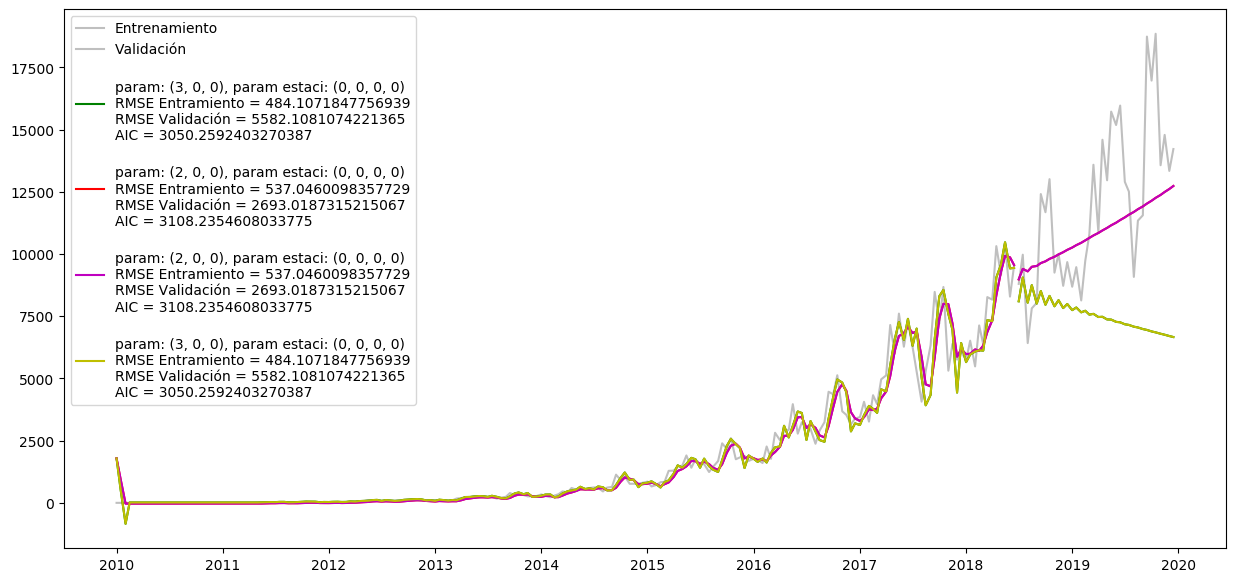

In [77]:
y_pred_AR = SARIMA(y_train = y_train, y_test = y_test, order = [AR_hyperparameters[0][0], AR_hyperparameters[1][0],  AR_hyperparameters[2][0], AR_hyperparameters[3][0]], 
                                            seasonal_order = [AR_hyperparameters[0][1], AR_hyperparameters[1][1], AR_hyperparameters[2][1], AR_hyperparameters[3][1]],
                  residuals=False, name = "AR")

## MA

In [78]:
MA_p = SARIMA_hyperparameters(y_train = y_train, y_test = y_test, m = 0, star_p = 0, max_p = 0, star_d = 0, max_d = 0, star_q = 0, max_q = 3,
                                                                    star_P = 0, max_P = 0, star_D = 0, max_D = 0, star_Q = 0, max_Q = 0)
MA_hyperparameters = MA_p[0:4]

Mejor modelo SARIMA (Entrenamiento):  ((0, 0, 3), (0, 0, 0, 0))
Mejor modelo SARIMA (Validación):  ((0, 0, 3), (0, 0, 0, 0))
Mejor modelo SARIMA (Conjunto):  ((0, 0, 0), (0, 0, 0, 0))
Mejor modelo SARIMA (AIC):  ((0, 0, 3), (0, 0, 0, 0))


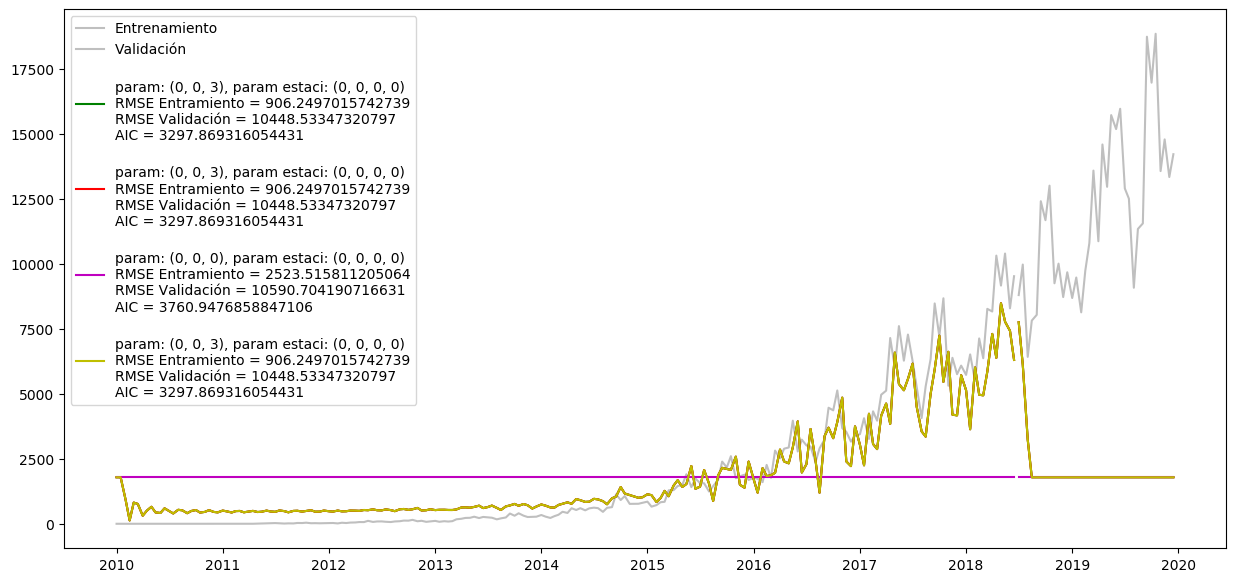

In [79]:
y_pred_MA = SARIMA(y_train = y_train, y_test = y_test, order = [MA_hyperparameters[0][0], MA_hyperparameters[1][0],  MA_hyperparameters[2][0], MA_hyperparameters[3][0]], 
                                            seasonal_order = [MA_hyperparameters[0][1], MA_hyperparameters[1][1], MA_hyperparameters[2][1], MA_hyperparameters[3][1]],
                  residuals=False,name = "MA")

## ARMA

In [80]:
ARMA_p = SARIMA_hyperparameters(y_train = y_train, y_test = y_test, m = 0, star_p = 0, max_p = 3, star_d = 0, max_d = 0, star_q = 0, max_q = 3,
                                                                    star_P = 0, max_P = 0, star_D = 0, max_D = 0, star_Q = 0, max_Q = 0)
ARMA_hyperparameters = ARMA_p[0:4]

Mejor modelo SARIMA (Entrenamiento):  ((3, 0, 3), (0, 0, 0, 0))
Mejor modelo SARIMA (Validación):  ((1, 0, 3), (0, 0, 0, 0))
Mejor modelo SARIMA (Conjunto):  ((1, 0, 3), (0, 0, 0, 0))
Mejor modelo SARIMA (AIC):  ((2, 0, 3), (0, 0, 0, 0))


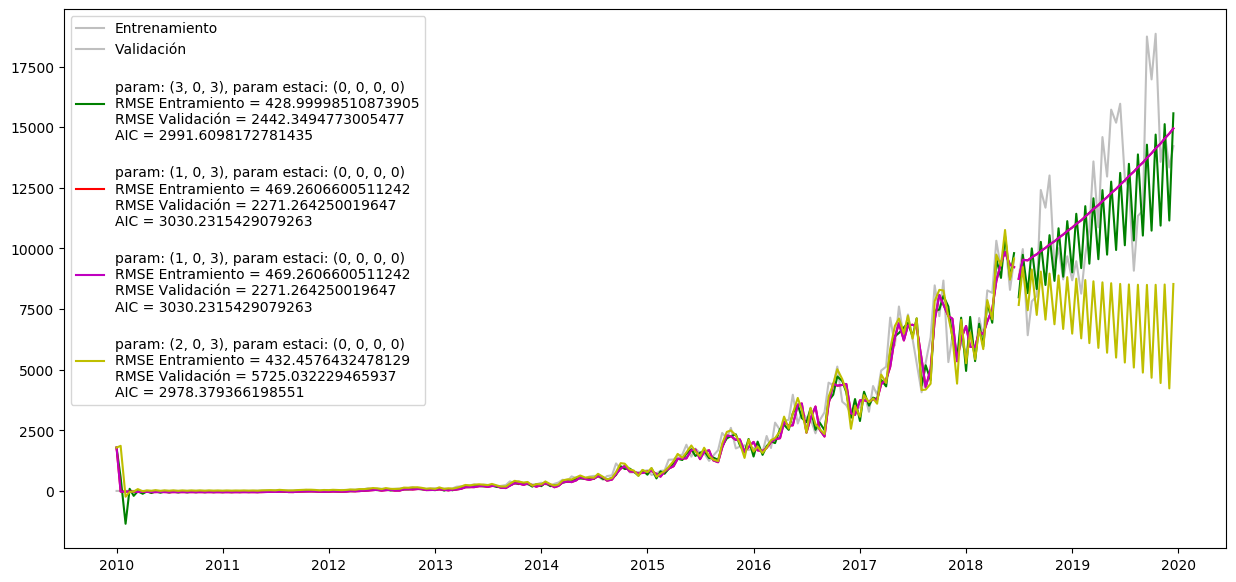

In [81]:
y_pred_ARMA = SARIMA(y_train = y_train, y_test = y_test, order = [ARMA_hyperparameters[0][0], ARMA_hyperparameters[1][0],  ARMA_hyperparameters[2][0], ARMA_hyperparameters[3][0]], 
                                            seasonal_order = [ARMA_hyperparameters[0][1], ARMA_hyperparameters[1][1], ARMA_hyperparameters[2][1], ARMA_hyperparameters[3][1]],
                    residuals=False,name = "ARMA")

## ARIMA

In [82]:
ARIMA_p = SARIMA_hyperparameters(y_train = y_train, y_test = y_test, m = 0, star_p = 0, max_p = 3, star_d = 0, max_d = 1, star_q = 0, max_q = 3,
                                                                    star_P = 0, max_P = 0, star_D = 0, max_D = 0, star_Q = 0, max_Q = 0)
ARIMA_hyperparameters = ARIMA_p[0:4]

Mejor modelo SARIMA (Entrenamiento):  ((3, 1, 3), (0, 0, 0, 0))
Mejor modelo SARIMA (Validación):  ((1, 0, 3), (0, 0, 0, 0))
Mejor modelo SARIMA (Conjunto):  ((1, 0, 3), (0, 0, 0, 0))
Mejor modelo SARIMA (AIC):  ((3, 1, 3), (0, 0, 0, 0))


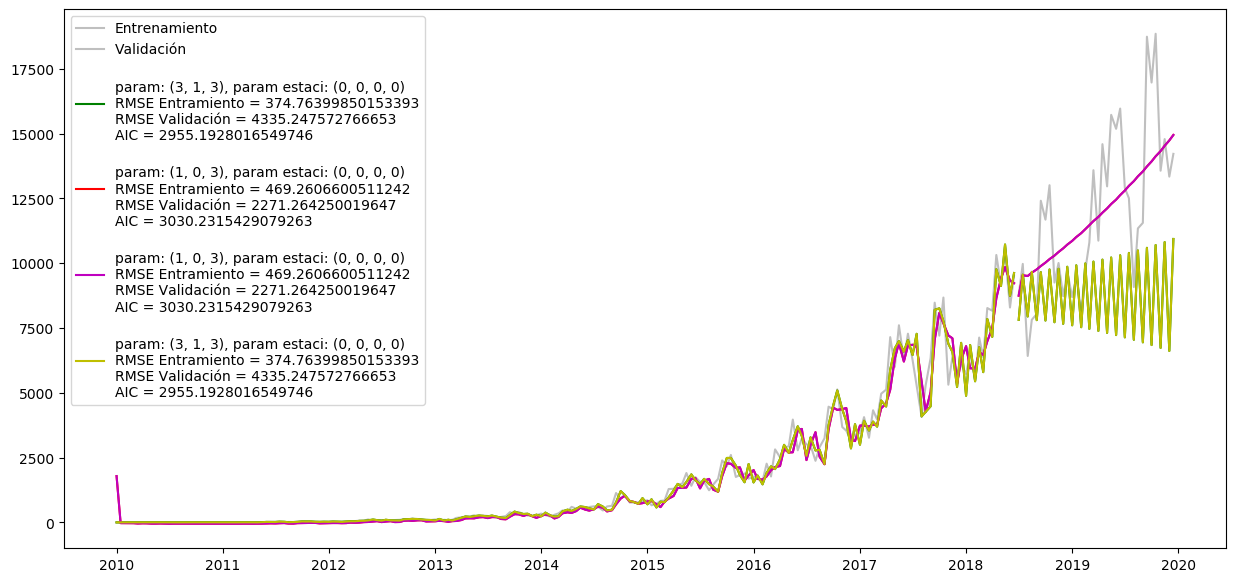

In [83]:
y_pred_ARIMA = SARIMA(y_train = y_train, y_test = y_test, order = [ARIMA_hyperparameters[0][0], ARIMA_hyperparameters[1][0],  ARIMA_hyperparameters[2][0], ARIMA_hyperparameters[3][0]], 
                                            seasonal_order = [ARIMA_hyperparameters[0][1], ARIMA_hyperparameters[1][1], ARIMA_hyperparameters[2][1], ARIMA_hyperparameters[3][1]],
                    residuals=False,name = "ARIMA")

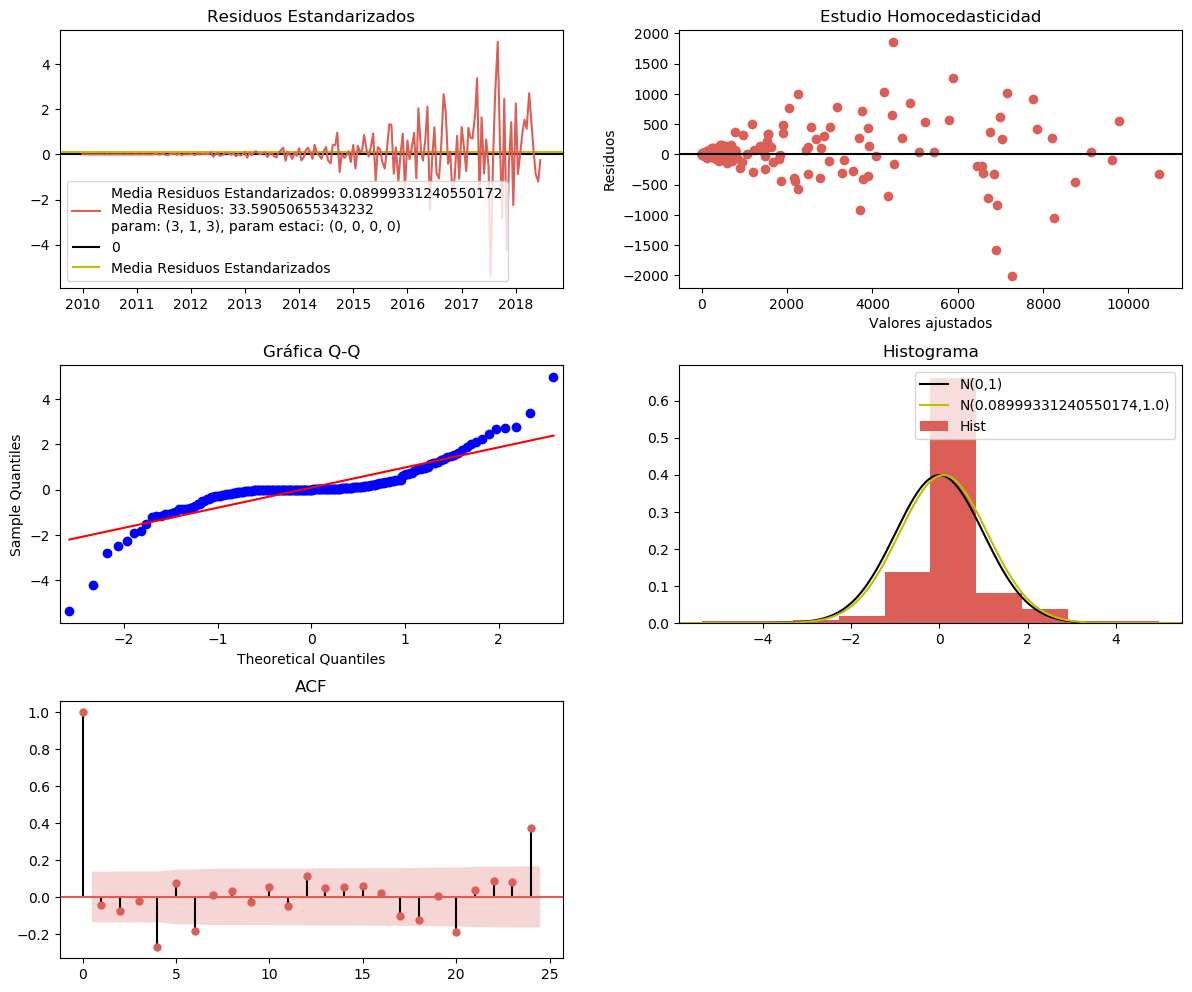

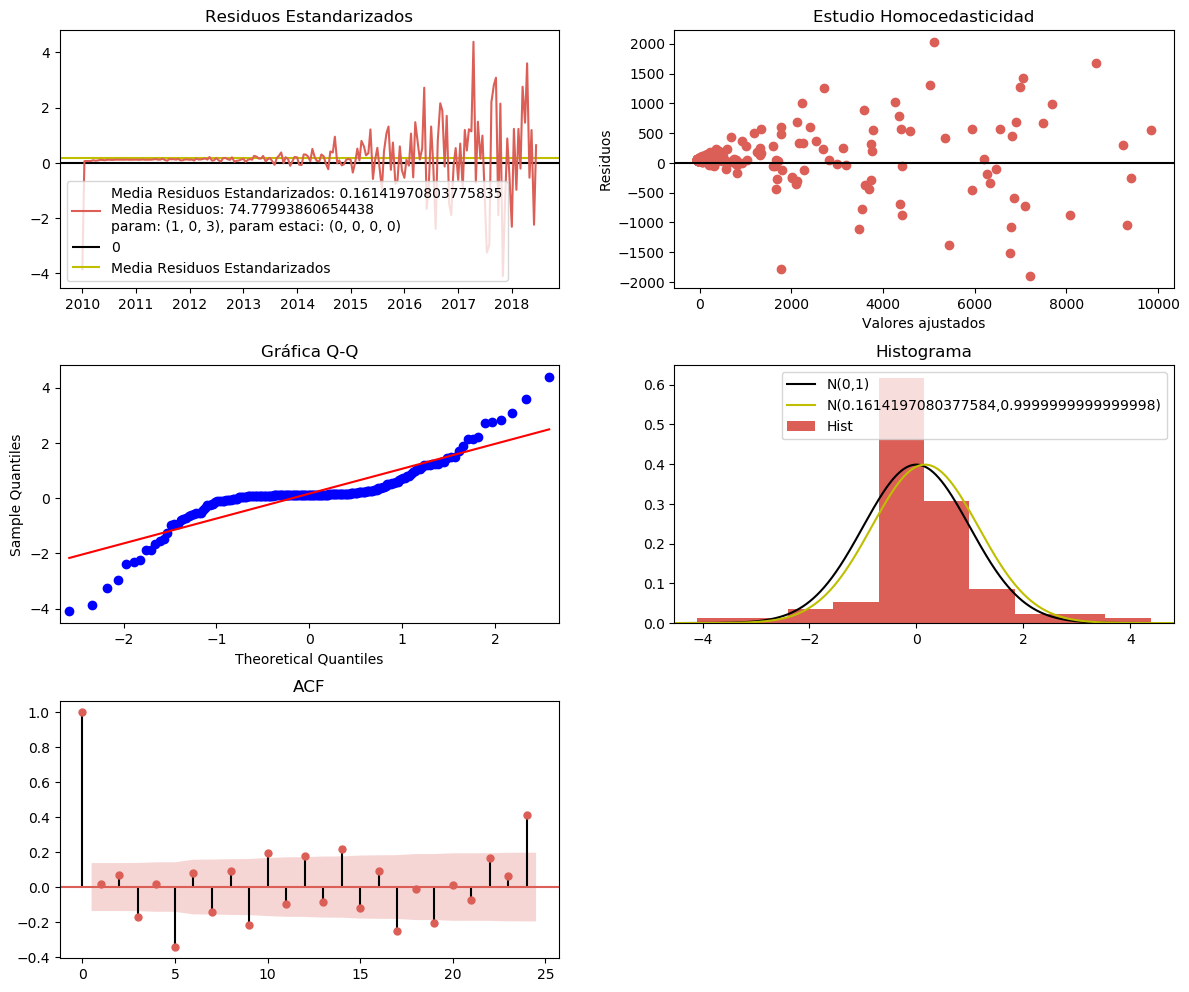

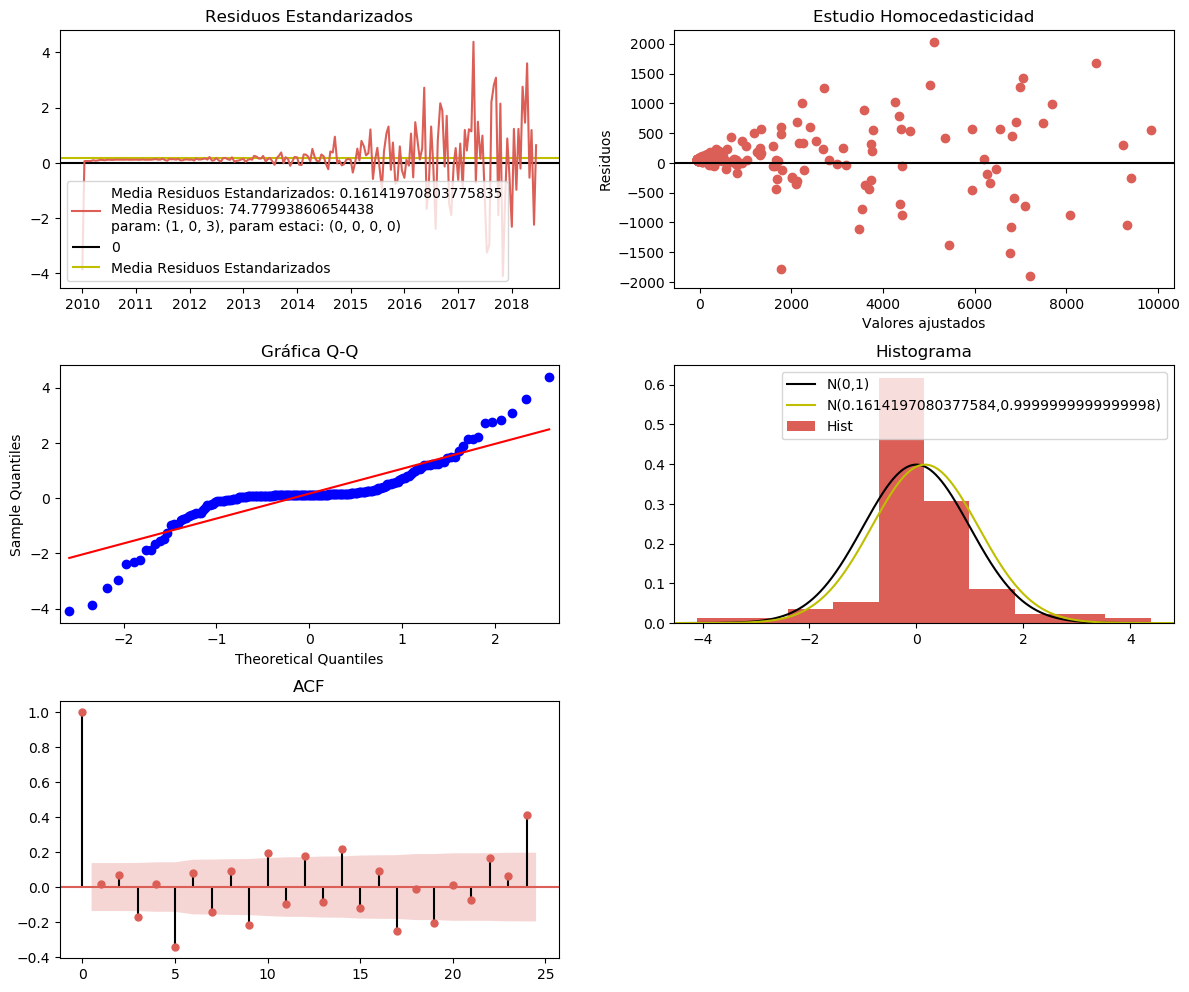

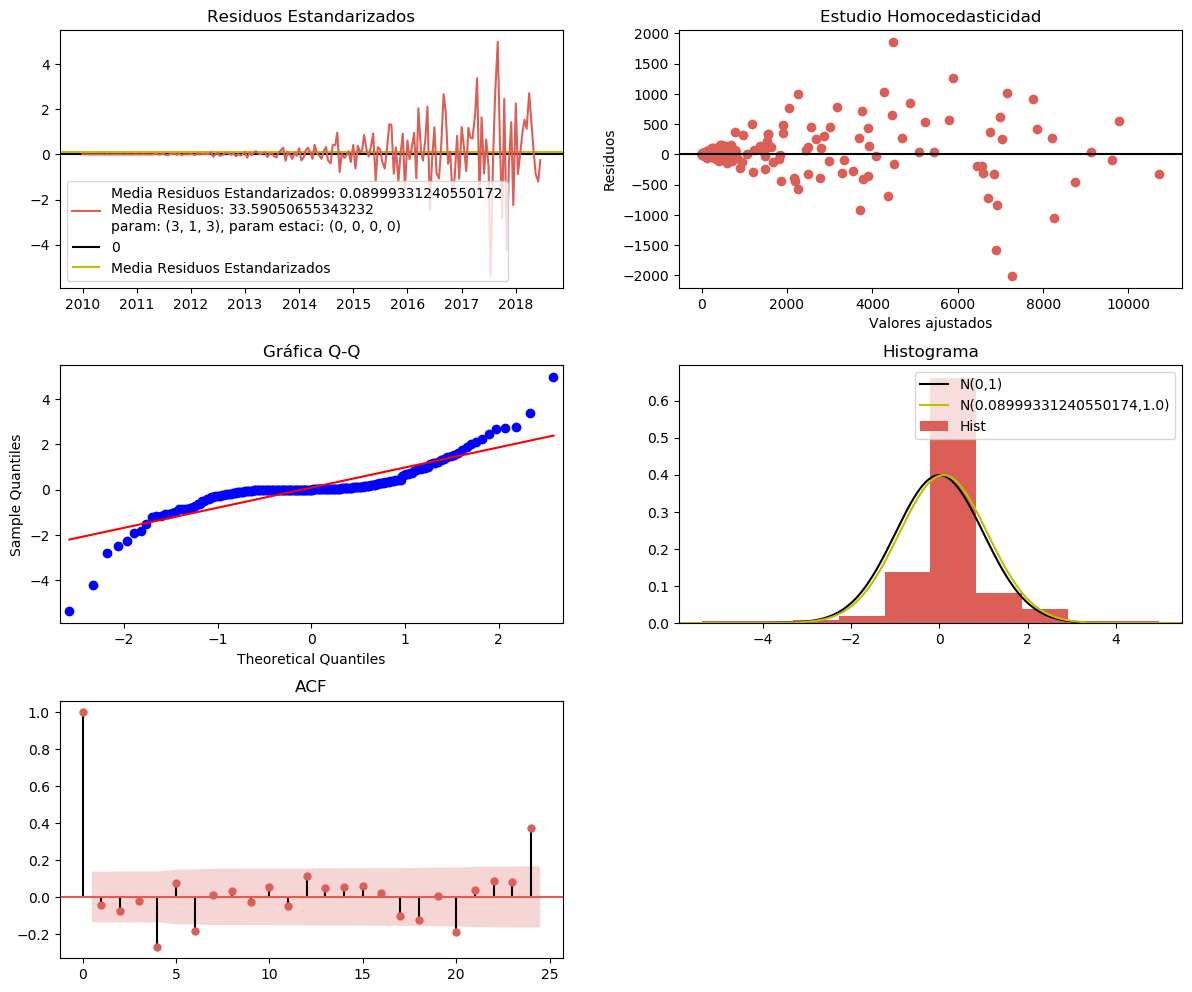

In [84]:
ARIMA_res = SARIMA_residuals(y_train = y_train, y_test = y_test, order = [ARIMA_hyperparameters[0][0], ARIMA_hyperparameters[1][0],  ARIMA_hyperparameters[2][0], ARIMA_hyperparameters[3][0]], 
                                            seasonal_order = [ARIMA_hyperparameters[0][1], ARIMA_hyperparameters[1][1], ARIMA_hyperparameters[2][1], ARIMA_hyperparameters[3][1]])

## SARIMA

In [85]:
SARIMA_p = SARIMA_hyperparameters(y_train = y_train, y_test = y_test, m = 24, star_p = 0, max_p = 3, star_d = 0, max_d = 1, star_q = 0, max_q = 3,
                                                                    star_P = 0, max_P = 1, star_D = 0, max_D = 1, star_Q = 0, max_Q = 1)
SARIMA_hyperparameters = SARIMA_p[0:4]

Mejor modelo SARIMA (Entrenamiento):  ((3, 1, 2), (1, 0, 1, 24))
Mejor modelo SARIMA (Validación):  ((3, 1, 3), (1, 0, 1, 24))
Mejor modelo SARIMA (Conjunto):  ((1, 0, 3), (1, 0, 1, 24))
Mejor modelo SARIMA (AIC):  ((3, 1, 3), (0, 1, 1, 24))


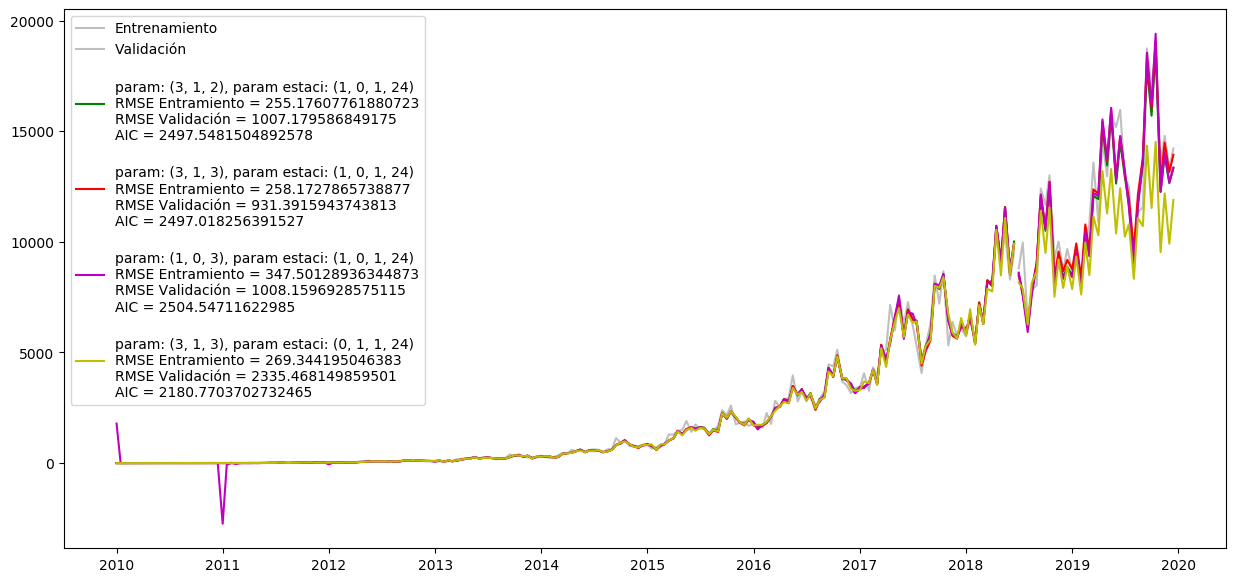

In [86]:
y_pred_SARIMA = SARIMA(y_train = y_train, y_test = y_test, order = [SARIMA_hyperparameters[0][0], SARIMA_hyperparameters[1][0],  SARIMA_hyperparameters[2][0], SARIMA_hyperparameters[3][0]], 
                                            seasonal_order = [SARIMA_hyperparameters[0][1], SARIMA_hyperparameters[1][1], SARIMA_hyperparameters[2][1], SARIMA_hyperparameters[3][1]],
                     residuals=False,name = "SARIMA")

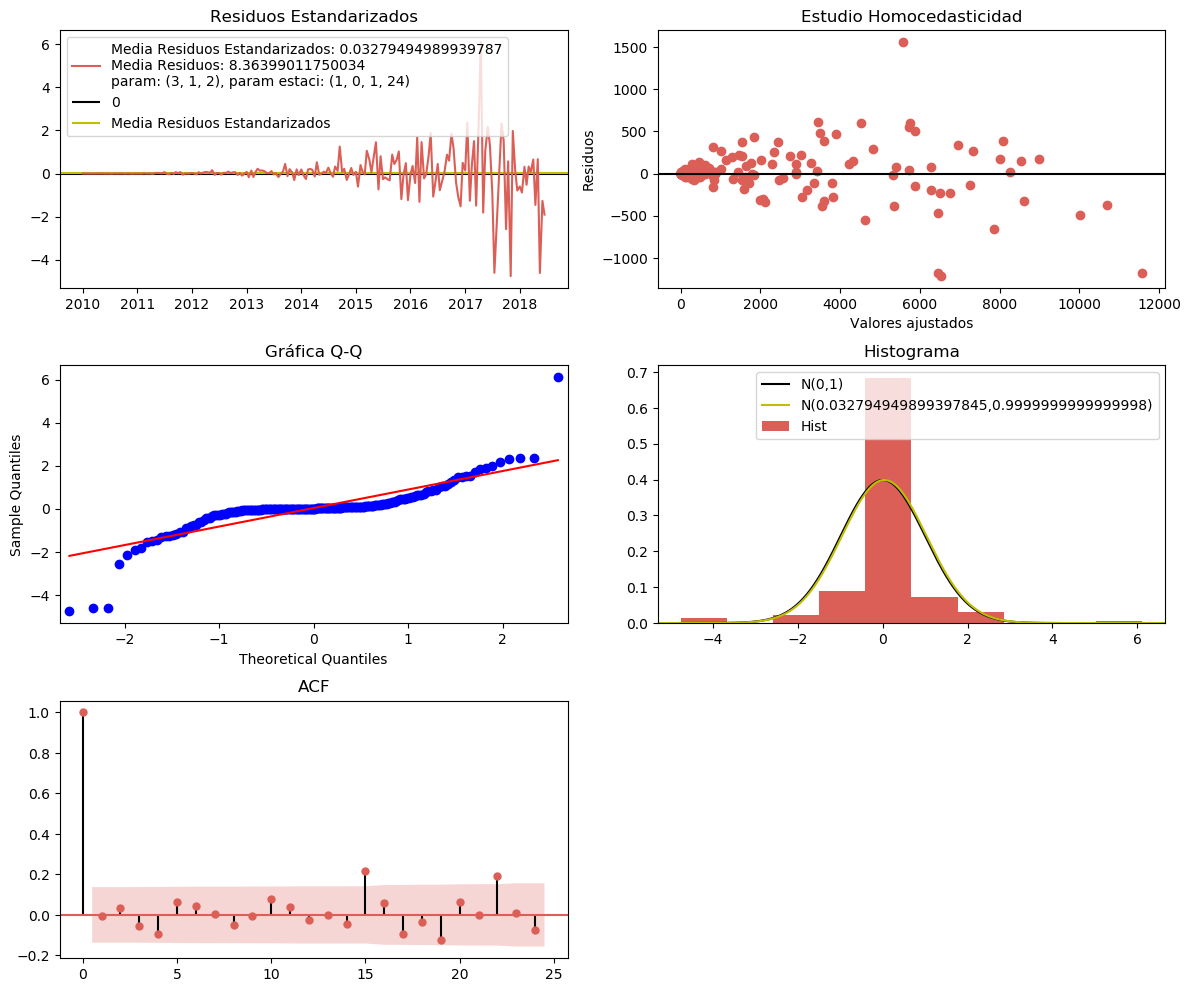

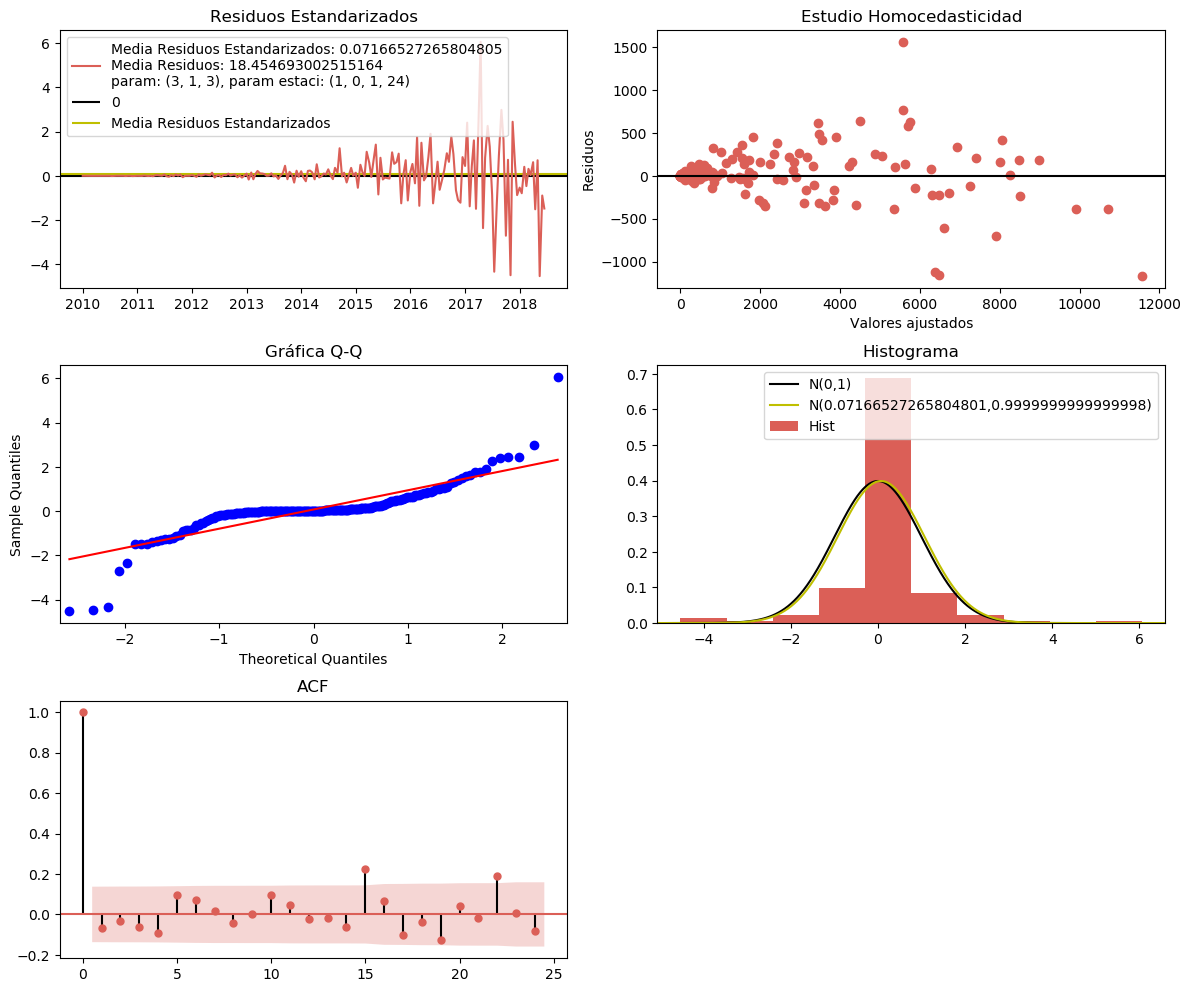

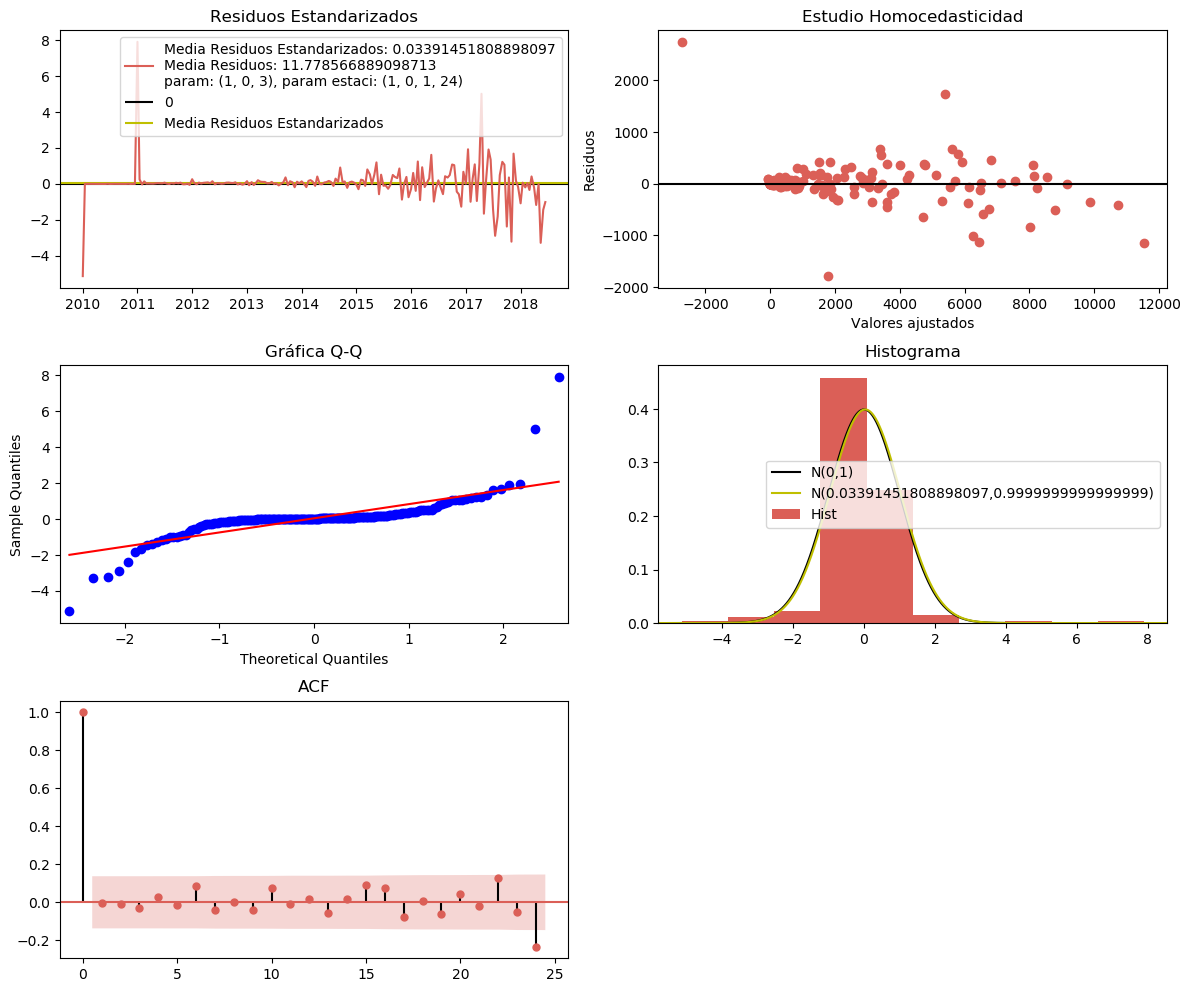

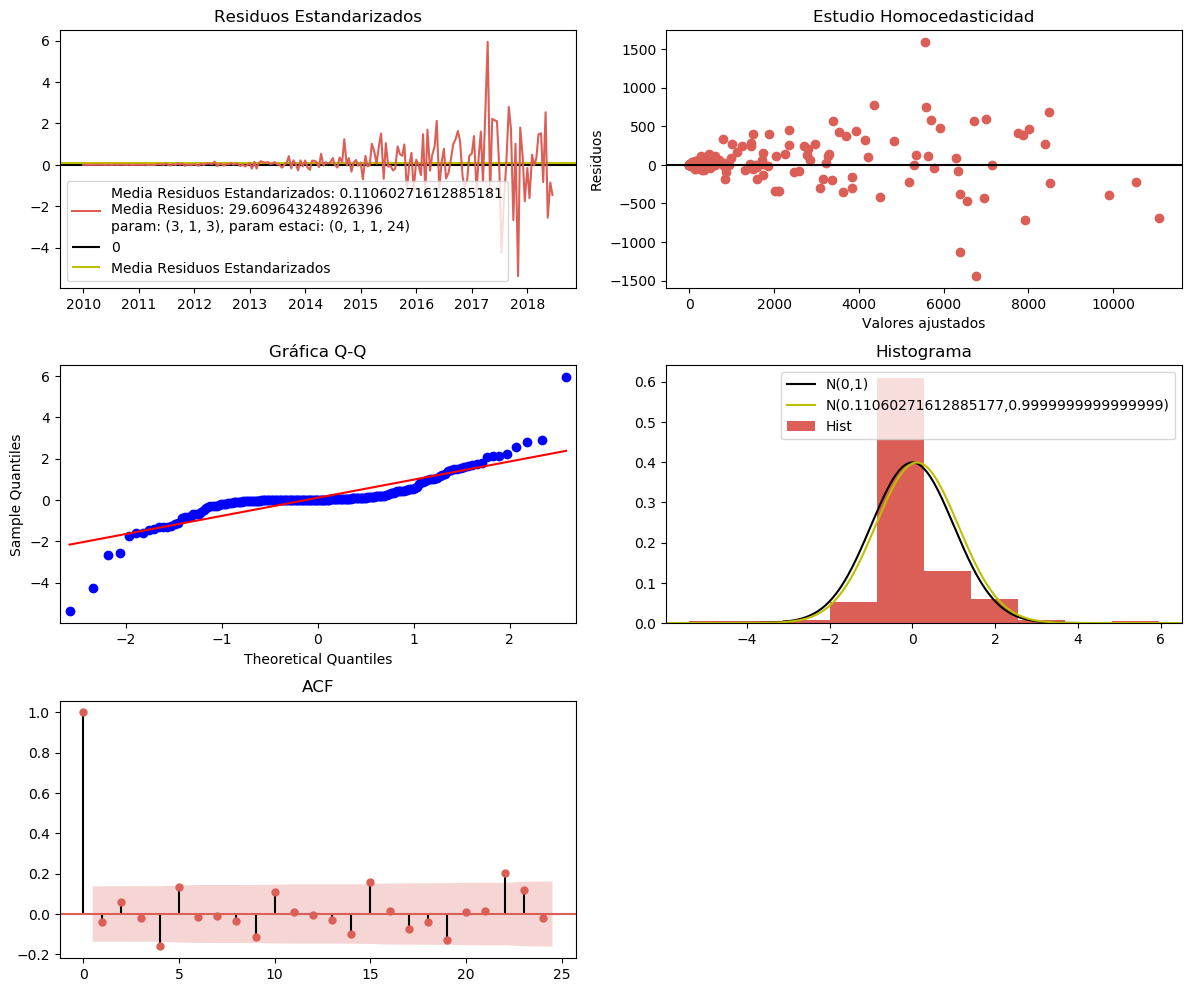

In [87]:
SARIMA_res = SARIMA_residuals(y_train = y_train, y_test = y_test, order = [SARIMA_hyperparameters[0][0], SARIMA_hyperparameters[1][0],  SARIMA_hyperparameters[2][0], SARIMA_hyperparameters[3][0]], 
                                            seasonal_order = [SARIMA_hyperparameters[0][1], SARIMA_hyperparameters[1][1], SARIMA_hyperparameters[2][1], SARIMA_hyperparameters[3][1]])

## SARIMAX

In [88]:
def SARIMAX_hyperparameters(y_train, y_test, m, star_p = 0, max_p = 2, star_d = 0, max_d = 1, star_q = 0, max_q = 2, star_P = 0, max_P = 1, star_D = 0, max_D = 1, star_Q = 0, max_Q = 1) :

    import itertools
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    p = range(star_p, max_p + 1); P = range(star_P, max_P + 1)
    d = range(star_d, max_d + 1); D = range(star_D, max_D + 1)
    q = range(star_q, max_q + 1); Q = range(star_Q, max_Q + 1)
    m = m
    pdq = list(itertools.product(p, d, q))
    PDQ = list(itertools.product(P, D, Q))
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in PDQ]
    
    RMSE_test = [] ;     RMSE_train = [];    pdq_list = [];    seasonal_pdq_list = []; AIC = []
    for param in pdq : 
        for param_seasonal in seasonal_pdq:
            model = SARIMAX(y_train, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
            results = model.fit()
            y_pred_SARIMAX = results.forecast(len(y_test))
            RMSE_train.append(root_mean_squared_error(y_train, results.predict()))
            RMSE_test.append(root_mean_squared_error(y_test, y_pred_SARIMAX))
            AIC.append(results.aic)
            pdq_list.append(param)
            seasonal_pdq_list.append(param_seasonal)

    sarima_parameters = pd.DataFrame({"RMSE Train" : RMSE_train, "RMSE Test" : RMSE_test, "AIC" : AIC, "grade" : pdq_list,"seasonal grade" : seasonal_pdq_list})
    sarima_parameters["hyperparameters"] = sarima_parameters["grade"].astype(str) + "x" + sarima_parameters["seasonal grade"].astype(str)
    sarima_parameters["RMSE Diff"] = sarima_parameters["RMSE Test"] - sarima_parameters["RMSE Train"]
    sarima_parameters.set_index(["grade", "seasonal grade"], inplace = True)
    
    train_adjusted = sarima_parameters["RMSE Train"].idxmin()
    test_adjusted = sarima_parameters["RMSE Test"].idxmin()
    train_test_adjusted = sarima_parameters["RMSE Diff"].idxmin()
    aic_adjusted = sarima_parameters["AIC"].idxmin()
    
    print("Mejor modelo SARIMAX (Entrenamiento): ", train_adjusted)    
    print("Mejor modelo SARIMAX (Validación): ", test_adjusted) 
    print("Mejor modelo SARIMAX (Conjunto): ", train_test_adjusted) 
    print("Mejor modelo SARIMAX (AIC): ", aic_adjusted) 
    
    return train_adjusted, test_adjusted, train_test_adjusted, aic_adjusted, sarima_parameters

In [89]:
def SARIMAX(y_train, y_test, order = (1,0,0), seasonal_order = None, residuals = True, name = "SARIMAX"):
    
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    model1 = SARIMAX(y_train, order = order[0], seasonal_order = seasonal_order[0], enforce_stationarity = False, enforce_invertibility = False)
    fit1 = model1.fit()
    model2 = SARIMAX(y_train, order = order[1], seasonal_order = seasonal_order[1], enforce_stationarity = False, enforce_invertibility = False)
    fit2 = model2.fit()
    model3 = SARIMAX(y_train, order = order[2], seasonal_order = seasonal_order[2], enforce_stationarity = False, enforce_invertibility = False)
    fit3 = model3.fit()
    model4 = SARIMAX(y_train, order = order[3], seasonal_order = seasonal_order[3], enforce_stationarity = False, enforce_invertibility = False)
    fit4 = model4.fit()



    fig, ax = plt.subplots(figsize=(15, 7))

    ax.plot(y_train.replace(0,1), label = "Train", color = "grey", alpha = 0.5)
    ax.plot(y_test, label = "Test", color = "grey", alpha = 0.5)
    for f, c, o, s in zip((fit1, fit2, fit3, fit4),('g','r','m','y'), (order[0], order[1], order[2], order[3]),
                          (seasonal_order[0], seasonal_order[1], seasonal_order[2], seasonal_order[3])) :
        ax.plot(f.predict(), color = c)
        ax.plot(f.forecast(len(y_test)), label=("\nparap: " + str(o) + ", param estacion: " + str(s) + 
                                                "\nRMSE Entrenamiento = " + str(root_mean_squared_error(y_train, f.predict()))+ 
                                                "\nRMSE Validación = " + str(root_mean_squared_error(y_test, f.forecast(len(y_test))))+
                                               "\nAIC = " + str(f.aic)),
                color=c)

    plt.title("SARIMAX")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show();
    
    if residuals is True :

        for f, o, s in zip((fit1, fit2, fit3, fit4), (order[0], order[1], order[2], order[3]),
                              (seasonal_order[0], seasonal_order[1], seasonal_order[2], seasonal_order[3])) :


            f.plot_diagnostics(figsize=(15,10))
            print("\norder: " + str(o) + ", seasonal order: " + str(s) + 
                                                    "\nRMSE Train = " + str(root_mean_squared_error(y_train, f.predict()))+ 
                                                    "\nRMSE Test = " + str(root_mean_squared_error(y_test, f.forecast(len(y_test))))+
                                                   "\nAIC = " + str(f.aic) + "\nResid Mean = " + str(f.resid.mean()))
            plt.show()
    
    return (pd.Series(fit1.forecast(len(y_test)), name = name), pd.Series(fit2.forecast(len(y_test)), name = name),
            pd.Series(fit3.forecast(len(y_test)), name = name), pd.Series(fit4.forecast(len(y_test)), name = name))
            # In return you choose the model that you want to be the final result.

In [90]:
def SARIMAX_residuals(y_train, y_test, order = (1,0,0), seasonal_order = None) :
    
    from scipy.stats import norm
    from statsmodels.graphics.gofplots import qqplot
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    model1 = SARIMAX(y_train, order = order[0], seasonal_order = seasonal_order[0], enforce_stationarity = False, enforce_invertibility = False)
    fit1 = model1.fit()
    model2 = SARIMAX(y_train, order = order[1], seasonal_order = seasonal_order[1], enforce_stationarity = False, enforce_invertibility = False)
    fit2 = model2.fit()
    model3 = SARIMAX(y_train, order = order[2], seasonal_order = seasonal_order[2], enforce_stationarity = False, enforce_invertibility = False)
    fit3 = model3.fit()
    model4 = SARIMAX(y_train, order = order[3], seasonal_order = seasonal_order[3], enforce_stationarity = False, enforce_invertibility = False)
    fit4 = model4.fit()
    
    for f, o, s in zip((fit1, fit2, fit3, fit4), (order[0], order[1], order[2], order[3]),
                              (seasonal_order[0], seasonal_order[1], seasonal_order[2], seasonal_order[3])) :
        resid = f.resid/np.std(f.resid)
        fig, ax = plt.subplots(3,2, figsize = (12,10))
        
        
        # Gráfica residuos
        ax[0,0].plot(resid, label = ("Media Residuos Estandarizados: " + str(resid.mean())+ "\nMedia Residuos: " + str(f.resid.mean()) + 
                                     "\norder: " + str(o) + ", seasonal order: " + str(s)))
        ax[0,0].set_title("Residuos Estandarizados")
        xmin, xmax = ax[0,0].set_xlim()
        ax[0,0].hlines(0, xmin, xmax, color = "k", label="0")
        ax[0,0].hlines(resid.mean(), xmin, xmax, color = "y", label = "Media Residuos Estandarizados")
        ax[0,0].legend()
        
        #Histograma
        mu, std = norm.fit(resid)
        ax[1,1].hist(resid, normed = True, label = "Hist")
        xmin, xmax = ax[1,1].set_xlim()
        range = np.arange(xmin, xmax, 0.001)
        ax[1,1].plot(range, norm.pdf(range,0,1), c = "k", label = "N(0,1)")
        ax[1,1].plot(range, norm.pdf(range,mu,std), c= "y", label = "N({},{})".format(mu,std))
        ax[1,1].set_title("Histograma")
        ax[1,1].legend()
        
        
        #Gráfica Q-Q
        qqplot(resid, ax = ax[1,0], line = "r")
        ax[1,0].set_title("Gráfica Q-Q")
        
        #Autocorrelacion
        plot_acf(resid, ax = ax[2,0], lags = 10)
        ax[2,0].set_title("ACF")
        
        #Homocedasticidad
        ax[0,1].scatter(f.fittedvalues, f.resid)
        xmin, xmax = ax[0,1].set_xlim()
        ax[0,1].hlines(0, xmin, xmax)
        ax[0,1].set_title("Estudio Homocedasticidad")
        ax[0,1].set_xlabel("Valores ajustados")
        ax[0,1].set_ylabel("Residuos")
        
        fig.delaxes(ax[2,1])
        fig.tight_layout(pad = 1)
        plt.show()

In [91]:
SARIMAX_p = SARIMAX_hyperparameters(y_train = y_train, y_test = y_test, m = 24, star_p = 0, max_p = 3, star_d = 0, max_d = 1, star_q = 0, max_q = 3,
                                                                    star_P = 0, max_P = 1, star_D = 0, max_D = 1, star_Q = 0, max_Q = 1)
SARIMAX_hyperparameters = SARIMAX_p[0:4]

Mejor modelo SARIMAX (Entrenamiento):  ((3, 1, 2), (1, 0, 1, 24))
Mejor modelo SARIMAX (Validación):  ((3, 1, 3), (1, 0, 1, 24))
Mejor modelo SARIMAX (Conjunto):  ((3, 1, 3), (1, 0, 1, 24))
Mejor modelo SARIMAX (AIC):  ((3, 1, 3), (0, 1, 1, 24))


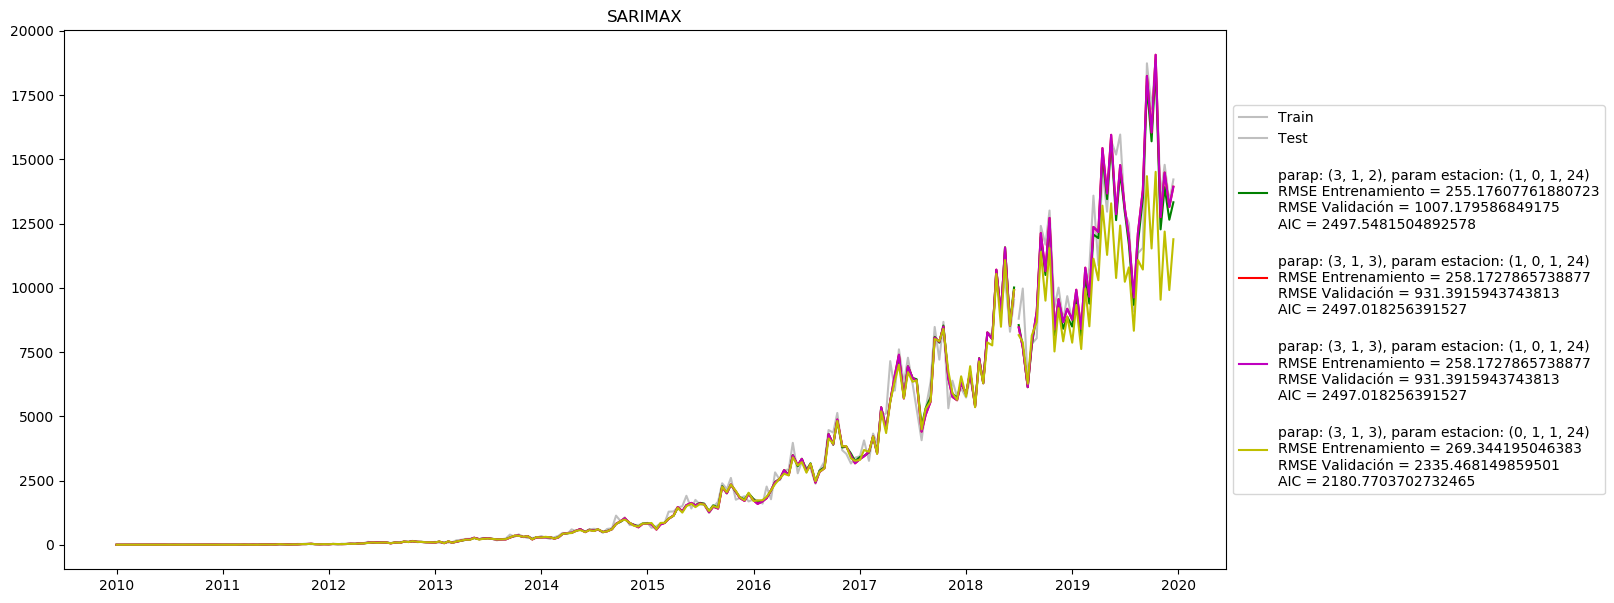

In [92]:
y_pred_SARIMAX = SARIMAX(y_train = y_train, y_test = y_test, order = [SARIMAX_hyperparameters[0][0], SARIMAX_hyperparameters[1][0],  SARIMAX_hyperparameters[2][0], SARIMAX_hyperparameters[3][0]], 
                                            seasonal_order = [SARIMAX_hyperparameters[0][1], SARIMAX_hyperparameters[1][1], SARIMAX_hyperparameters[2][1], SARIMAX_hyperparameters[3][1]],
                        residuals=False,name = "SARIMAX")           

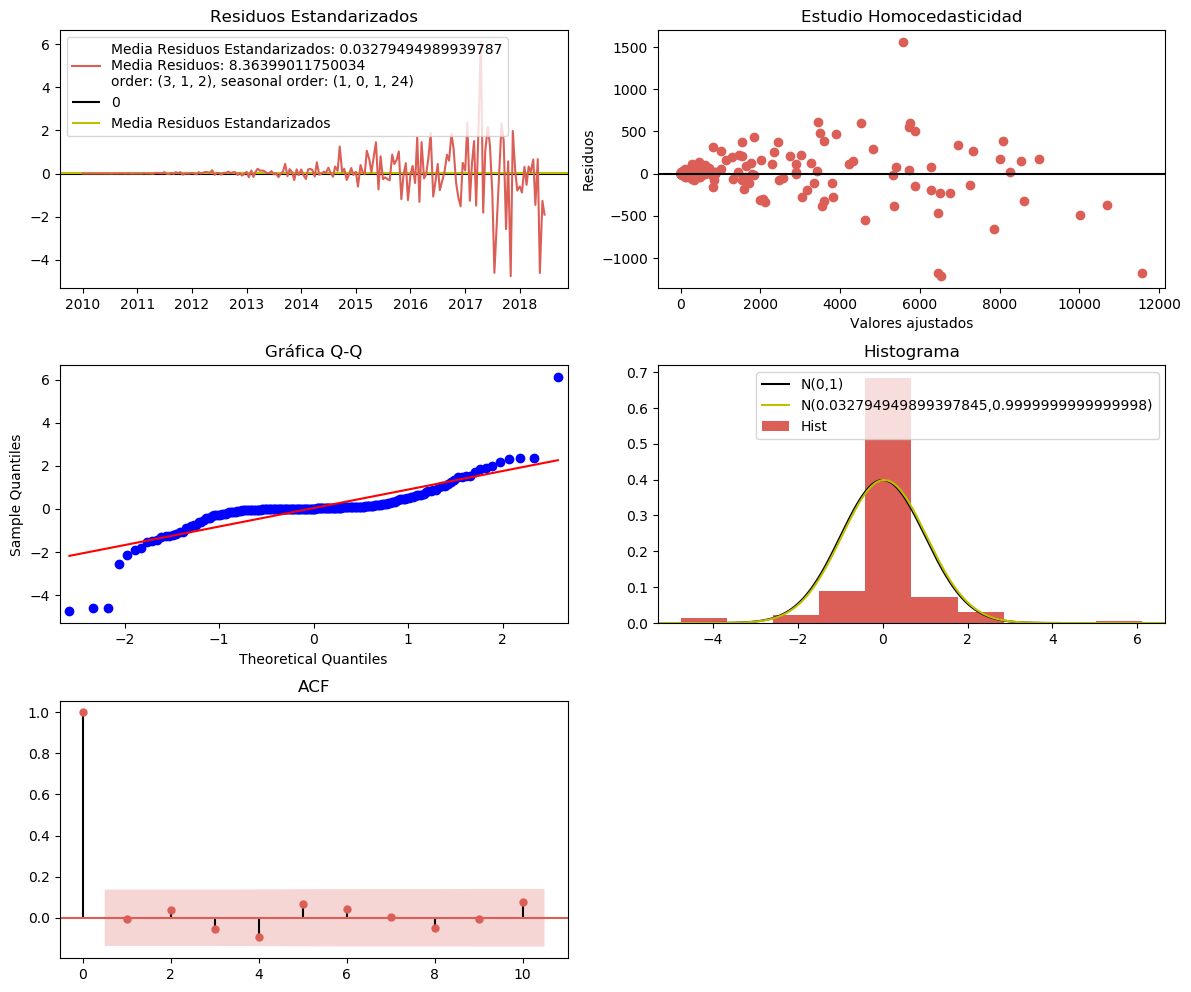

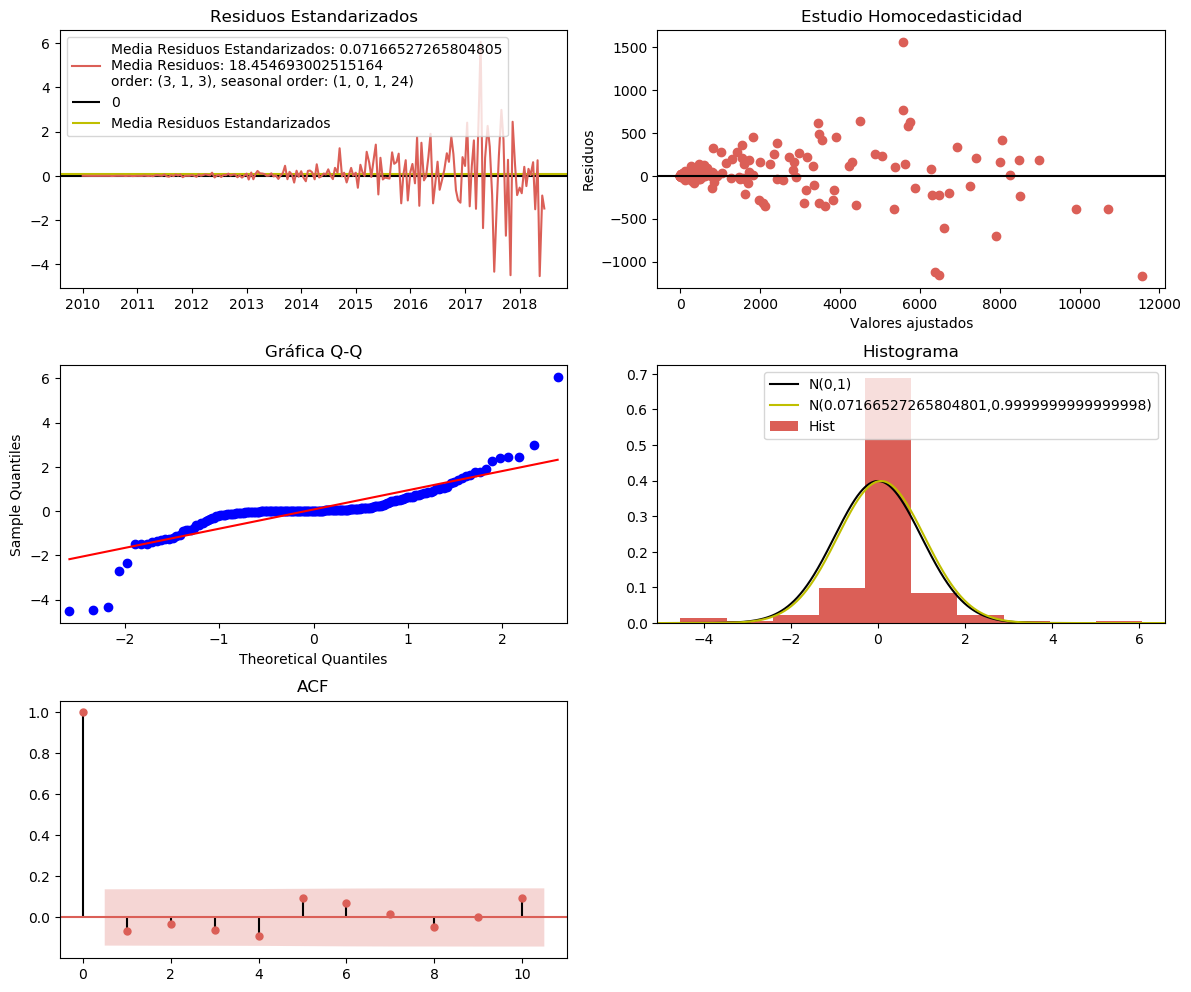

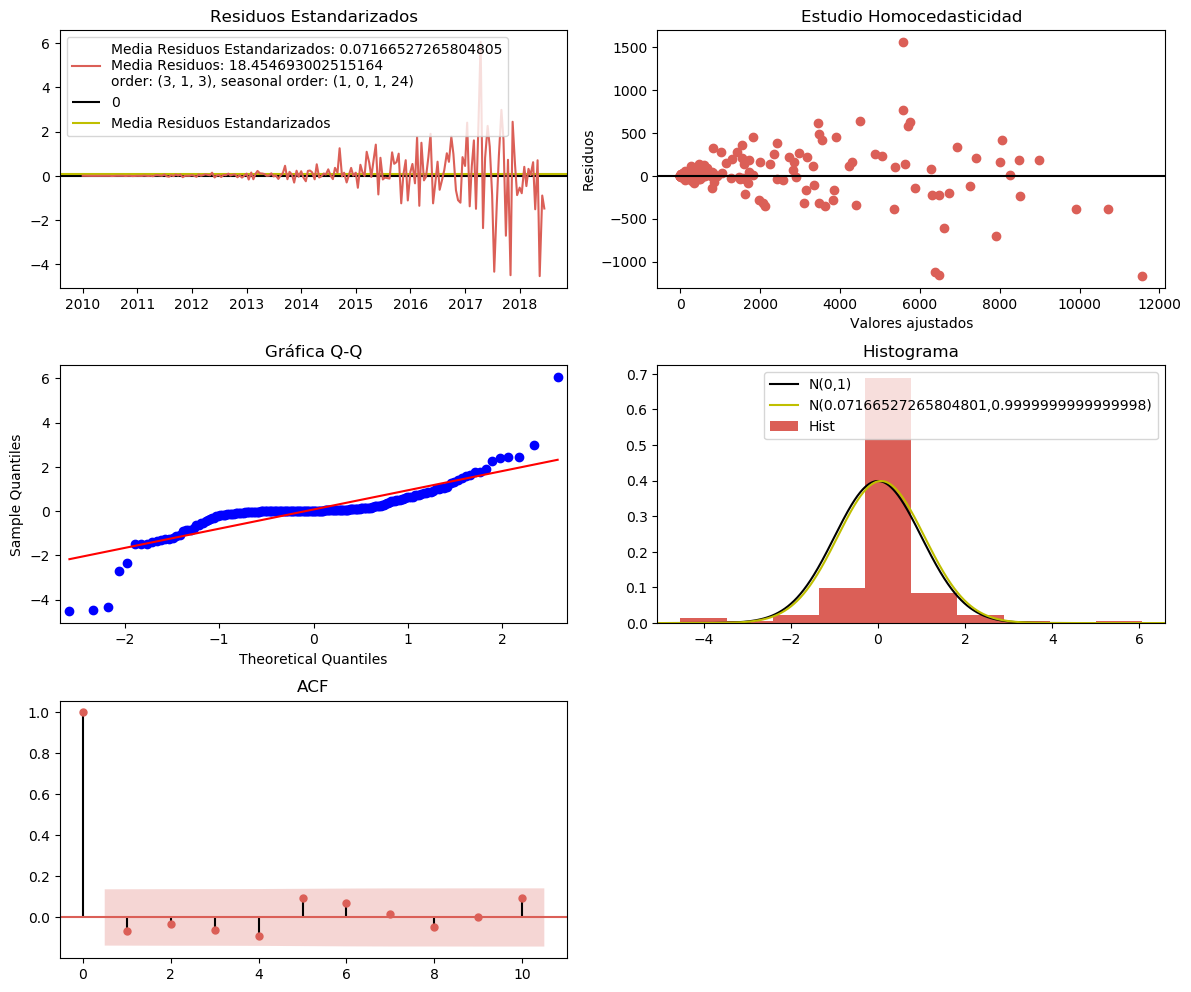

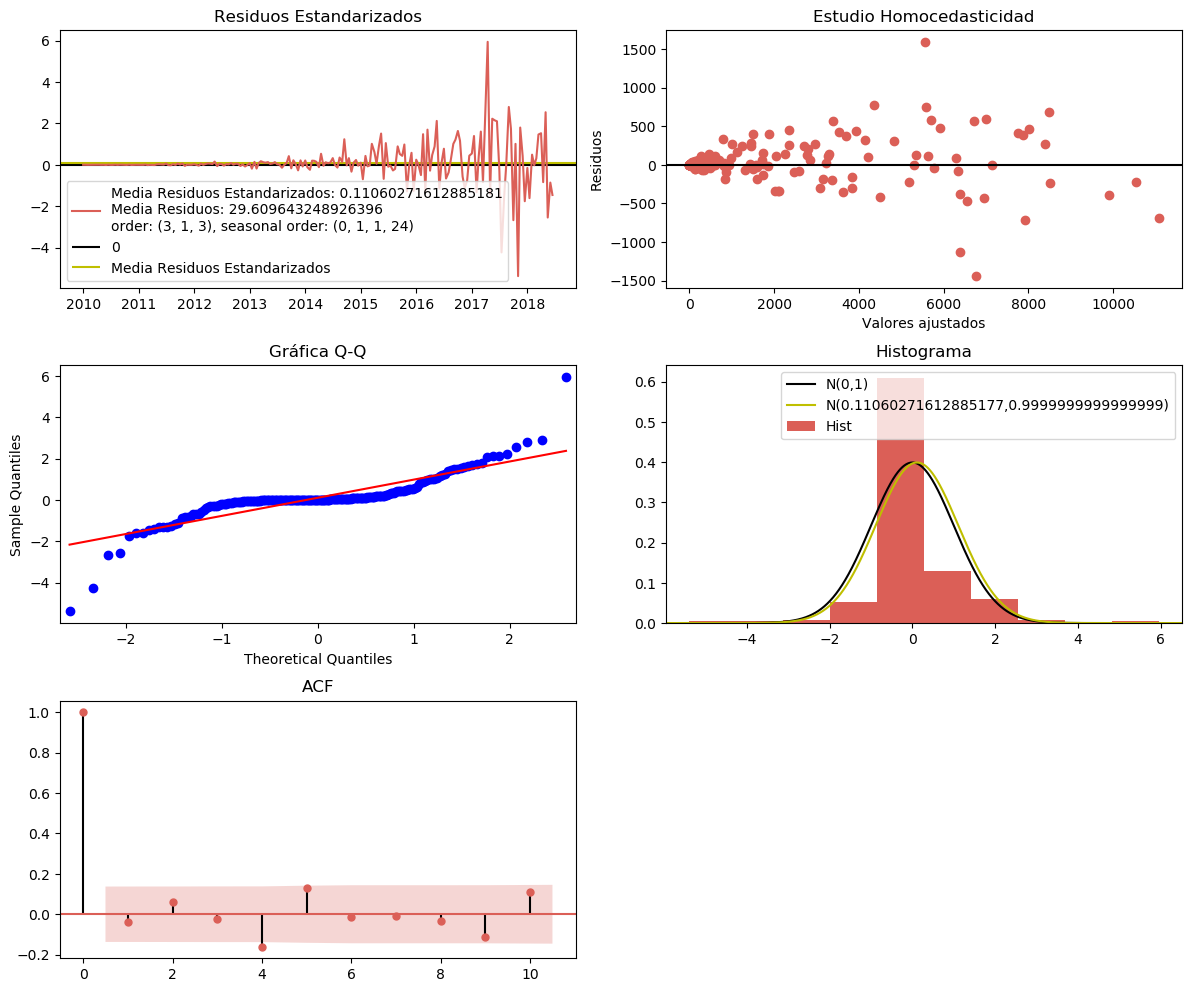

In [93]:
SARIMAX_res = SARIMAX_residuals(y_train = y_train, y_test = y_test, order = [SARIMAX_hyperparameters[0][0], SARIMAX_hyperparameters[1][0],  SARIMAX_hyperparameters[2][0], SARIMAX_hyperparameters[3][0]], 
                                            seasonal_order = [SARIMAX_hyperparameters[0][1], SARIMAX_hyperparameters[1][1], SARIMAX_hyperparameters[2][1], SARIMAX_hyperparameters[3][1]])

### Comparación modelos

Por última vez se comparan los diferentes modelos explicados.

In [94]:
series = [y_pred_naive,  y_pred_average, y_pred_s_naive, y_pred_drift,
          y_pred_SES, y_pred_DES, y_pred_HW_add, y_pred_HW_mul,
          y_pred_AR[2], y_pred_MA[2], y_pred_ARMA[0], y_pred_ARIMA[2], y_pred_SARIMA[2]]
accuracy_comparison = pd.DataFrame()
MAE = [] ; MSE = [] ; MAPE = [] ; R_square = [] ; MedAE = [] ; MSLE = []; RMSE = []
index = []
for i in series :
    MAE.append(mean_absolute_error(y_test, i.values))
    RMSE.append(root_mean_squared_error(y_test, i.values))
    MedAE.append(median_absolute_error(y_test, i.values))
    MSE.append(mean_squared_error(y_test, i.values))
    MAPE.append(mean_absolute_percentage_error(y_test, i.values))
    R_square.append(r2_score(y_test, i.values))    
    MSLE.append(mean_squared_log_error(y_test, i.values))
    index.append(i.name)
accuracy_comparison["MAE"] = MAE ; accuracy_comparison["RMSE"] = RMSE ;accuracy_comparison["MedAE"] = MedAE; accuracy_comparison["MSE"] = MSE; accuracy_comparison["MAPE"] = MAPE; accuracy_comparison["R_cuadrado"] = R_square; accuracy_comparison["MSLE"] = MSLE
accuracy_comparison.index = index 

def highlight_min(s):
    '''
    highlight the minimum in a Series in green.
    '''
    if s.name == "R_cuadrado" : 
        is_max = s == s.max()
        return ['background-color: green' if v else '' for v in is_max]
    else : 
        is_min = s == s.min()
        return ['background-color: green' if v else '' for v in is_min]

In [95]:
accuracy_comparison.style.apply(highlight_min)